<a href="https://colab.research.google.com/github/KonstantinElfimow/household-services-analysis-04/blob/main/household_services_analysis_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Описание проекта:**

Вы работаете аналитиком в международной компании, занимающейся производством и продажами климатического оборудования: систем кондиционирования и вентиляции. На одной из выставок, посвященной климатическому оборудованию, группа инженеров из дружественной компании предоставила результаты своего исследования: данные по использованию климатических систем в офисах разных стран, городов, а также оценочные данные от респондентов по тому, насколько им комфортно было находиться в созданных температурных условиях. Руководство поставило вам задачу проанализировать полученные данные и предоставить выводы о том, в какой тип климатического оборудования стоит инвестировать больше, чтобы повысить удовлетворенность клиентов созданными условиями в зависимости от региона? И на что стоит обратить внимание при развитии бизнеса в разных регионах?

https://drive.google.com/file/d/1f3-PD9uAVNacQZR8qZGY7zBTtOcAOm98/view?usp=drive_link

In [1]:
! gdown --id 1f3-PD9uAVNacQZR8qZGY7zBTtOcAOm98

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1f3-PD9uAVNacQZR8qZGY7zBTtOcAOm98
To: /content/Данные по использованию климатических систем.csv
100% 135k/135k [00:00<00:00, 3.32MB/s]


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import pearsonr, spearmanr, shapiro, mannwhitneyu, ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_percentage_error, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2_contingency, f_oneway, kruskal, spearmanr
from typing import Tuple
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
df = pd.read_csv('/content/Данные по использованию климатических систем.csv',
                 sep=';',
                 skipinitialspace=True)
df.columns = df.columns.str.lower().str.replace(' ', '_')

# 0. Основные функции

In [4]:
num_digits = 4

In [5]:
def numeric_hypothesis_test(sample_1, sample_2) -> Tuple[float, str]:
  '''Функция для проверки статистических гипотез на 2 группах'''
  if len(sample_1) < 3 or len(sample_2) < 3:
    return np.nan, np.nan

  if shapiro(sample_1)[1] >= 0.05 and shapiro(sample_2)[1] >= 0.05:
      method = 'Стьюдент'
      p_value = ttest_ind(sample_1, sample_2, equal_var=False)[1]
  else:
      method = 'Манн-Уитни'
      p_value = mannwhitneyu(sample_1, sample_2, alternative='two-sided')[1]

  if p_value > 0:
    order = math.floor(math.log10(abs(p_value))) + 1
    p_value = round(p_value, num_digits - order)
  return p_value, method

In [6]:
def correlation_ratio(categories, values) -> float:
  '''Функция для расчета коэффициента корреляции Eta'''
  ssw = 0
  ssb = 0
  if np.var(values) == 0:
    return 0
  for category in categories.unique():
    subgroup = values[np.where(categories == category)[0]]
    ssw += np.sum((subgroup - np.mean(subgroup)) ** 2)
    ssb += subgroup.shape[0] * (np.mean(subgroup) - np.mean(values)) ** 2
  try:
    return round((ssb / (ssb + ssw)) ** 0.5, 2)
  except ZeroDivisionError as ex:
    return np.nan

In [7]:
def crammer_and_pvalue(df, col1: str, col2: str) -> Tuple[float, float]:
  '''Функция для проверки гипотез для качественных признаков'''
  data = pd.crosstab(df[col1], df[col2])
  if data.isnull().all().all():
    return np.nan, np.nan
  data = data.fillna(0).astype(int)
  data = data.to_numpy()
  chi2, p_value = chi2_contingency(data, correction=True)[:2]
  n = np.sum(data)
  min_dim = min(data.shape) - 1
  corr = np.sqrt((chi2 / n) / min_dim)

  if p_value > 0:
    order = math.floor(math.log10(abs(p_value))) + 1
    p_value = round(p_value, num_digits - order)
  return round(corr, 2), p_value

In [8]:
def multi_group_analyze(df, column1, column2):
    '''Функция для проверки статистических гипотез на 3 и более группах'''
    data_groups = list(df[column1].unique())

    groups = []
    tests = []

    for i in range(len(data_groups)):
        group_data = df[df[column1] == data_groups[i]][column2]
        group_data = group_data.dropna()
        _, p_value_shapiro = shapiro(group_data)
        groups.append(group_data)
        tests.append(p_value_shapiro)

    check = all(value >= 0.05 for value in tests)

    if check == True:
      stat, p_value = f_oneway(*groups)
      print(f'ANOVA, Стастистика: {stat}, p-value: {p_value}')
    else:
      stat, p_value = kruskal(*groups)
      print(f'Краскел-Уоллес, стастистика: {round(stat, 4)}, p-value: {round(p_value, 4)}')

In [9]:
def calculate_correlation_matrix(df):
    '''Функция для построения матрицы корреляция в зависимости от типа данных
    в разных столбца датафрейма'''
    corr_df = pd.DataFrame(index=df.columns, columns=df.columns)

    for column1 in df.columns:
        for column2 in df.columns:
          if column1 == column2:
            corr_df.loc[column1, column2] = 1.0
          else:
            if (df[column1].dtype in ('object', 'category')) and (df[column2].dtype in ('object', 'category')):
              corr_df.loc[column1, column2] = crammer_and_pvalue(df, column1, column2)[0]

            elif (df[column1].dtype in ('int64', 'float64')) and (df[column2].dtype in ('int64', 'float64')):
              corr = df[[column1, column2]].corr(method='spearman').iloc[0, 1]
              corr_df.loc[column1, column2] = corr
            else:
              if df[column1].dtype in ('object', 'category'):
                corr_df.loc[column1, column2] = correlation_ratio(df[column1], df[column2])
              elif df[column2].dtype in ('object', 'category'):
                corr_df.loc[column1, column2] = correlation_ratio(df[column2], df[column1])

    for col in corr_df.columns:
      corr_df[col] = corr_df[col].astype('float64')
    return corr_df

# 1. Исследование данных на качество и предобработка

In [10]:
# напишем функцию первичной проверки данных
def check_data(data_df):
  '''Функция для вывода общих сведений о датафрейме'''
  print('\033[1m' + 'Изучим исходные данные' + '\033[0m')
  print(data_df.info())
  # проверим nan
  print('\033[1m' + '\nПроверка пропусков' + '\033[0m')
  print('Количество пропусков:\n{:.0f}'.format(data_df.isnull().sum().sum()))
  print('Доля пропусков:\n{}'.format(data_df.isna().mean()))
  plt.figure(figsize=(10, 6))
  sns.heatmap(df.isna().T);
  plt.suptitle('Оценка пропусков на heatmap')
  plt.show()
  print()
  # проверим дубликаты
  print('\033[1m' + '\nПроверка на дубликаты' + '\033[0m')
  print('Количество полных дубликатов:\n', data_df.duplicated().sum())
  # посмотрим на сами данные
  print('\033[1m' + '\nПервые 10 строк датасета' + '\033[0m')
  display(data_df.head(10))

  print('\033[1m' + '\nОписание количественных данных:' + '\033[0m')
  display(data_df.describe(exclude=['object', 'category']).T)
  print('\033[1m' + '\nГрафическое представление количественных данных:' + '\033[0m')
  for numeric_column in data_df.select_dtypes(exclude=['object', 'category']).columns:
    sns.histplot(data_df[numeric_column])
    plt.suptitle(f'гистограмма распределения ({numeric_column})')
    plt.show()
    print()

  print('\033[1m' + '\nОписание категориальных данных:' + '\033[0m')
  display(data_df.describe(include=['object', 'category']).T)
  print('\033[1m' + '\nГрафическое представление категориальных данных:' + '\033[0m')
  for categoty_column in data_df.select_dtypes(include=['object', 'category']).columns:
    table = data_df[categoty_column].value_counts().reset_index()
    table.columns = ['col1', 'count']
    plt.pie(table['count'], labels=table['col1'], autopct='%1.1f%%')
    plt.suptitle(f'Круговая диаграмма распределения ({numeric_column})')
    plt.show()
    print()

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484 entries, 0 to 483
Data columns (total 30 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   год                                          484 non-null    float64
 1   время_года                                   484 non-null    object 
 2   климат                                       484 non-null    object 
 3   город                                        484 non-null    object 
 4   страна                                       484 non-null    object 
 5   способ_охлаждения                            484 non-null    object 
 6   режим_при_смешанном_типе_охлаждения          337 non-null    object 
 7   способ_обогрева                              222 non-null    object 
 8   возраст                                      413 non-null    float64
 9   пол                                          412 non-

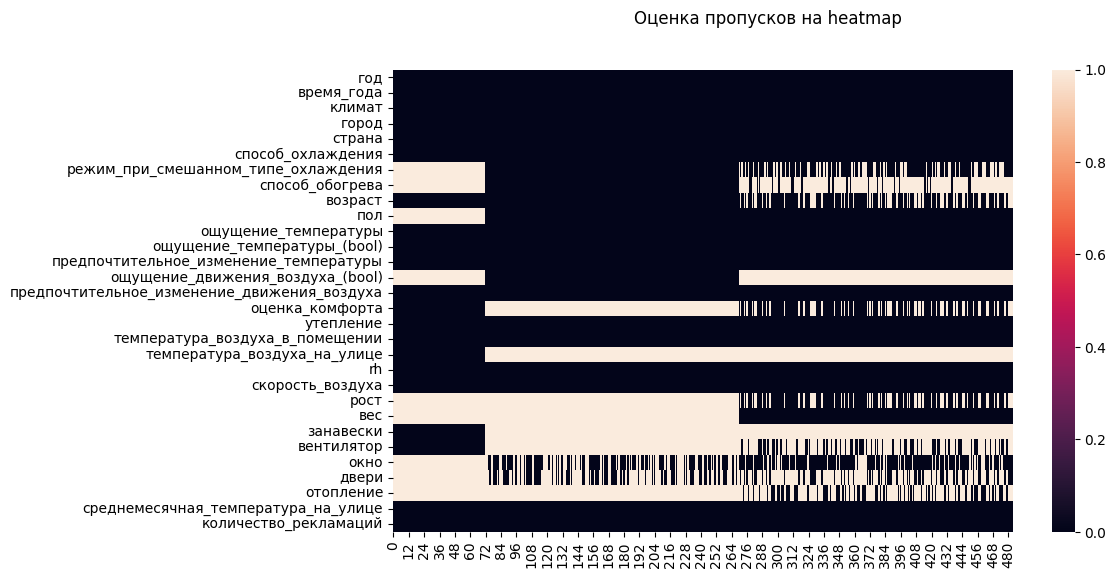



Проверка на дубликаты
Количество полных дубликатов:
 2

Первые 10 строк датасета


год время_года                       климат  город страна  \
0  2011.0       Лето  Cубтропический океанический  Техас    США   
1  2011.0       Лето  Cубтропический океанический  Техас    США   
2  2011.0       Лето  Cубтропический океанический  Техас    США   
3  2011.0       Лето  Cубтропический океанический  Техас    США   
4  2011.0       Лето  Cубтропический океанический  Техас    США   
5  2011.0       Лето  Cубтропический океанический  Техас    США   
6  2011.0       Лето  Cубтропический океанический  Техас    США   
7  2011.0       Лето  Cубтропический океанический  Техас    США   
8  2011.0       Лето  Cубтропический океанический  Техас    США   
9  2011.0       Лето  Cубтропический океанический  Техас    США   

   способ_охлаждения режим_при_смешанном_типе_охлаждения способ_обогрева  \
0  Кондиционирование                                 NaN             NaN   
1  Кондиционирование                                 NaN             NaN   
2  Кондиционирование                                 NaN             NaN   
3  Кондиционирование                                 NaN             NaN   
4  Кондиционирование                                 NaN             NaN   
5  Кондиционирование                                 NaN             NaN   
6  Кондиционирование                                 NaN             NaN   
7  Кондиционирование                                 NaN             NaN   
8  Кондиционирование                                 NaN             NaN   
9  Кондиционирование                                 NaN             NaN   

   возраст  пол  ощущение_температуры  ощущение_температуры_(bool)  \
0     22.0  NaN                   0.0                          1.0   
1     40.0  NaN                  -2.0                          1.0   
2     42.0  NaN                   1.0                          1.0   
3     27.0  NaN                  -0.5                          0.0   
4     46.0  NaN                   0.0                          1.0   
5     27.0  NaN                   0.0                          1.0   
6     32.0  NaN                  -1.0                          1.0   
7     30.0  NaN                  -2.0                          1.0   
8     43.0  NaN                   0.0                          1.0   
9     43.0  NaN                   1.0                          0.0   

  предпочтительное_изменение_температуры  ощущение_движения_воздуха_(bool)  \
0                          Без изменений                               NaN   
1                          Без изменений                               NaN   
2                          Без изменений                               NaN   
3                                 Теплее                               NaN   
4                          Без изменений                               NaN   
5                          Без изменений                               NaN   
6                                 Теплее                               NaN   
7                                 Теплее                               NaN   
8                          Без изменений                               NaN   
9                               Холоднее                               NaN   

  предпочтительное_изменение_движения_воздуха  оценка_комфорта  утепление  \
0                               Без изменений              3.5       0.54   
1                               Без изменений              6.0       0.61   
2                               Без изменений              5.0       0.57   
3                               Без изменений              2.5       0.61   
4                                      Меньше              4.5       0.57   
5                               Без изменений              5.0       0.54   
6                                      Меньше              3.5       0.57   
7                               Без изменений              4.3       0.61   
8                               Без изменений              5.0       0.57   
9                              


Описание количественных данных:


count         mean        std      min  \
год                                  484.0  2011.033058   0.922988  2010.00   
возраст                              413.0    40.634383  11.001301    22.00   
ощущение_температуры                 484.0     0.203306   1.091976    -3.00   
ощущение_температуры_(bool)          484.0     0.789256   0.408259     0.00   
ощущение_движения_воздуха_(bool)     198.0     0.752525   0.432639     0.00   
оценка_комфорта                      215.0     4.772093   1.261161     1.00   
утепление                            484.0     0.634587   0.253103     0.36   
температура_воздуха_в_помещении      484.0    26.072107   7.681363    16.20   
температура_воздуха_на_улице          72.0    24.104167   0.604546    22.80   
rh                                   484.0    52.973760  13.036204    23.80   
скорость_воздуха                     484.0     0.760558   4.921106     0.00   
рост                                 143.0   164.411678  21.273235     5.23   
вес                                  214.0    65.471963  11.574079    42.00   
занавески                             72.0     0.513889   0.503315     0.00   
вентилятор                           146.0     0.527397   0.500967     0.00   
окно                                 279.0     0.247312   0.432225     0.00   
двери                                157.0     0.184713   0.389307     0.00   
отопление                             79.0     0.784810   0.413580     0.00   
среднемесячная_температура_на_улице  484.0    27.389669  19.469562     8.50   
количество_рекламаций                484.0     0.105372   0.440276     0.00   

                                          25%      50%       75%      max  
год                                  2010.000  2011.00  2012.000  2012.00  
возраст                                35.000    42.00    45.000    65.00  
ощущение_температуры                    0.000     0.00     1.000     3.00  
ощущение_температуры_(bool)             1.000     1.00     1.000     1.00  
ощущение_движения_воздуха_(bool)        1.000     1.00     1.000     1.00  
оценка_комфорта                         4.000     5.00     6.000     6.00  
утепление                               0.460     0.59     0.700     2.08  
температура_воздуха_в_помещении        23.800    24.60    25.900    77.00  
температура_воздуха_на_улице           23.800    24.10    24.400    25.90  
rh                                     42.775    53.75    62.325    85.10  
скорость_воздуха                        0.060     0.10     0.140    63.83  
рост                                  160.000   165.10   172.700   190.50  
вес                                    57.000    65.00    72.750   110.00  
занавески                               0.000     1.00     1.000     1.00  
вентилятор                              0.000     1.00     1.000     1.00  
окно                                    0.000     0.00     0.000     1.00  
двери                                   0.000     0.00     0.000     1.00  
отопление                               1.000     1.00     1.000     1.00  
среднемесячная_температура_на_улице    22.000    22.00    30.800   328.00  
количество_рекламаций                   0.000     0.00     0.000     3.00


Графическое представление количественных данных:


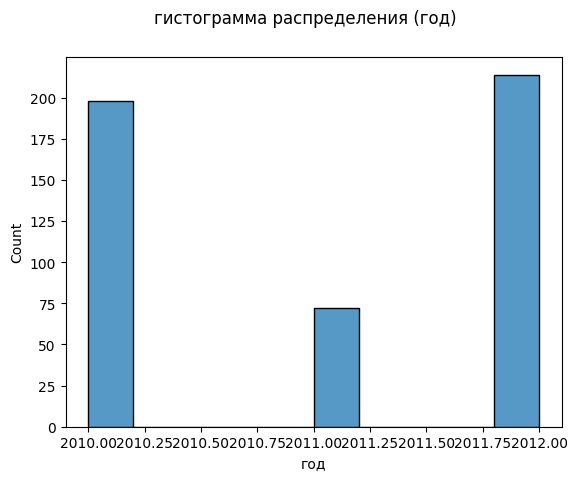

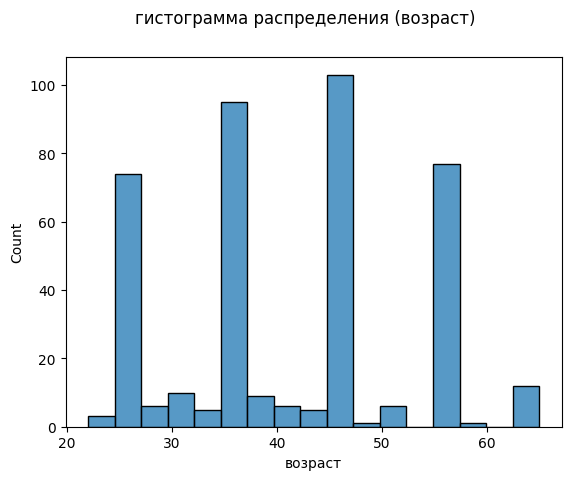

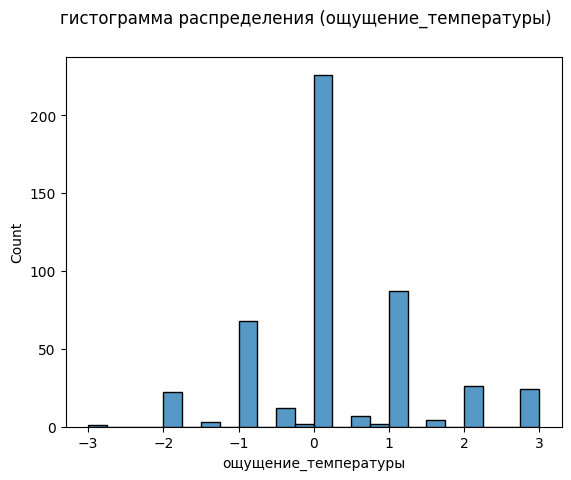

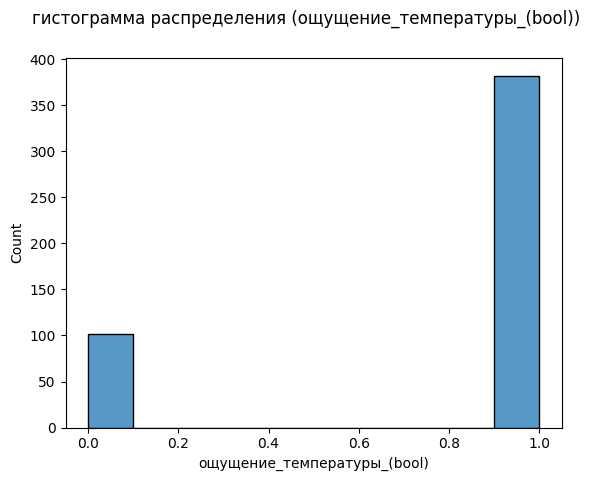

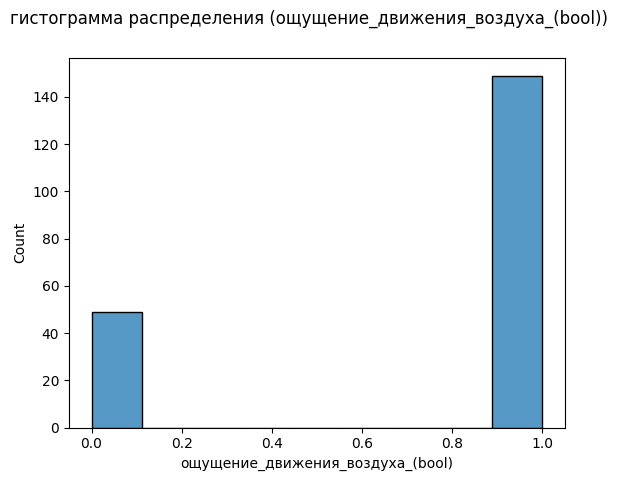

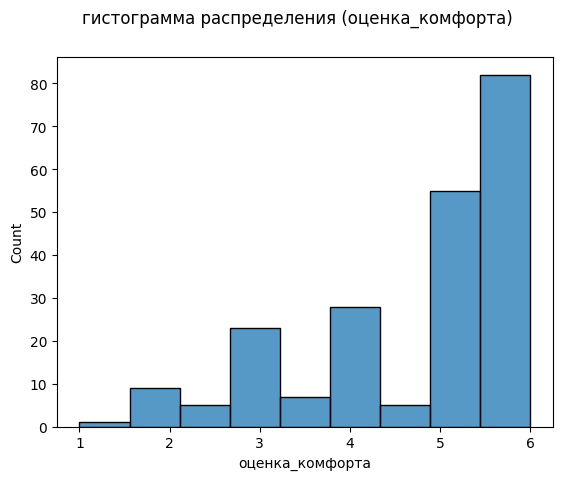

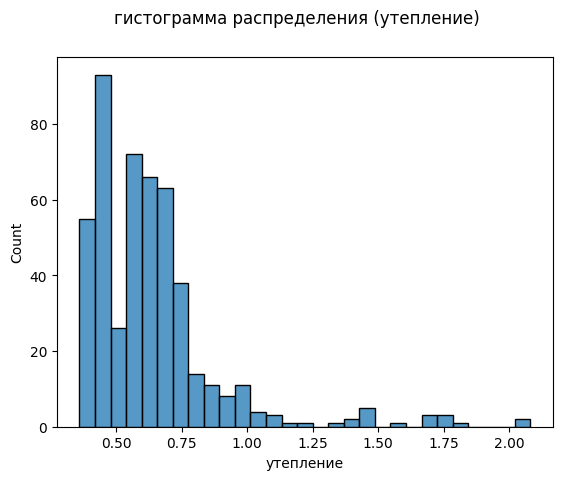

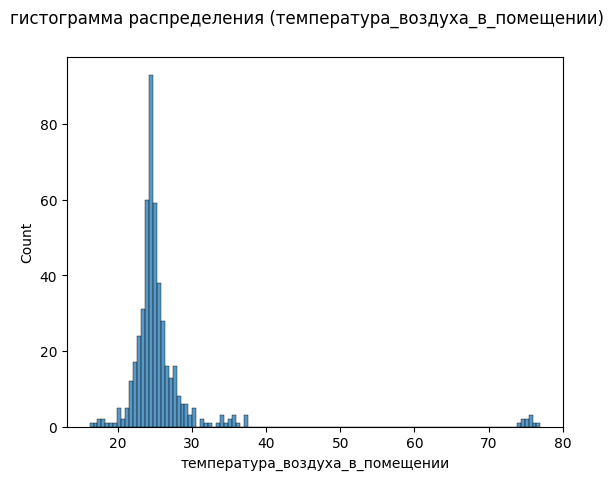

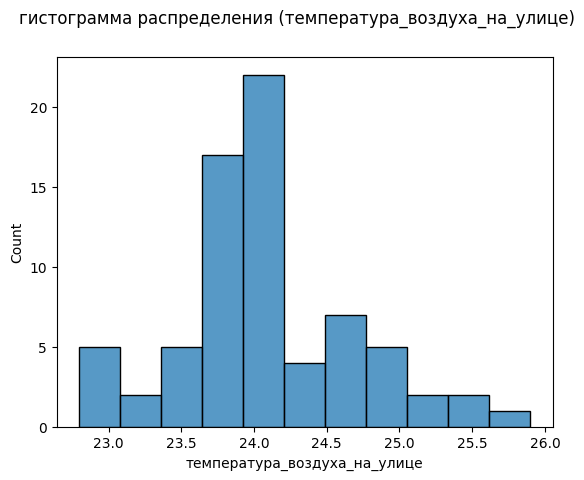

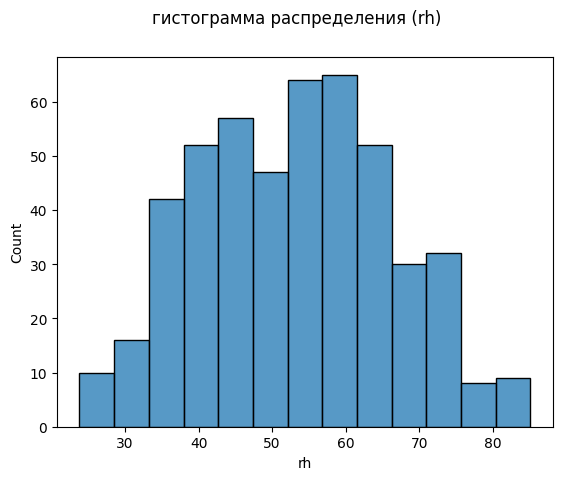

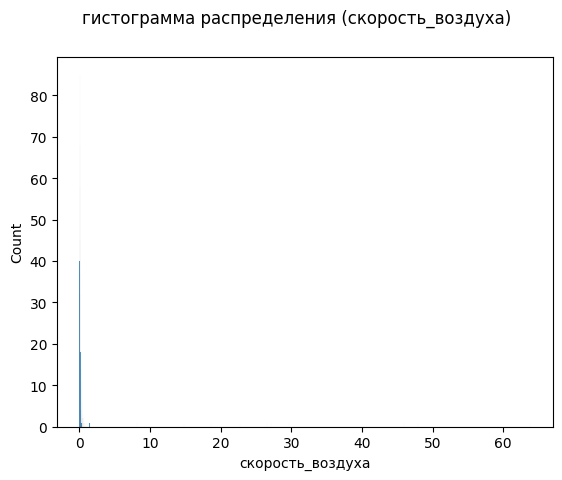

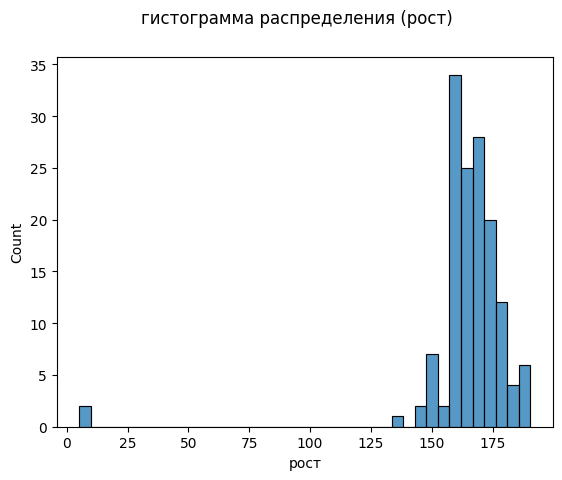

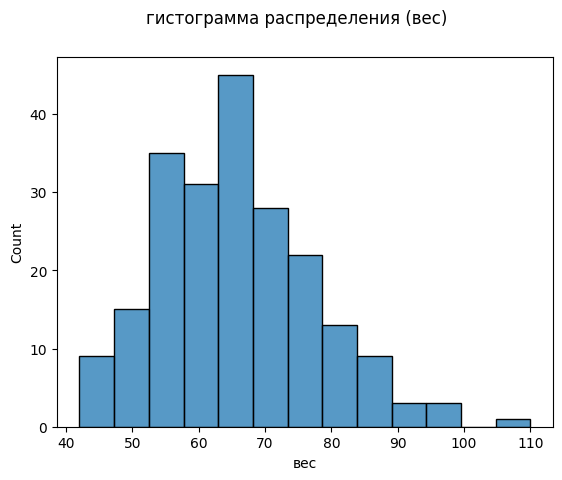

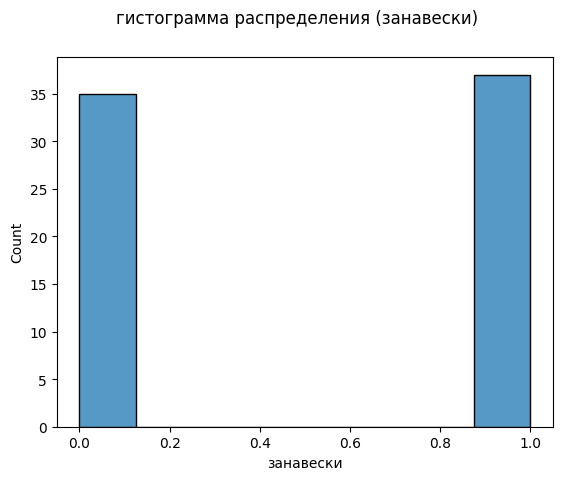

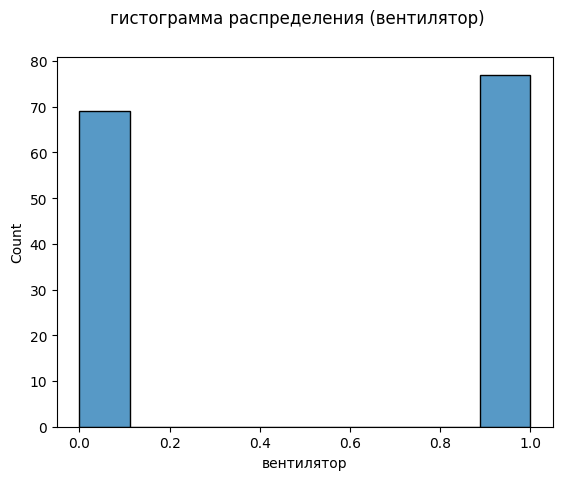

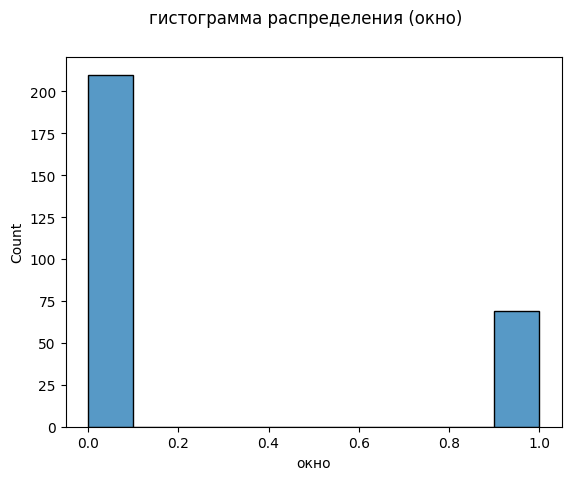

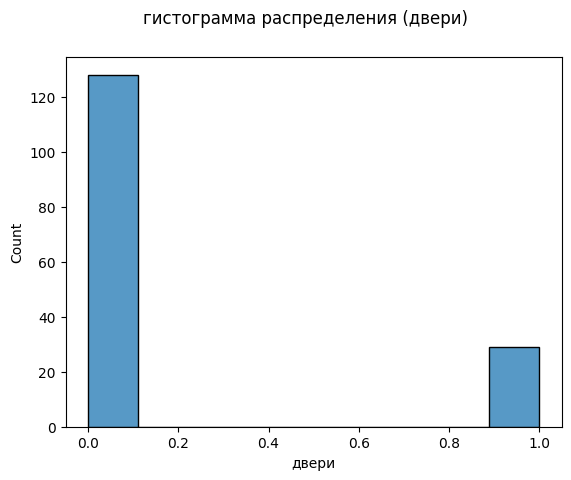

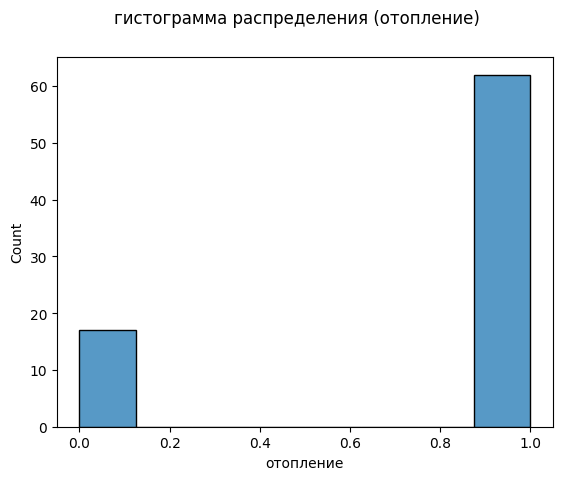

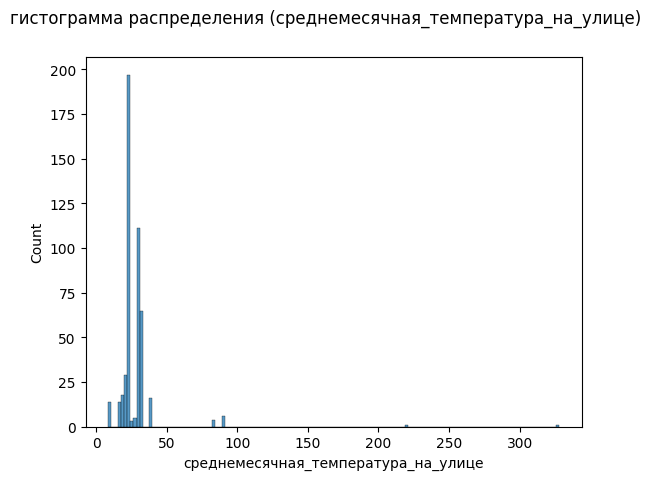

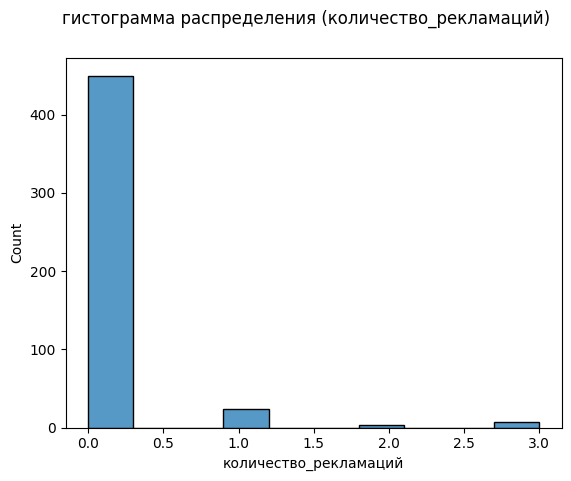



Описание категориальных данных:


count unique  \
время_года                                    484      4   
климат                                        484      6   
город                                         484      8   
страна                                        484      3   
способ_охлаждения                             484      3   
режим_при_смешанном_типе_охлаждения           337      2   
способ_обогрева                               222      1   
пол                                           412      2   
предпочтительное_изменение_температуры        484      5   
предпочтительное_изменение_движения_воздуха   484      3   

                                                                     top freq  
время_года                                                          Лето  372  
климат                                       Cубтропический океанический  269  
город                                                             Сидней  198  
страна                                                             Индия  214  
способ_охлаждения                                              Смешанный  337  
режим_при_смешанном_типе_охлаждения                    Кондиционирование  237  
способ_обогрева                                   Механическое отопление  222  
пол                                                              Мужской  254  
предпочтительное_изменение_температуры                     Без изменений  288  
предпочтительное_изменение_движения_воздуха                Без изменений  291


Графическое представление категориальных данных:


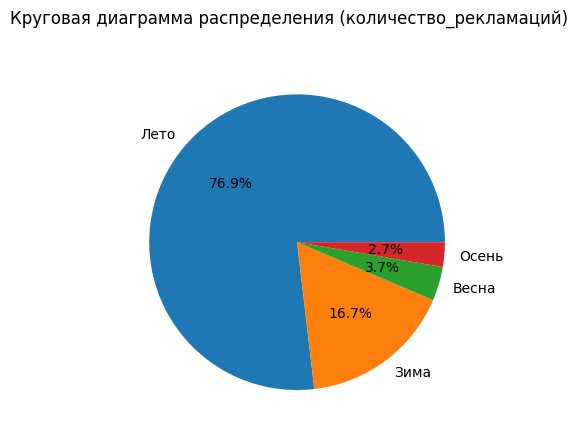

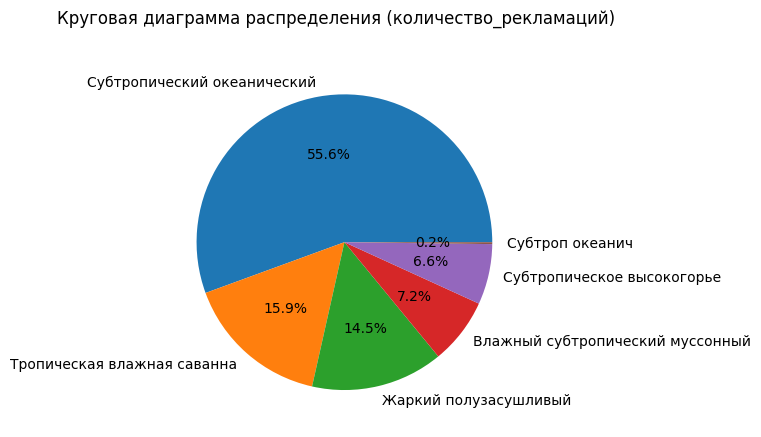

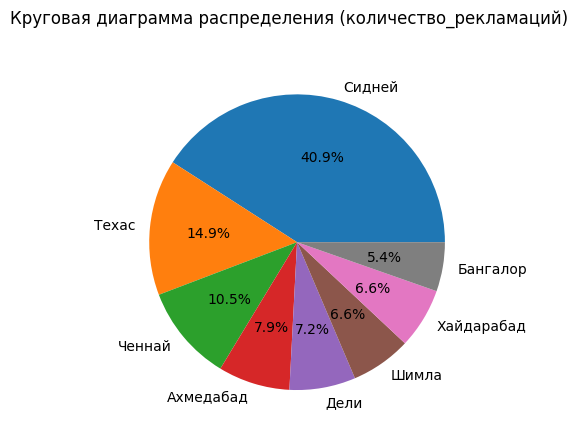

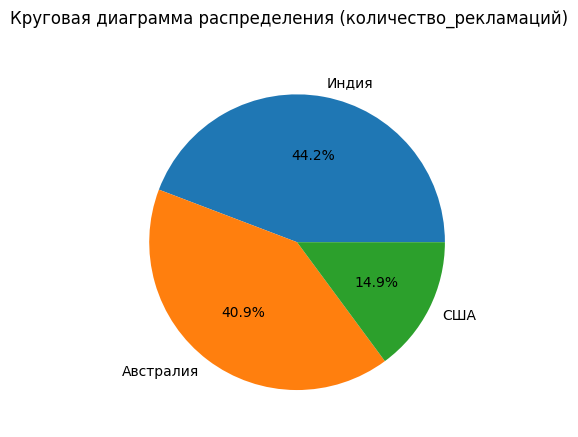

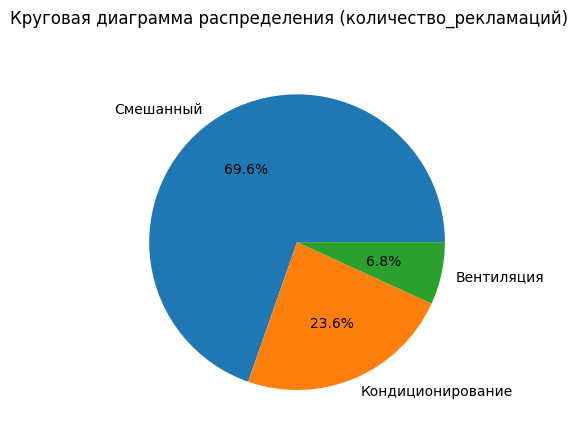

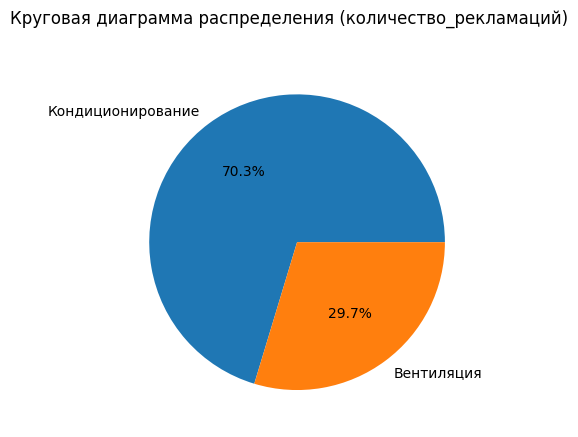

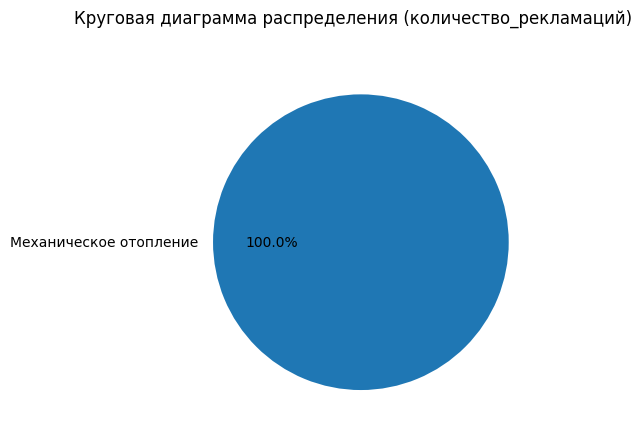

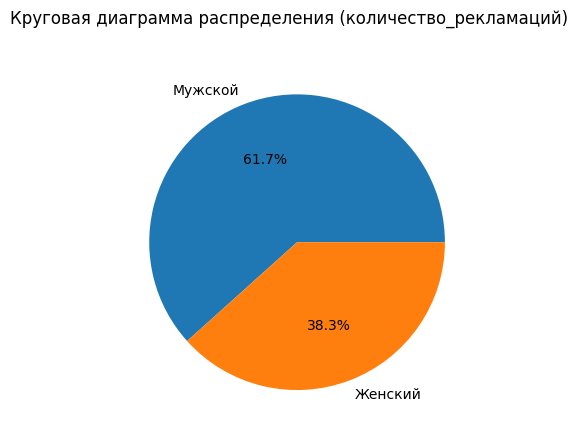

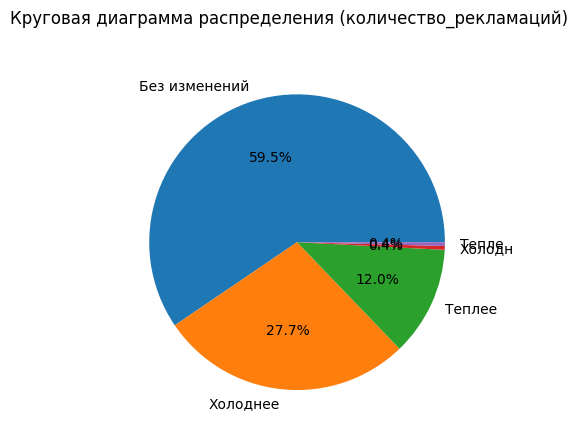

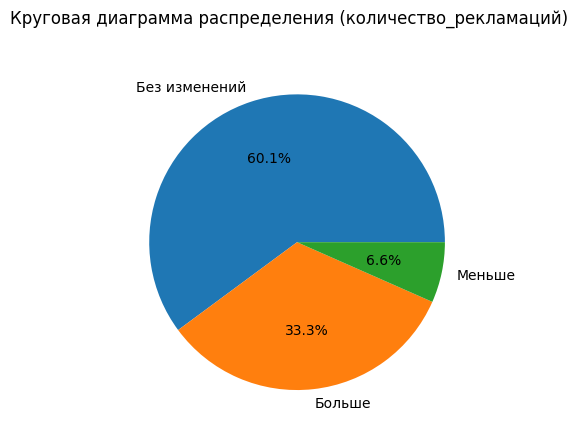

In [11]:
check_data(df)

**Выводы:**
0. Есть ошибки в определении типов данных.
1. Много пропусков в отоплении.
2. Если предпочтительное изменение движения воздуха = без изменений, то следовательно, заказчика всё устраивает и он считает это **приемлемым**. Тогда Na можно заполнить на приемлемое (= 1) в предпочтительное изменение движения воздуха (bool). Стоит проверить статистически этот метод заполнения пропусков.
3. Na в колонке с температурой на улице можно заменить на среднее среднемесячную температуру в данном климате и сезоне.
4. Открыт вопрос значимости колонок роста и веса, возможно, их стоит дропнуть. В росте были замечены выбросы в меньшую сторону. Возможно, используется не метрическая система.
5. Есть выбросы в температуре воздуха в помещении. Это связано с тем, что температура была измерена в Фаренгейт (скорее всего), значения получаются хорошие, если перевести в Цельсии. Вопрос, на который стоит ответить, используется в данной стране не метрическая система?
6. В скорости воздуха есть большие выбросы.
7. Есть ошибки в значениях климат и предпочтительное изменение температуры.
8. Есть выбросы в среднемесячной температуре на улице, но там не только Фаренгейты, но и ошибка в постановке знака после запятой для 3-х значных чисел.
9. Есть вариант заполнить Nan в занавесках, вентиляторе, окне, дверям и отоплению по их взаимосвязи между собой, а также по способу охлаждения.
10. Есть 2 полных дубликата.
11. Есть орфографические ошибки в некоторых категориях.
12. Выяснился также интересный факт: что в период 2010-2012 года было только по одной стране. А значит, временные ряды анализировать не придётся. Ещё это значит, что группы полностью независимы и их анализ можно проводить отдельно друг от друг. Это увеличит достоверность проверок гипотез в данных, а также может повлиять на методы борьбы с выбросами для этих групп! Доказательство о независимости:

In [12]:
df.groupby('год')['страна'].value_counts(normalize=True).to_frame()

страна
год    страна           
2010.0 Австралия     1.0
2011.0 США           1.0
2012.0 Индия         1.0

## 1.1 Приведение данных к правильному типу

In [13]:
# приводим год к datetime
col = 'год'
df[col] = pd.to_datetime(df[col].astype(int), format='%Y')

# Исправляем ошибки: 'Cубтроп океанич' на 'Cубтропический океанический',
# Тепле на Теплее и Холодн на Холоднее
col = 'климат'
df[col] = df[col].replace(to_replace={'Cубтроп океанич': 'Cубтропический океанический'})
col = 'предпочтительное_изменение_температуры'
df[col] = df[col].replace(to_replace={'Тепле': 'Теплее', 'Холодн': 'Холоднее'})

# Округляем по математическому правилу оценку комфорта
col = 'оценка_комфорта'
df[col] = df[col].round(0)

## 1.2 Удаляем полные дубликаты

In [14]:
df = df.drop_duplicates().reset_index(drop=True)

## 1.3 Обработка выбросов

Сделаем сначала наиболее очевидную обработку выбросов.

### 1.3.1 Выбросы в температуре

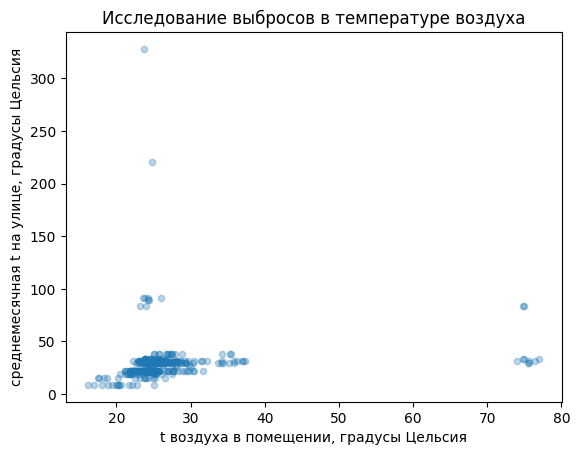

In [15]:
df.plot(x='температура_воздуха_в_помещении',
        y='среднемесячная_температура_на_улице',
        kind='scatter', alpha=0.3)
plt.xlabel('t воздуха в помещении, градусы Цельсия')
plt.ylabel('среднемесячная t на улице, градусы Цельсия')
plt.title('Исследование выбросов в температуре воздуха')
plt.show();

In [16]:
# Руководствуясь здравым смыслом, можно предополжить, что вряд ли температура
# воздуха в США, Австралии или Индии была бы выше 40 градусов в среднем по месяцу.
# Также вряд ли есть предприятия, где прижилась бы система охлаждения при >70
# градусов Цельсия. Это очевидно выбросы.

In [17]:
# Мы хотим проверить можно ли перевести из Фаренгейт в Цельсии, но надо знать
# оправданы ли наши подозрения. Может, в этой стране используют только Цельсии
# как основную меру температуры.
col = 'температура_воздуха_в_помещении'
index1 = df[df[col] > 60].index.tolist()
col = 'среднемесячная_температура_на_улице'
index2 = df[(50 < df[col]) & (df[col] < 100)].index.tolist()

index = list(set(index1) & set(index2))
df.loc[index, 'страна'].value_counts(normalize=True)

США    1.0
Name: страна, dtype: float64

In [18]:
# Выбросы только по данным в США. Там чаще пользуются Фаренгейтами,
# чем Цельсиями, поэтому неудивительно, что такие выбросы возникли.
# Можно смело пользоваться формулой по переводу из Фаренгейт в Цельсии.
# Мы доказали, что выбросы связаны с особенностями системы измерения страны.

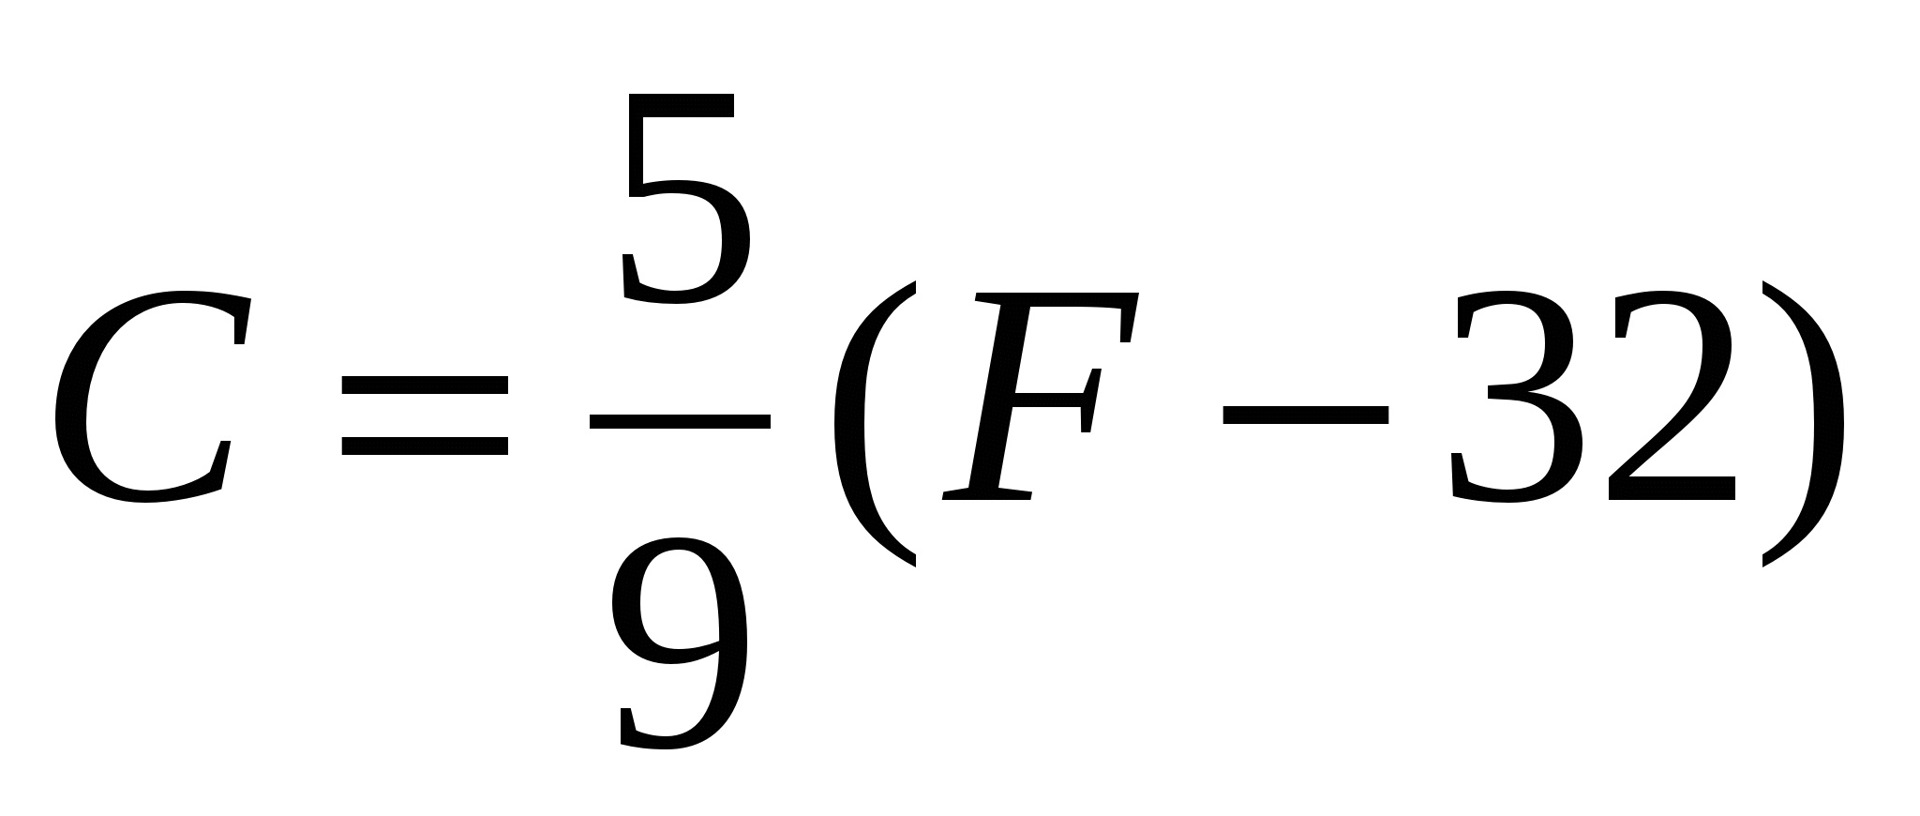

In [19]:
# Обработаем выбросы в температуре воздуха в помещении
col = 'температура_воздуха_в_помещении'
index = df[df[col] > 60].index.tolist()
df.loc[index, col] = round((5 / 9) * (df.loc[index, col] - 32), 1)

In [20]:
# Обработаем выбросы в среднемесячной температуре
col = 'среднемесячная_температура_на_улице'
index1 = df[(50 < df[col]) & (df[col] < 100)].index.tolist()
df.loc[index1, col] = round((5 / 9) * (df.loc[index1, col] - 32), 1)
index2 = df[df[col] >= 100].index.tolist()
df.loc[index2, col] = round(df.loc[index2, col] / 10, 1)

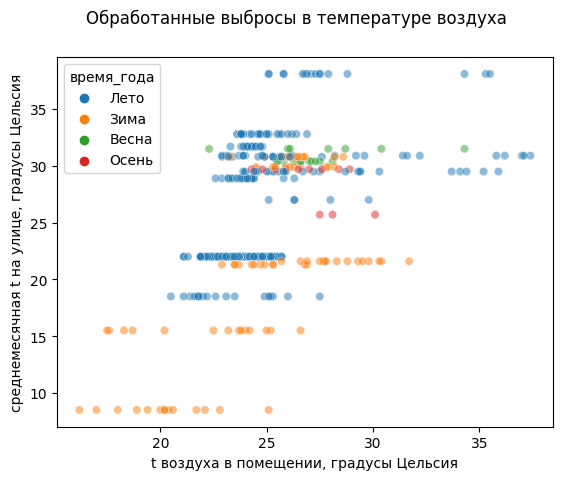

In [21]:
sns.scatterplot(data=df, x='температура_воздуха_в_помещении',
                y='среднемесячная_температура_на_улице',
                alpha=0.5, hue='время_года')
plt.xlabel('t воздуха в помещении, градусы Цельсия')
plt.ylabel('среднемесячная t на улице, градусы Цельсия')
plt.suptitle('Обработанные выбросы в температуре воздуха')
plt.show();

### 1.3.2 Выбросы в росте

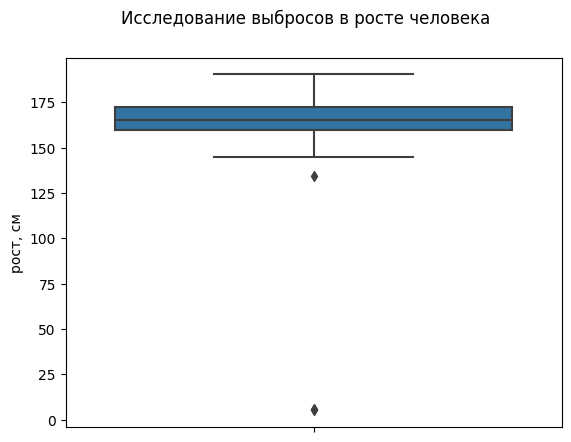

In [22]:
sns.boxplot(data=df, y='рост')
plt.ylabel('рост, см')
plt.suptitle('Исследование выбросов в росте человека')
plt.show();

In [23]:
# Видим выброс в меньшую сторону. Посмотрим, может, снова используется
# другая мера длины.
q1, q3 = df['рост'].quantile(0.25), df['рост'].quantile(0.75)
h = q3 - q1
index = df[df['рост'] < q1 - 3 * h].index.to_list()
for_replace = df.loc[index, ['рост', 'страна']]

display(for_replace)
display(for_replace['страна'].value_counts(normalize=True))

рост страна
287  5.23  Индия
306  5.74  Индия

Индия    1.0
Name: страна, dtype: float64

In [24]:
# а вот тут уже сложно ответить это фут или местная Индийская единица измерения
# длины. Если фут, то значения выходят довольно сносными, но если это Индийская
# Илахи Газ, то рост человека выходит под 4 метра. Самый правильный путь -
# заменить эти выбросы на медианное значение роста человека в Индии. Пусть чуть
# в качестве данных мы и потеряем, но этих значений всего 2, поэтому можем
# потерпеть.

df.loc[index, 'рост'] = df.groupby(['страна', 'пол'])['рост'].transform('median')

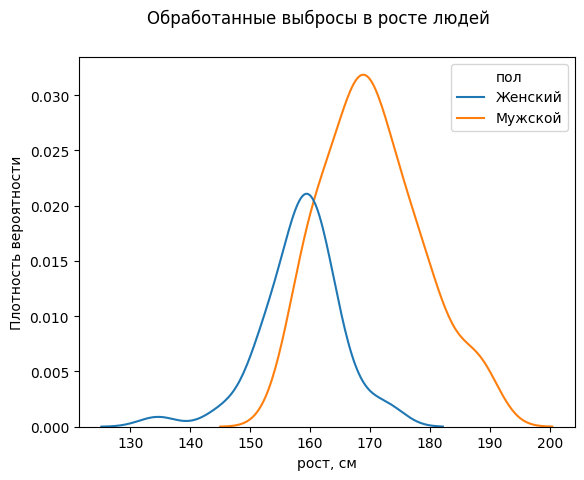

In [25]:
sns.kdeplot(data=df, x='рост', hue='пол')
plt.xlabel('рост, см')
plt.ylabel('Плотность вероятности')
plt.suptitle('Обработанные выбросы в росте людей')
plt.show();

In [26]:
# теперь всё круто!

**Доп**
> Проверю гипотезу о том, что мужчины в среднем выше женщин в любой из стран.

In [27]:
mtest = []
target = 'рост'
for country in df['страна'].unique():
    sample_1 = df[(df['страна'] == country) & (df['пол'] == 'Мужской')][target]
    sample_2 = df[(df['страна'] == country) & (df['пол'] == 'Женский')][target]

    sample_1 = sample_1.dropna()
    sample_2 = sample_2.dropna()
    p_value, method = numeric_hypothesis_test(sample_1, sample_2)
    mtest.append([country, p_value, method])

mtest.sort(key=lambda x: x[1])
mtest.insert(0, ['показатель', 'р-уровень', 'метод расчёта'])
mtest = pd.DataFrame(mtest[1:], columns=mtest[0])
display(mtest)

показатель     р-уровень метод расчёта
0        США           NaN           NaN
1  Австралия           NaN           NaN
2      Индия  3.572000e-13    Манн-Уитни

**Вывод:**
> Нет данных по Австралии и США. Однако стат разница в Индии есть.

In [28]:
df[(df['страна'] == 'Индия')].groupby('пол')['рост'].mean().round(0)

пол
Женский    158.0
Мужской    170.0
Name: рост, dtype: float64

### 1.3.3 Выбросы в скорости воздуха

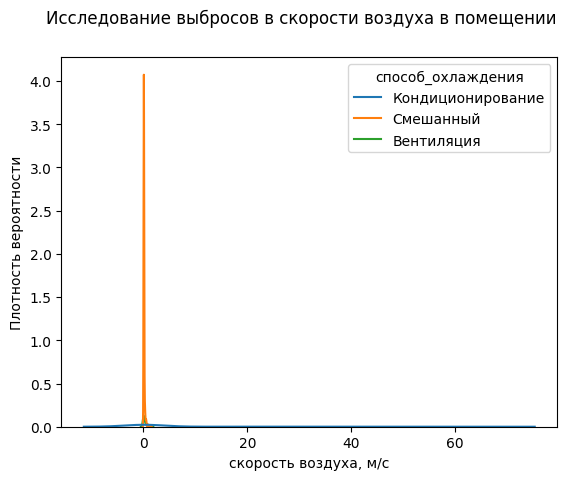

In [29]:
sns.kdeplot(data=df, x='скорость_воздуха', hue='способ_охлаждения')
plt.xlabel('скорость воздуха, м/c')
plt.ylabel('Плотность вероятности')
plt.suptitle('Исследование выбросов в скорости воздуха в помещении')
plt.show();

In [30]:
for freezer in df['способ_охлаждения'].unique():
  print('\033[1m' + freezer + '\033[0m')
  display(df[df['способ_охлаждения'] == freezer]['скорость_воздуха']
          .describe()
          .to_frame()
          .T)
  print('\n')

Кондиционирование


count  mean       std   min  25%   50%   75%    max
скорость_воздуха  114.0  2.82  9.890699  0.03  0.1  0.13  0.21  63.83



Смешанный


count      mean       std  min   25%   50%   75%   max
скорость_воздуха  335.0  0.118896  0.141077  0.0  0.06  0.09  0.12  1.42



Вентиляция


count      mean       std  min   25%   50%   75%   max
скорость_воздуха   33.0  0.204848  0.318474  0.0  0.03  0.06  0.19  1.43

In [31]:
# Замечаем жирный хвост в данных по скорости воздуха Кондиционера и другие выбросы.
# Можно было бы предложить,  что скорость воздуха системы охлаждения измерили
# в км/ч, но такие предположения слишком рискованные.
# Лучший вариант - это заменить на медианное значение скорость воздуха. Вот
# нужно понять подойдёт обычная медиана или по каждому типу охлаждения отдельно.
# Проверим гипотезу о статистической разнице систем охлаждения и скорости воздуха.
# Без учёта этих выбросов в Кондиционировании, доходящих до абсурда.

# Я бы не стал убирать выбросы в Смешанном и Вентиляции, потому что, возможно,
# cуществует некоторая техническа особенность с установленными системами.

target = 'скорость_воздуха'

group1 = 'Вентиляция'
group2 = 'Кондиционирование'

col1 = 'способ_охлаждения'
col2 = 'режим_при_смешанном_типе_охлаждения'

q1 = df[df[col1] == group2][target].quantile(0.25)
q3 = df[df[col1] == group2][target].quantile(0.75)

h = q3 - q1
index = df[~((df[target] > q3 + 3 * h) & (df[col1] == group2))].index.to_list()
temp = df.loc[index, :]

sample_1 = pd.concat(
    [temp[temp[col1] == group1][target], temp[temp[col2] == group1][target]]
    )
sample_2 = pd.concat(
    [temp[temp[col1] == group2][target], temp[temp[col2] == group2][target]]
    )

p_value, method = numeric_hypothesis_test(sample_1, sample_2)
print(f'Метод: {method}', f'p-value: {p_value}', sep='\n')

Метод: Манн-Уитни
p-value: 3.63e-05


In [32]:
# Видим, что стат разница есть, данные пришли из разных распределений

for_replace = df[(df[target] > q3 + 3 * h) & (df[col1] == group2)].index.to_list()
df.loc[for_replace, target] = df.groupby('способ_охлаждения')[target].transform('median')

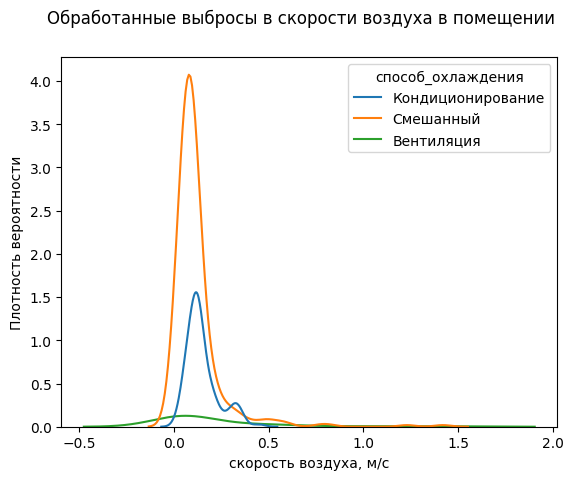

In [33]:
sns.kdeplot(data=df, x='скорость_воздуха', hue='способ_охлаждения')
plt.xlabel('скорость воздуха, м/c')
plt.ylabel('Плотность вероятности')
plt.suptitle('Обработанные выбросы в скорости воздуха в помещении')
plt.show();

In [34]:
print(np.max(sample_1))
print(np.max(sample_2))

1.43
1.42


In [35]:
# Проверим стат значимость скорости воздуха с включенным и выключенным вентилятором

sample_1 = df[df['вентилятор'] == 0]['скорость_воздуха']
sample_2 = df[df['вентилятор'] == 1]['скорость_воздуха']

p_value, method = numeric_hypothesis_test(sample_1, sample_2)
print(f'Метод: {method}', f'p-value: {p_value}', sep='\n')

Метод: Манн-Уитни
p-value: 4.053e-17


In [36]:
# Средние генеральных совокупностей отличаются
print(round(sample_1.mean(), 2))
print(round(sample_2.mean(), 2))

0.1
0.29


In [37]:
# Следовательно, выбросы имеют свою природу, а не взялись по ошибке

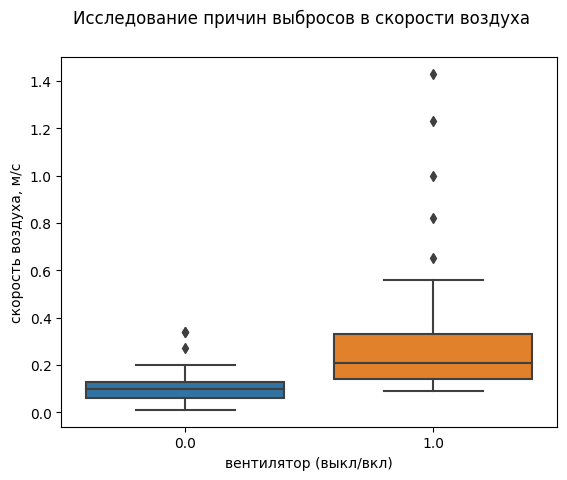

In [38]:
sns.boxplot(data=df, x='вентилятор', y='скорость_воздуха')
plt.xlabel('вентилятор (выкл/вкл)')
plt.ylabel('скорость воздуха, м/c')
plt.suptitle('Исследование причин выбросов в скорости воздуха')
plt.show();

### 1.3.4 Выбросы в утеплении

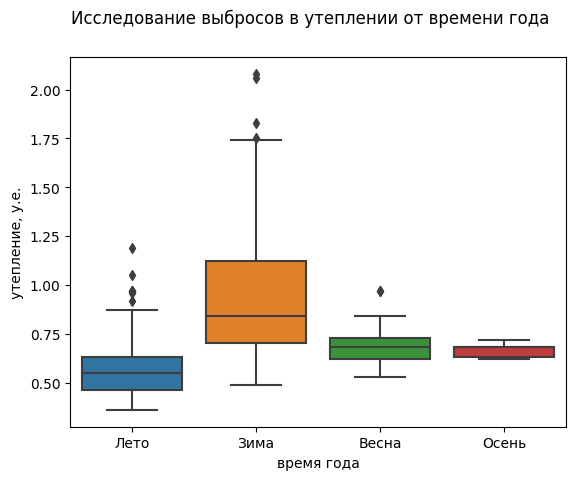

In [39]:
sns.boxplot(data=df, y='утепление', x='время_года')
plt.xlabel('время года')
plt.ylabel('утепление, у.е.')
plt.suptitle('Исследование выбросов в утеплении от времени года')
plt.show();

In [40]:
# Понятно, что люди индивидуальны, и каждому требуется свой уровень комфорта
# в том числе и в одежде. Однако эта особенность создаёт аномалии. Это
# не должно мешать нам для дальнейшего анализа, поэтому мы должны убрать
# очевидные выбросы, которые чаще не свойствены людям, проживающим в определенной
# климатической зоне
for season in df['время_года'].unique():
  for climate in df['климат'].unique():
    sample = df[(df['время_года'] == season) & (df['климат'] == climate)]['утепление']
    q1, q3 = sample.quantile(0.25), sample.quantile(0.75)
    h = q3 - q1
    index = sample[sample > q3 + 3 * h].index.to_list()
    if len(index) > 0:
      print(season)
      print(climate)
      print(len(index))
      df.loc[index, 'утепление'] = sample.median()

Лето
Жаркий полузасушливый
1
Лето
Тропическая влажная саванна
2


In [41]:
# Избавились от нескольких выбросов в утеплении Летом

### Выводы
1. Мы избавились от выбросов в данных температуры. Выяснили, что была использована не метрическая система, поэтому воспользовались формулой по переводу из Фаренгейт в градусы Цельсия. Также обработали пару ошибок ввода чисел с плавающей точкой, поделив их на 10.
2. Мы избавились от выбросов в данных роста. Выяснили, что лучше всего заменить те 2 значения на медианное значение роста человека по полу и стране.
3. Мы избавились от выбросов в данных скорости воздуха по Кондиционированию. Мы поняли, что скорость воздуха связана с типом системы охлаждения в помещении. Обработали все выбросы путём замены их на медианное значение скорости воздуха конкретной системы охлаждения.
4. Убрали выбросы в утеплении, заменив на медианное значение по сезону и климату.

## 1.4 Заполнение пропусков

Пропуски будем заполнять для каждой страны отдельно, так как природа этих пропусков может и будет отличаться.

In [42]:
df.isna().mean()

год                                            0.000000
время_года                                     0.000000
климат                                         0.000000
город                                          0.000000
страна                                         0.000000
способ_охлаждения                              0.000000
режим_при_смешанном_типе_охлаждения            0.304979
способ_обогрева                                0.539419
возраст                                        0.143154
пол                                            0.149378
ощущение_температуры                           0.000000
ощущение_температуры_(bool)                    0.000000
предпочтительное_изменение_температуры         0.000000
ощущение_движения_воздуха_(bool)               0.589212
предпочтительное_изменение_движения_воздуха    0.000000
оценка_комфорта                                0.553942
утепление                                      0.000000
температура_воздуха_в_помещении                0

In [43]:
# Создадим разные датасеты для стран, так как мы выяснили,
# что эти группы независимы.
# Данные будем конкатенировать в конце после всей обработки и анализа.
df_au = df[df['страна'] == 'Австралия'].copy()
df_us = df[df['страна'] == 'США'].copy()
df_in = df[df['страна'] == 'Индия'].copy()

### 1.4.1 Пропуски в отоплении

Будем опираться на условие о жаркой погоде. В жаркую летнюю погоду никто не будет включать отопление, если у нас нет информации о других возможных случаях.

**Доп**
> По сути нам не нужно знать про механическое отопление летом, так как эта информация нам будет только мешать. Заменим на Na. Аналогично для способа охлаждения сделаем зимой, когда включено отопление, так как это тоже мешающая для анализа данных лишняя информация.

In [44]:
target = 'отопление'

**Австралия**

In [45]:
df_au[target].isna().mean()

1.0

In [46]:
df_au[['город', 'климат']].value_counts(normalize=True)

город   климат                     
Сидней  Cубтропический океанический    1.0
dtype: float64

In [47]:
temp = df_au.groupby(['время_года', target], dropna=False).size()
temp = temp.to_frame()
display(temp)

0
время_года отопление     
Лето       NaN        198

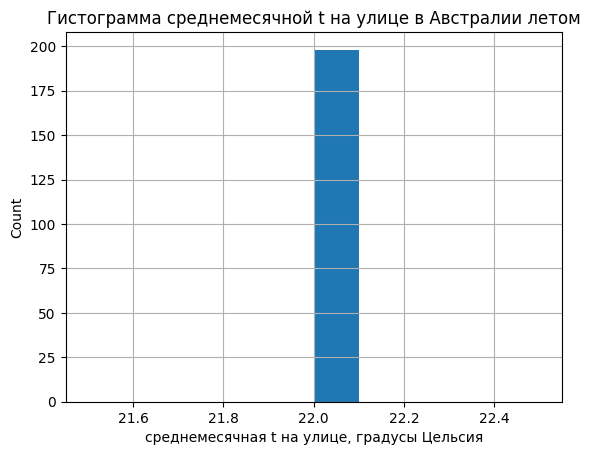

In [48]:
df_au['среднемесячная_температура_на_улице'].hist()
plt.xlabel('среднемесячная t на улице, градусы Цельсия')
plt.ylabel('Count')
plt.title('Гистограмма среднемесячной t на улице в Австралии летом')
plt.show();

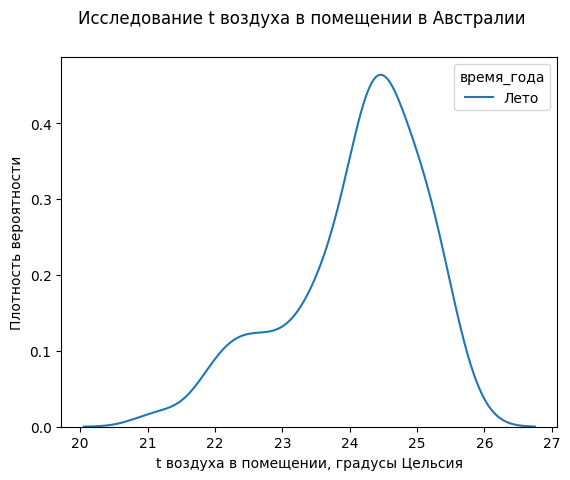

In [49]:
sns.kdeplot(data=df_au, x='температура_воздуха_в_помещении', hue='время_года')
plt.xlabel('t воздуха в помещении, градусы Цельсия')
plt.ylabel('Плотность вероятности')
plt.suptitle('Исследование t воздуха в помещении в Австралии')
plt.show();

In [50]:
# Цитата из интернета: "В Австралии отсутствует система центрального отопления.
# Даже в холодные месяцы на улице бывает теплее, чем в помещении."

# Отсюда делаем вывод, что отопление можно заполнить 0, потому что в 22 градуса
# летом в таком-то климате никто не будет включать отопление.

df_au[target] = df_au[target].fillna(0)

**США**

In [51]:
df_us[target].isna().mean()

1.0

In [52]:
df_us[['город', 'климат']].value_counts(normalize=True)

город  климат                     
Техас  Cубтропический океанический    1.0
dtype: float64

In [53]:
temp = df_us.groupby(['время_года', target], dropna=False).size()
temp = temp.to_frame()
display(temp)

0
время_года отопление    
Лето       NaN        72

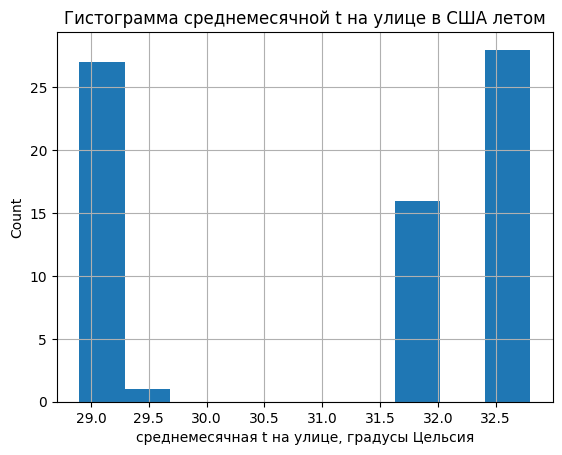

In [54]:
df_us['среднемесячная_температура_на_улице'].hist()
plt.xlabel('среднемесячная t на улице, градусы Цельсия')
plt.ylabel('Count')
plt.title('Гистограмма среднемесячной t на улице в США летом')
plt.show();

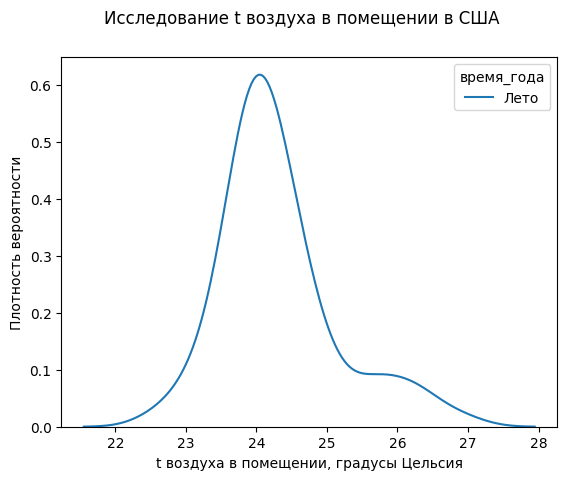

In [55]:
sns.kdeplot(data=df_us, x='температура_воздуха_в_помещении', hue='время_года')
plt.xlabel('t воздуха в помещении, градусы Цельсия')
plt.ylabel('Плотность вероятности')
plt.suptitle('Исследование t воздуха в помещении в США')
plt.show();

In [56]:
# Ссылаемся на условие о том, что

# Способ обогрева:
# - NA = отсутствие механического отопления, неизвестно или
# исследование только в жаркую летнюю погоду.

# Здесь у нас точно жаркая летняя погода => заполняем 0 отопление

df_us[target] = df_us[target].fillna(0)

**Индия**

In [57]:
df_in[target].isna().mean()

0.6273584905660378

In [58]:
df_in[['город', 'климат']].value_counts(normalize=True)

город       климат                          
Ченнай      Тропическая влажная саванна         0.240566
Ахмедабад   Жаркий полузасушливый               0.179245
Дели        Влажный субтропический муссонный    0.165094
Шимла       Субтропическое высокогорье          0.150943
Хайдарабад  Жаркий полузасушливый               0.141509
Бангалор    Тропическая влажная саванна         0.122642
dtype: float64

In [59]:
df_in.corr(method='spearman')[target].sort_values()

окно                                  -0.449537
температура_воздуха_в_помещении       -0.373621
возраст                               -0.371307
ощущение_температуры                  -0.151127
вентилятор                            -0.107541
rh                                    -0.046603
ощущение_температуры_(bool)           -0.032661
скорость_воздуха                      -0.002030
количество_рекламаций                  0.095532
среднемесячная_температура_на_улице    0.131966
вес                                    0.174473
рост                                   0.193719
утепление                              0.222007
оценка_комфорта                        0.333208
отопление                              1.000000
ощущение_движения_воздуха_(bool)            NaN
температура_воздуха_на_улице                NaN
занавески                                   NaN
двери                                       NaN
Name: отопление, dtype: float64

In [60]:
df_in.groupby(['время_года', 'климат', target], dropna=False).agg(
    {'среднемесячная_температура_на_улице' : ['min'],
     'температура_воздуха_в_помещении' : ['median'],
     target: ['size']})

среднемесячная_температура_на_улице  \
                                                                                      min   
время_года климат                           отопление                                       
Весна      Жаркий полузасушливый            NaN                                      31.5   
           Тропическая влажная саванна      NaN                                      30.4   
Зима       Влажный субтропический муссонный 0.0                                      15.5   
                                            1.0                                      15.5   
                                            NaN                                      15.5   
           Жаркий полузасушливый            0.0                                      21.3   
                                            1.0                                      21.3   
                                            NaN                                      21.3   
           Субтропическое высокогорье       NaN                                       8.5   
           Тропическая влажная саванна      0.0                                      29.9   
                                            1.0                                      29.9   
                                            NaN                                      29.9   
Лето       Влажный субтропический муссонный 0.0                                      30.9   
                                            1.0                                      30.9   
                                            NaN                                      30.9   
           Жаркий полузасушливый            0.0                                      29.5   
                                            1.0                                      29.5   
                                            NaN                                      27.0   
           Субтропическое высокогорье       0.0                                      18.5   
                                            NaN                                      18.5   
           Тропическая влажная саванна      0.0                                      30.8   
                                            1.0                                      30.8   
                                            NaN                                      30.8   
Осень      Жаркий полузасушливый            NaN                                      25.7   
           Тропическая влажная саванна      NaN                                      29.7   

                                                      температура_воздуха_в_помещении  \
                                                                               median   
время_года климат                           отопление                                   
Весна      Жаркий полузасушливый            NaN                                 27.90   
           Тропическая влажная саванна      NaN                                 26.60   
Зима       Влажный субтропический муссонный 0.0                                 25.30   
                                            1.0                                 23.80   
                                            NaN                                 18.30   
           Жаркий полузасушливый            0.0                                 26.85   
                                            1.0                                 25.30   
                                            NaN                                 27.20   
           Субтропическое высокогорье       NaN                                 20.20   
           Тропическая влажная саванна      0.0                                 28.05   
                                            1.0                                 25.90   
                                            NaN                                 26.60   
Лето       Влажный субтропический муссонный 0.0                                 34.60   
                         

In [61]:
target = 'отопление'

df_in.loc[(df_in['время_года'] == 'Весна'), target] = 0

df_in.loc[(df_in['время_года'] == 'Зима') &
          (df_in['время_года'] == 'Влажный субтропический муссонный') &
          (df_in[target].isnull()), target] = 1

df_in.loc[(df_in['время_года'] == 'Зима') &
          (df_in['климат'] == 'Жаркий полузасушливый') &
          (df_in[target].isnull()), target] = 0

df_in.loc[(df_in['время_года'] == 'Зима') &
          (df_in['климат'] == 'Влажный субтропический муссонный') &
          (df_in[target].isnull()), target] = 1

df_in.loc[(df_in['время_года'] == 'Зима') &
          (df_in['климат'] == 'Субтропическое высокогорье') &
          (df_in[target].isnull()), target] = 1

df_in.loc[(df_in['время_года'] == 'Зима') &
          (df_in['климат'] == 'Тропическая влажная саванна') &
          (df_in[target].isnull()), target] = 0

df_in.loc[(df_in['время_года'] == 'Лето') &
          (df_in['климат'] == 'Влажный субтропический муссонный') &
          (df_in[target].isnull()), target] = 0

df_in.loc[(df_in['время_года'] == 'Лето') &
          (df_in['климат'] == 'Жаркий полузасушливый') &
          (df_in[target].isnull()), target] = 0

df_in.loc[(df_in['время_года'] == 'Лето') &
          (df_in['климат'] == 'Субтропическое высокогорье') &
          (df_in[target].isnull()), target] = 0

df_in.loc[(df_in['время_года'] == 'Лето') &
          (df_in['климат'] == 'Тропическая влажная саванна') &
          (df_in[target].isnull()), target] = 0

df_in.loc[(df_in['время_года'] == 'Осень') &
          (df_in['климат'] == 'Жаркий полузасушливый') &
          (df_in[target].isnull()), target] = 0

df_in.loc[(df_in['время_года'] == 'Осень') &
          (df_in['климат'] == 'Тропическая влажная саванна') &
          (df_in[target].isnull()), target] = 0

In [62]:
df_in.groupby(['время_года', 'климат', target], dropna=False).agg(
    {'среднемесячная_температура_на_улице' : ['min'],
     'температура_воздуха_в_помещении' : ['median'],
     target: ['size']})

среднемесячная_температура_на_улице  \
                                                                                      min   
время_года климат                           отопление                                       
Весна      Жаркий полузасушливый            0.0                                      31.5   
           Тропическая влажная саванна      0.0                                      30.4   
Зима       Влажный субтропический муссонный 0.0                                      15.5   
                                            1.0                                      15.5   
           Жаркий полузасушливый            0.0                                      21.3   
                                            1.0                                      21.3   
           Субтропическое высокогорье       1.0                                       8.5   
           Тропическая влажная саванна      0.0                                      29.9   
                                            1.0                                      29.9   
Лето       Влажный субтропический муссонный 0.0                                      30.9   
                                            1.0                                      30.9   
           Жаркий полузасушливый            0.0                                      27.0   
                                            1.0                                      29.5   
           Субтропическое высокогорье       0.0                                      18.5   
           Тропическая влажная саванна      0.0                                      30.8   
                                            1.0                                      30.8   
Осень      Жаркий полузасушливый            0.0                                      25.7   
           Тропическая влажная саванна      0.0                                      29.7   

                                                      температура_воздуха_в_помещении  \
                                                                               median   
время_года климат                           отопление                                   
Весна      Жаркий полузасушливый            0.0                                 27.90   
           Тропическая влажная саванна      0.0                                 26.60   
Зима       Влажный субтропический муссонный 0.0                                 25.30   
                                            1.0                                 22.85   
           Жаркий полузасушливый            0.0                                 26.90   
                                            1.0                                 25.30   
           Субтропическое высокогорье       1.0                                 20.20   
           Тропическая влажная саванна      0.0                                 26.70   
                                            1.0                                 25.90   
Лето       Влажный субтропический муссонный 0.0                                 35.80   
                                            1.0                                 24.40   
           Жаркий полузасушливый            0.0                                 29.40   
                                            1.0                                 25.50   
           Субтропическое высокогорье       0.0                                 22.40   
           Тропическая влажная саванна      0.0                                 27.30   
                                            1.0                                 25.30   
Осень      Жаркий полузасушливый            0.0                                 28.10   
           Тропическая влажная саванна      0.0                                 26.20   

                                                      отопление  
                                                           size  
время_года климат                           отопление            
Весна      Жаркий полузасушливый

In [63]:
df_in['время_года'].value_counts()

Лето     102
Зима      79
Весна     18
Осень     13
Name: время_года, dtype: int64

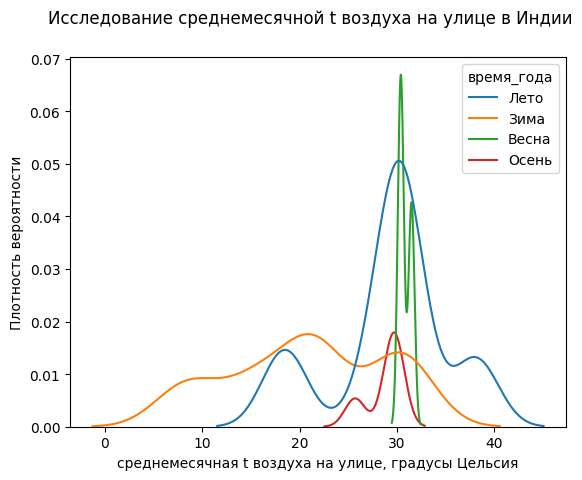

In [64]:
sns.kdeplot(data=df_in, x='среднемесячная_температура_на_улице', hue='время_года')
plt.xlabel('среднемесячная t воздуха на улице, градусы Цельсия')
plt.ylabel('Плотность вероятности')
plt.suptitle('Исследование среднемесячной t воздуха на улице в Индии')
plt.show();

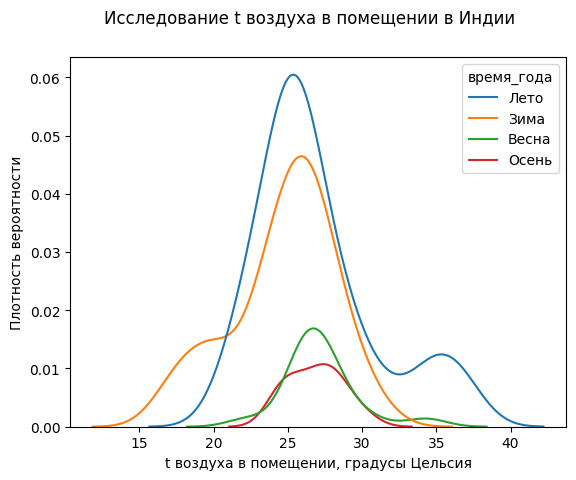

In [65]:
sns.kdeplot(data=df_in, x='температура_воздуха_в_помещении', hue='время_года')
plt.xlabel('t воздуха в помещении, градусы Цельсия')
plt.ylabel('Плотность вероятности')
plt.suptitle('Исследование t воздуха в помещении в Индии')
plt.show();

In [66]:
df_in.loc[df_in[target] == 0, 'способ_обогрева'] = 'Не используется'
df_in.loc[df_in['способ_обогрева'].isna(), 'способ_обогрева'] = 'unknown'

### 1.4.2 Пропуски в способе обогрева

In [67]:
target = 'способ_обогрева'

**Австралия**

In [68]:
df_au.loc[df_au['отопление'] == 0, target] = 'Не используется'
df_au[target + '_nan'] = 0
df_au.loc[df_au[target].isna(), target + '_nan'] = 1
df_au.loc[df_au[target].isna(), target] = 'unknown'

**США**

In [69]:
df_us.loc[df_us['отопление'] == 0, target] = 'Не используется'
df_us[target + '_nan'] = 0
df_us.loc[df_us[target].isna(), target + '_nan'] = 1
df_us.loc[df_us[target].isna(), target] = 'unknown'

**Индия**

In [70]:
df_in.loc[df_in['отопление'] == 0, target] = 'Не используется'
df_in[target + '_nan'] = 0
df_in.loc[df_in[target].isna(), target + '_nan'] = 1
df_in.loc[df_in[target].isna(), target] = 'unknown'

### 1.4.3 Пропуски в возрасте

Попробуем найти корреляцию, по которой однозначно можно определить возраст.

In [71]:
target = 'возраст'

**Австралия**

In [72]:
df_au[target].isna().mean()

0.0

**США**

In [73]:
df_us[target].isna().mean()

0.0

**Индия**

In [74]:
df_in[target].isna().mean()

0.32547169811320753

In [75]:
df_in['возраст'] = df_in.groupby(['город'])['возраст'].transform(
    lambda x: x.fillna(x.mean())
    )
df_in['возраст'] = df_in['возраст'].fillna(df_in['возраст'].median())

In [76]:
df_in['возраст'].isna().mean()

0.0

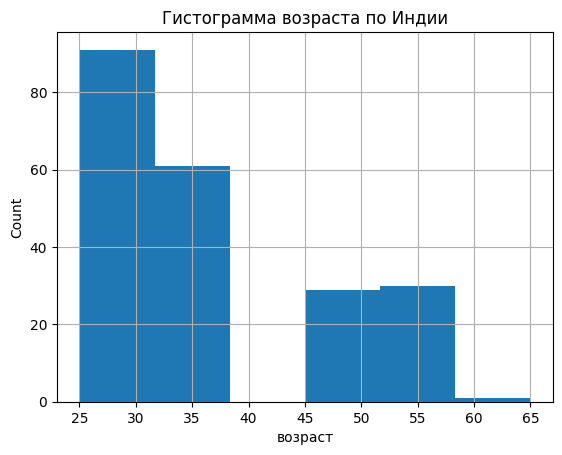

In [77]:
df_in['возраст'].hist(bins=6)
plt.xlabel('возраст')
plt.ylabel('Count')
plt.title('Гистограмма возраста по Индии')
plt.show();

### 1.4.4 Пропуски в поле

In [78]:
target = 'пол'

**Австралия**

In [79]:
df_au[target].isna().mean()

0.0

**США**

In [80]:
df_us[target].isna().mean()

1.0

In [81]:
# Нет данных по США

**Индия**

In [82]:
df_in[target].isna().mean()

0.0

### 1.4.5 Пропуски в ощущении движения воздуха (bool)

Будем заполнять пропуски, основываясь на предпочтительном изменении движения воздуха.

In [83]:
target = 'ощущение_движения_воздуха_(bool)'

**Австралия**

In [84]:
df_au[target].isna().mean()

0.0

**США**

In [85]:
df_us[target].isna().mean()

1.0

In [86]:
# Нет никаких данных по ощущению движения воздуха (bool) в США.
# Однако заполнить это возможно. Нужно посмотреть на то, хотят ли
# клиенты, чтобы движения воздуха изменилось. Если да, то заполним 0,
# если нет - 1 (устраивает).

col = 'предпочтительное_изменение_движения_воздуха'
df_us[target] = df_us[col].apply(
    lambda x: 1 if x == 'Без изменений' else 0
)

In [87]:
df_us[target].value_counts()

1    40
0    32
Name: ощущение_движения_воздуха_(bool), dtype: int64

In [88]:
# Можно проверить на примере Австралии, что это будет верно

corr, p_value = crammer_and_pvalue(df_au, target, col)

In [89]:
print(f'Корреляция: {corr}', f'p-value: {p_value}', sep='\n')

Корреляция: 0.91
p-value: 2.4070000000000004e-36


In [90]:
# Видим очень сильную взаимосвязь между этими факторами, причём этому выводу.
# можно доверять. Так как корреляция Краммера не показывает положительная связь
# или отрицательная, то сделаем groupby

t = df_au.groupby(col)[target].agg(['mean', 'count']).reset_index()
display(t)

предпочтительное_изменение_движения_воздуха      mean  count
0                               Без изменений  0.993056    144
1                                      Больше  0.111111     45
2                                      Меньше  0.111111      9

In [91]:
# Наблюдаем, что только каждый 9, кто хотел бы изменить движения воздуха всё
# равно считают приемлемым движения воздуха, которое есть сейчас. И более 99%,
# кто не хотел бы ничего менять в движении воздуха, всем довольны. Если "без
# изменений" мы сделали правильно, то вот вероятность того, что все 32 человека
# остались недовольны в США по схеме Бернулли равна все лишь 2%, если судить по
# полученным из Австралии вероятностям (они же mean). Поэтому воспользуемся
# биномиальным распределением, чтобы повысить достоверность данных.

In [92]:
index = df_us[df_us[col] != 'Без изменений'].index.to_list()
df_us.loc[index, target] = np.random.binomial(1, 1 / 9, size=len(index))

In [93]:
df_us[target].value_counts()

1    42
0    30
Name: ощущение_движения_воздуха_(bool), dtype: int64

In [94]:
df_us[target].isna().mean()

0.0

**Индия**

In [95]:
df_in[target].isna().mean()

1.0

In [96]:
# Нет никаких данных по ощущению движения воздуха (bool) в Индии.
# Поступаем аналогично, как и в случае с США.

In [97]:
df_in[target] = df_in[col].apply(lambda x: 1 if x == 'Без изменений' else 0)
index = df_in[df_in[col] != 'Без изменений'].index.to_list()
df_in.loc[index, target] = np.random.binomial(1, 1 / 9, size=len(index))

In [98]:
df_in[target].value_counts()

1    113
0     99
Name: ощущение_движения_воздуха_(bool), dtype: int64

In [99]:
df_in[target].isna().mean()

0.0

### 1.4.6 Пропуски в температуре воздуха на улице

Везде, где есть пропуски в температуре воздуха на улице, будем заменять на среднемесячную температуру в данном городе и сезоне.

In [100]:
target = 'температура_воздуха_на_улице'

**Австралия**

In [101]:
df_au[target].isna().mean()

1.0

In [102]:
# Нет никаких данных по температура на улице

In [103]:
df_au[['город', 'время_года']].value_counts(normalize=True)

город   время_года
Сидней  Лето          1.0
dtype: float64

In [104]:
# Так как по Австралии есть данные только по одному городу и только одному
# сезону, то подставляем полностью среднемесячную температуру на улице

df_au[target] = df_au['среднемесячная_температура_на_улице'].mean()

In [105]:
df_au[target].isna().mean()

0.0

**США**

In [106]:
df_us[target].isna().mean()

0.0

**Индия**

In [107]:
df_in[target].isna().mean()

1.0

In [108]:
df_in[['город', 'время_года']].value_counts(normalize=True)

город       время_года
Ахмедабад   Лето          0.122642
Дели        Лето          0.099057
Шимла       Лето          0.084906
Бангалор    Лето          0.075472
Ченнай      Лето          0.075472
Хайдарабад  Зима          0.070755
Дели        Зима          0.066038
Ченнай      Зима          0.066038
Шимла       Зима          0.066038
Ахмедабад   Зима          0.056604
Ченнай      Весна         0.051887
Бангалор    Зима          0.047170
Ченнай      Осень         0.047170
Хайдарабад  Весна         0.033019
            Лето          0.023585
            Осень         0.014151
dtype: float64

In [109]:
df_in[target] = df_in.groupby(['город', 'время_года'])['среднемесячная_температура_на_улице'].transform('mean')

In [110]:
df_in[target].isna().mean()

0.0

In [111]:
# Теперь данные по Индии заполнены.

### 1.4.7 Пропуски в росте и весе

In [112]:
target = ['рост', 'вес']

**Австралия**

In [113]:
df_au[target].isna().mean()

рост    1.0
вес     1.0
dtype: float64

In [114]:
# Данных по росту и весу в Австралии нет.

**США**

In [115]:
df_us[target].isna().mean()

рост    1.0
вес     1.0
dtype: float64

In [116]:
# Данных по росту и весу в США нет.

**Индия**

In [117]:
df_in[target].isna().mean()

рост    0.325472
вес     0.000000
dtype: float64

In [118]:
# Есть пропуски в данных по росту в Индии.

In [119]:
# Мы знаем, что в среднем девушки на 10 см ниже мужчин.
# Поэтому попробуем заменить, где это возможно, пропуски в росте
# на медианный рост по половому признаку в Индии.

df_in['рост'] = df_in.groupby('пол')['рост'].transform(lambda x: x.fillna(x.median()))

In [120]:
df_in[target].isna().mean()

рост    0.0
вес     0.0
dtype: float64

In [121]:
# Теперь данные по Индии заполнены.

### 1.4.8 Пропуски в занавесках, вентиляторах, окнах, дверях

In [122]:
target = ['занавески', 'вентилятор', 'окно', 'двери']

In [123]:
# Отследим корреляцию между факторами
result = []
for i, target_1 in enumerate(target[:-1]):
  for target_2 in target[i + 1:]:
    corr, p_value = crammer_and_pvalue(df, target_1, target_2)
    result.append([f'{target_1}_{target_2}', corr, p_value])
result = list(zip(*result))

result = pd.DataFrame(
    {'Колонки': result[0],
     'Корреляция': result[1],
     'p-value': result[2]}
    ).sort_values(by='p-value').reset_index(drop=True)
display(result)

Колонки  Корреляция       p-value
0  занавески_вентилятор        0.97  1.592000e-16
1            окно_двери        0.39  1.294000e-06
2       вентилятор_окно        0.28  5.914000e-02
3        занавески_окно         NaN           NaN
4       занавески_двери         NaN           NaN
5      вентилятор_двери         NaN           NaN

**Занавески**

In [124]:
# Данные по занавескам и вентилятору идеально коррелируют друг с другом
# Есть очень сильная связь занавесок и вентилятора.

df.groupby('занавески')['вентилятор'].mean()

занавески
0.0    0.0
1.0    1.0
Name: вентилятор, dtype: float64

In [125]:
# Если занавески открыты, то вентилятор человеку не нужен и наоборот.
# Если занавески закрывают окно, то значит, нужен вентилятор, т.к. человеку,
# скорее всего, душно. Проверим гипотезу о том, почему окна завешиваются, потому
# что человеку душно (по ощущению температуры)

sample_1 = df_us[df_us['занавески'] == 0]['ощущение_температуры']
sample_2 = df_us[df_us['занавески'] == 1]['ощущение_температуры']

p_value, method = numeric_hypothesis_test(sample_1, sample_2)
print(f'Метод: {method}', f'p-value: {p_value}', sep='\n')

Метод: Манн-Уитни
p-value: 0.4431


In [126]:
# Текущих данных не хватает, чтобы сделать вывод о различии средних.

**Вентилятор**

In [127]:
result = []
for col in df.select_dtypes(include='float64').columns:
  temp = df[(~df['вентилятор'].isnull()) & (~df[col].isnull())].copy().reset_index(drop=True)
  corr = correlation_ratio(temp['вентилятор'], temp[col])
  result.append([f'вентилятор_{col}', corr])
result = list(zip(*result))

result = pd.DataFrame(
    {'Колонки': result[0],
     'Корреляция': result[1]}
    ).sort_values(by='Корреляция', ascending=False).reset_index(drop=True)
display(result)

Колонки  Корреляция
0                             вентилятор_занавески        1.00
1                            вентилятор_вентилятор        1.00
2                      вентилятор_скорость_воздуха        0.48
3          вентилятор_температура_воздуха_на_улице        0.37
4       вентилятор_температура_воздуха_в_помещении        0.36
5                                  вентилятор_окно        0.32
6   вентилятор_среднемесячная_температура_на_улице        0.29
7                             вентилятор_утепление        0.28
8                                    вентилятор_rh        0.27
9                       вентилятор_оценка_комфорта        0.23
10                 вентилятор_ощущение_температуры        0.22
11          вентилятор_ощущение_температуры_(bool)        0.11
12                            вентилятор_отопление        0.11
13                                 вентилятор_рост        0.05
14                                  вентилятор_вес        0.04
15                              вентилятор_возраст        0.02
16     вентилятор_ощущение_движения_воздуха_(bool)         NaN
17                                вентилятор_двери         NaN

In [128]:
# Наиболее интересные связи это вентилятор_скорость_воздуха	, вентилятор_температура_воздуха_на_улице,
# вентилятор_температура_воздуха_в_помещении, вентилятор_окно, вентилятор_утепление	и вентилятор_rh
df.groupby('вентилятор')[['скорость_воздуха', 'температура_воздуха_на_улице',
                          'температура_воздуха_в_помещении', 'окно',
                          'утепление', 'rh']].mean().round(2)

скорость_воздуха  температура_воздуха_на_улице  \
вентилятор                                                   
0.0                     0.10                         24.33   
1.0                     0.29                         23.89   

            температура_воздуха_в_помещении  окно  утепление     rh  
вентилятор                                                           
0.0                                   24.47  0.17       0.72  42.80  
1.0                                   27.15  0.48       0.62  49.57

**Окно**

In [129]:
result = []
for col in df.select_dtypes(include='float64').columns:
  temp = df[(~df['окно'].isnull()) & (~df[col].isnull())].copy().reset_index(drop=True)
  corr = correlation_ratio(temp['окно'], temp[col])
  result.append([f'окно_{col}', corr])
result = list(zip(*result))

result = pd.DataFrame(
    {'Колонки': result[0],
     'Корреляция': result[1]}
    ).sort_values(by='Корреляция', ascending=False).reset_index(drop=True)
display(result)

Колонки  Корреляция
0                                  окно_окно        1.00
1                             окно_отопление        0.45
2                                 окно_двери        0.42
3                            окно_вентилятор        0.32
4                             окно_утепление        0.23
5                                    окно_rh        0.19
6       окно_температура_воздуха_в_помещении        0.15
7                      окно_скорость_воздуха        0.15
8                                   окно_вес        0.13
9                               окно_возраст        0.11
10                 окно_ощущение_температуры        0.09
11                                 окно_рост        0.09
12                      окно_оценка_комфорта        0.04
13  окно_среднемесячная_температура_на_улице        0.03
14          окно_ощущение_температуры_(bool)        0.02
15     окно_ощущение_движения_воздуха_(bool)        0.02
16         окно_температура_воздуха_на_улице         NaN
17                            окно_занавески         NaN

In [130]:
# Наиболее интересные связи это окно_отопление, окно_двери, окно_вентилятор,
# окно_утепление
df.groupby('окно')[['отопление', 'двери',
                     'вентилятор', 'утепление']].mean().round(2)

отопление  двери  вентилятор  утепление
окно                                         
0.0        0.71   0.12        0.39       0.70
1.0        0.14   0.67        0.73       0.55

**Двери**

In [131]:
# Больше всего вопросов возникает с дверьми. С чем они могут быть связаны ещё?
result = []
for col in df.select_dtypes(include='float64').columns:
  temp = df[(~df['двери'].isnull()) & (~df[col].isnull())].copy().reset_index(drop=True)
  corr = correlation_ratio(temp['двери'], temp[col])
  result.append([f'двери_{col}', corr])
result = list(zip(*result))

result = pd.DataFrame(
    {'Колонки': result[0],
     'Корреляция': result[1]}
    ).sort_values(by='Корреляция', ascending=False).reset_index(drop=True)
display(result)

Колонки  Корреляция
0                                 двери_двери        1.00
1                                  двери_окно        0.42
2       двери_температура_воздуха_в_помещении        0.39
3                                    двери_rh        0.25
4                                   двери_вес        0.25
5      двери_ощущение_движения_воздуха_(bool)        0.21
6                             двери_утепление        0.14
7   двери_среднемесячная_температура_на_улице        0.11
8                               двери_возраст        0.07
9                  двери_ощущение_температуры        0.05
10                     двери_скорость_воздуха        0.03
11          двери_ощущение_температуры_(bool)        0.00
12                      двери_оценка_комфорта         NaN
13         двери_температура_воздуха_на_улице         NaN
14                                 двери_рост         NaN
15                            двери_занавески         NaN
16                           двери_вентилятор         NaN
17                            двери_отопление         NaN

In [132]:
# Наиболее интересные связи это двери_окно, двери_температура_воздуха_в_помещении,
# двери_rh
df.groupby('двери')[['окно', 'температура_воздуха_в_помещении', 'rh']].mean().round(2)

окно  температура_воздуха_в_помещении     rh
двери                                              
0.0    0.04                            25.07  56.43
1.0    0.37                            27.27  49.36

**Австралия**

In [133]:
df_au[target].isna().mean()

занавески     1.000000
вентилятор    1.000000
окно          0.414141
двери         0.565657
dtype: float64

In [134]:
# Данных по занавескам, вентиляторам в Австралии нет.

In [135]:
# Разберёмся с условием по системе охлаждения.

# Способ охлаждения:
# - Кондиционирование = может быть разных типов, окна закрыты.
# - Вентиляция = механические системы вентиляции и естественное охлаждение.
# - Смешанный = механическое охлаждение и окна открыты.
# - NA = неприменимо, например исследование холодной зимой, когда включено отопление.

df_au['способ_охлаждения'].value_counts(normalize=True)

Смешанный    1.0
Name: способ_охлаждения, dtype: float64

In [136]:
df_au.loc[df_au['способ_охлаждения']
          == 'Кондиционирование', 'окно'] = 1

df_au.loc[df_au['режим_при_смешанном_типе_охлаждения']
          == 'Кондиционирование', 'окно'] = 1

df_au['занавески'] = df_au['вентилятор']

In [137]:
df_au[target].isna().mean()

занавески     1.000000
вентилятор    1.000000
окно          0.101010
двери         0.565657
dtype: float64

**США**

In [138]:
df_us[target].isna().mean()

занавески     0.0
вентилятор    0.0
окно          1.0
двери         1.0
dtype: float64

In [139]:
# Нет информации по окнам и дверям. Окна мы можем заполнить.

df_us['способ_охлаждения'].value_counts(normalize=True)

Кондиционирование    1.0
Name: способ_охлаждения, dtype: float64

In [140]:
# Окна точно будут закрыты.

df_us['окно'] = 1

In [141]:
df_us[target].isna().mean()

занавески     0.0
вентилятор    0.0
окно          0.0
двери         1.0
dtype: float64

**Индия**

In [142]:
df_in[target].isna().mean()

занавески     1.000000
вентилятор    0.650943
окно          0.240566
двери         0.674528
dtype: float64

In [143]:
# Занавески можем заполнить, исходя из данных по вентилятору. Окно - исходя из
# системы охлаждения.

df_in['способ_охлаждения'].value_counts(normalize=True)

Смешанный            0.646226
Кондиционирование    0.198113
Вентиляция           0.155660
Name: способ_охлаждения, dtype: float64

In [144]:
for_replace = df_in[(df_in['способ_охлаждения'] == 'Кондиционирование') |
                     (df_in['режим_при_смешанном_типе_охлаждения']
                      == 'Кондиционирование')].index.to_list()
df_in.loc[for_replace, 'окно'] = 1
df_in['занавески'] = df_in['вентилятор']

In [145]:
df_in[target].isna().mean()

занавески     0.650943
вентилятор    0.650943
окно          0.042453
двери         0.674528
dtype: float64

In [146]:
# Насколько получилось заполнить, то заполнили

### 1.4.9 Пропуски в оценках комфорта

Предлагается вариант использования модели линейной регрессии для оценки комфорта клиента или Случайного леса



In [147]:
target = 'оценка_комфорта'

**Австралия**

In [148]:
df_au[target].isna().mean()

1.0

In [149]:
# Нет данных по Австралии.

**США**

In [150]:
df_us[target].isna().mean()

0.0

**Индия**

In [151]:
df_in[target].isna().mean()

0.32547169811320753

In [152]:
# В Индии 1/3 данных пропуски.

**Заполнение данных**

In [153]:
tmp = pd.concat([df_us, df_au, df_in])
tmp = tmp.dropna(subset=['оценка_комфорта'], axis=0)
tmp = tmp[tmp['отопление'] == 0]

In [154]:
tmp[tmp.select_dtypes(include='float64').columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134 entries, 0 to 479
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   возраст                              134 non-null    float64
 1   ощущение_температуры                 134 non-null    float64
 2   ощущение_температуры_(bool)          134 non-null    float64
 3   ощущение_движения_воздуха_(bool)     134 non-null    float64
 4   оценка_комфорта                      134 non-null    float64
 5   утепление                            134 non-null    float64
 6   температура_воздуха_в_помещении      134 non-null    float64
 7   температура_воздуха_на_улице         134 non-null    float64
 8   rh                                   134 non-null    float64
 9   скорость_воздуха                     134 non-null    float64
 10  рост                                 62 non-null     float64
 11  вес                             

In [155]:
numeric_columns = tmp.select_dtypes(include='float64').columns
corr = temp[numeric_columns].corr(method='spearman')
corr = corr[abs(corr) > 0.25]
corr = corr.dropna(thresh=2, axis=0)
corr = corr.dropna(how='all', axis=1)
display(corr)

ощущение_температуры  \
ощущение_температуры                             1.000000   
ощущение_температуры_(bool)                     -0.327859   
ощущение_движения_воздуха_(bool)                -0.320406   
утепление                                             NaN   
температура_воздуха_в_помещении                       NaN   
rh                                                    NaN   
окно                                                  NaN   
двери                                                 NaN   
среднемесячная_температура_на_улице                   NaN   

                                     ощущение_температуры_(bool)  \
ощущение_температуры                                   -0.327859   
ощущение_температуры_(bool)                             1.000000   
ощущение_движения_воздуха_(bool)                        0.442624   
утепление                                                    NaN   
температура_воздуха_в_помещении                              NaN   
rh                                                           NaN   
окно                                                         NaN   
двери                                                        NaN   
среднемесячная_температура_на_улице                          NaN   

                                     ощущение_движения_воздуха_(bool)  \
ощущение_температуры                                        -0.320406   
ощущение_температуры_(bool)                                  0.442624   
ощущение_движения_воздуха_(bool)                             1.000000   
утепление                                                         NaN   
температура_воздуха_в_помещении                                   NaN   
rh                                                                NaN   
окно                                                              NaN   
двери                                                             NaN   
среднемесячная_температура_на_улице                               NaN   

                                     утепление  \
ощущение_температуры                       NaN   
ощущение_температуры_(bool)                NaN   
ощущение_движения_воздуха_(bool)           NaN   
утепление                             1.000000   
температура_воздуха_в_помещении       0.599067   
rh                                   -0.533456   
окно                                       NaN   
двери                                      NaN   
среднемесячная_температура_на_улице   0.446308   

                                     температура_воздуха_в_помещении  \
ощущение_температуры                                             NaN   
ощущение_температуры_(bool)                                      NaN   
ощущение_движения_воздуха_(bool)                                 NaN   
утепление                                                   0.599067   
температура_воздуха_в_помещении                             1.000000   
rh                                                         -0.496531   
окно                                                             NaN   
двери                                                       0.326005   
среднемесячная_температура_на_улице                         0.307540   

                                           rh      окно     двери  \
ощущение_температуры                      NaN       NaN       NaN   
ощущение_температуры_(bool)               NaN       NaN       NaN   
ощущение_движения_воздуха_(bool)          NaN       NaN       NaN   
утепление                           -0.533456       NaN       NaN   
температура_воздуха_в_помещении     -0.496531       NaN  0.326005   
rh                                   1.000000       NaN       NaN   
окно                                      NaN  1.000000  0.422819   
двери                                     NaN  0.422819  1.000000   
среднемесячная_температура_на_улице -0.270804       NaN       NaN   

                                     среднемесячная_температура_на_улице  
ощущение_температуры      

In [156]:
def classification_reporter(data, target_col, numerics, categories):
  data = data.copy()
  data = data[numerics + categories + [target_col]]

  train = data[~data[target_col].isna()]
  predict_data = data[data[target_col].isna()]

  X = train.drop(columns=target_col)
  y = train[target_col]

  X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                      test_size=0.2,
                                                      random_state=32)

  ohe = OneHotEncoder(sparse_output=False, drop='first')

  def get_ohe(t, categ):
      temp = pd.DataFrame(data=ohe.transform(t[categ]), columns=ohe.get_feature_names_out())
      data = pd.concat([t.reset_index(drop=True), temp], axis=1)
      data = data.drop(columns=categ, axis=1)
      return data

  ohe.fit(X_train[categories])
  X_train = get_ohe(X_train, categories)
  X_test = get_ohe(X_test, categories)

  scaler = StandardScaler()
  scaler.fit(X_train[numerics])
  X_train[numerics] = scaler.transform(X_train[numerics])
  X_test[numerics] = scaler.transform(X_test[numerics])

  model = RandomForestClassifier(n_estimators=60, max_depth=100)
  model.fit(X_train, y_train)

  pred_train = model.predict(X_train)
  pred_test = model.predict(X_test)

  print('classification_report на train:')
  print(classification_report(y_train, pred_train))
  print('classification_report на test:')
  print(classification_report(y_test, pred_test))

In [157]:
features_numeric = ['ощущение_температуры_(bool)', 'ощущение_движения_воздуха_(bool)',
                    'утепление', 'температура_воздуха_в_помещении',
                    'ощущение_температуры', 'rh', 'скорость_воздуха']
features_categories = ['время_года', 'климат', 'способ_охлаждения']

classification_reporter(tmp, target, features_numeric, features_categories)

classification_report на train:
              precision    recall  f1-score   support

         2.0       1.00      1.00      1.00        10
         3.0       1.00      1.00      1.00        12
         4.0       1.00      1.00      1.00        22
         5.0       1.00      1.00      1.00        26
         6.0       1.00      1.00      1.00        37

    accuracy                           1.00       107
   macro avg       1.00      1.00      1.00       107
weighted avg       1.00      1.00      1.00       107

classification_report на test:
              precision    recall  f1-score   support

         2.0       0.43      0.75      0.55         4
         3.0       0.00      0.00      0.00         4
         4.0       0.83      0.62      0.71         8
         5.0       0.43      0.60      0.50         5
         6.0       0.57      0.67      0.62         6

    accuracy                           0.56        27
   macro avg       0.45      0.53      0.48        27
weighted avg  

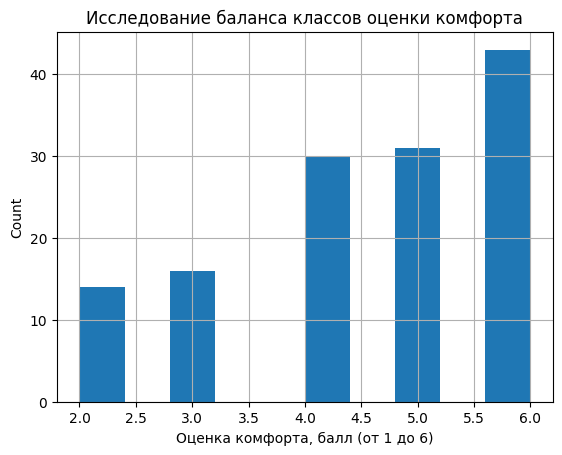

In [158]:
tmp['оценка_комфорта'].hist()
plt.xlabel('Оценка комфорта, балл (от 1 до 6)')
plt.ylabel('Count')
plt.title('Исследование баланса классов оценки комфорта')
plt.show();

In [159]:
# Модель явно переобучается, а ещё катострофически не хватает данных, чтобы
# на их основании заполнять пропуски в оценке комфорта. precision и recall крайне
# малы. Классы не сбалансированы

### Вывод

In [160]:
df.isna().mean()

год                                            0.000000
время_года                                     0.000000
климат                                         0.000000
город                                          0.000000
страна                                         0.000000
способ_охлаждения                              0.000000
режим_при_смешанном_типе_охлаждения            0.304979
способ_обогрева                                0.539419
возраст                                        0.143154
пол                                            0.149378
ощущение_температуры                           0.000000
ощущение_температуры_(bool)                    0.000000
предпочтительное_изменение_температуры         0.000000
ощущение_движения_воздуха_(bool)               0.589212
предпочтительное_изменение_движения_воздуха    0.000000
оценка_комфорта                                0.553942
утепление                                      0.000000
температура_воздуха_в_помещении                0

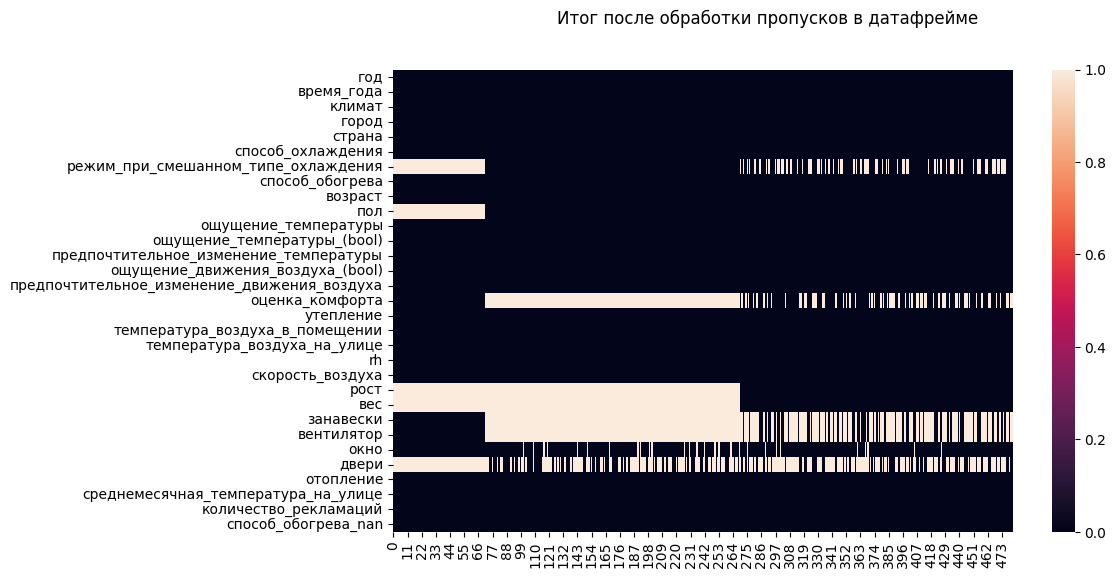

In [161]:
plt.figure(figsize=(10, 6))
sns.heatmap(pd.concat([df_us, df_au, df_in]).isna().T)
plt.suptitle('Итог после обработки пропусков в датафрейме');

In [162]:
# Данные упорядочены по странам, поэтому можем на heatmap пронаблюдать пропуски
print(f'min/max индекс США: {np.min(df_us.index)}, {np.max(df_us.index)}')
print(f'min/max индекс Австралии: {np.min(df_au.index)}, {np.max(df_au.index)}')
print(f'min/max индекс Индии: {np.min(df_in.index)}, {np.max(df_in.index)}')

min/max индекс США: 0, 71
min/max индекс Австралии: 72, 269
min/max индекс Индии: 270, 481


## 1.5 Объединение данных/проверка качества новых данных/удаление ненужных данных

In [163]:
df = pd.concat([df_au, df_us, df_in])

In [164]:
df = df.drop_duplicates().reset_index(drop=True)
df = df.drop(['рост', 'вес', 'вентилятор', 'занавески', 'двери'], axis=1)

In [165]:
# приводим объекты к категории
for col in df.select_dtypes(include='object').columns:
  df[col] = df[col].astype('category')

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 482 entries, 0 to 481
Data columns (total 26 columns):
 #   Column                                       Non-Null Count  Dtype         
---  ------                                       --------------  -----         
 0   год                                          482 non-null    datetime64[ns]
 1   время_года                                   482 non-null    category      
 2   климат                                       482 non-null    category      
 3   город                                        482 non-null    category      
 4   страна                                       482 non-null    category      
 5   способ_охлаждения                            482 non-null    category      
 6   режим_при_смешанном_типе_охлаждения          335 non-null    category      
 7   способ_обогрева                              482 non-null    category      
 8   возраст                                      482 non-null

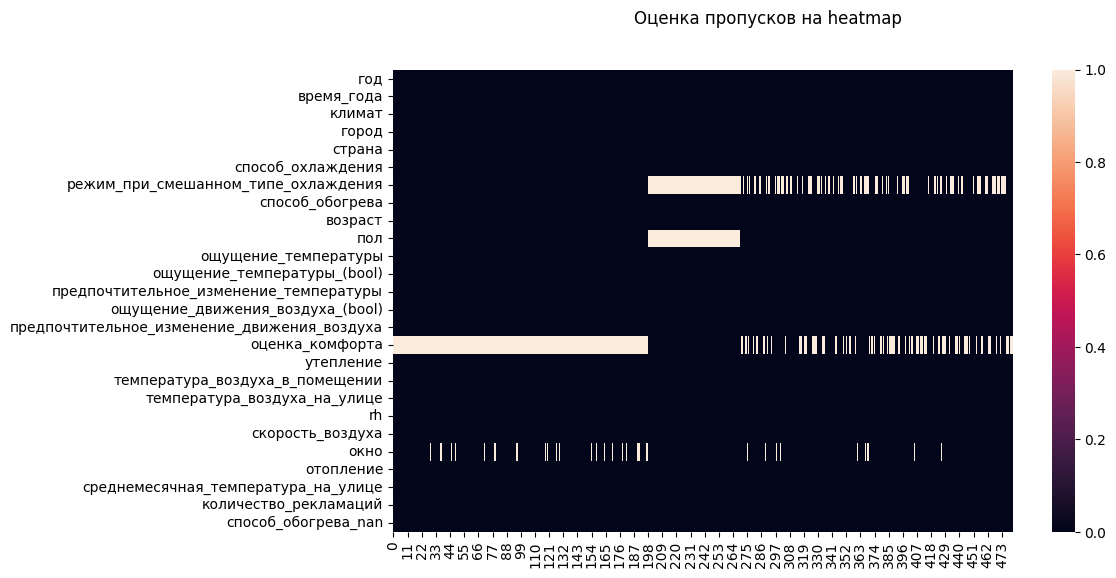



Проверка на дубликаты
Количество полных дубликатов:
 0

Первые 10 строк датасета


год время_года                       климат   город     страна  \
0 2010-01-01       Лето  Cубтропический океанический  Сидней  Австралия   
1 2010-01-01       Лето  Cубтропический океанический  Сидней  Австралия   
2 2010-01-01       Лето  Cубтропический океанический  Сидней  Австралия   
3 2010-01-01       Лето  Cубтропический океанический  Сидней  Австралия   
4 2010-01-01       Лето  Cубтропический океанический  Сидней  Австралия   
5 2010-01-01       Лето  Cубтропический океанический  Сидней  Австралия   
6 2010-01-01       Лето  Cубтропический океанический  Сидней  Австралия   
7 2010-01-01       Лето  Cубтропический океанический  Сидней  Австралия   
8 2010-01-01       Лето  Cубтропический океанический  Сидней  Австралия   
9 2010-01-01       Лето  Cубтропический океанический  Сидней  Австралия   

  способ_охлаждения режим_при_смешанном_типе_охлаждения  способ_обогрева  \
0         Смешанный                   Кондиционирование  Не используется   
1         Смешанный                   Кондиционирование  Не используется   
2         Смешанный                   Кондиционирование  Не используется   
3         Смешанный                   Кондиционирование  Не используется   
4         Смешанный                   Кондиционирование  Не используется   
5         Смешанный                   Кондиционирование  Не используется   
6         Смешанный                   Кондиционирование  Не используется   
7         Смешанный                   Кондиционирование  Не используется   
8         Смешанный                   Кондиционирование  Не используется   
9         Смешанный                   Кондиционирование  Не используется   

   возраст      пол  ощущение_температуры  ощущение_температуры_(bool)  \
0     55.0  Женский                  -1.0                          0.0   
1     55.0  Женский                   0.0                          1.0   
2     55.0  Мужской                   1.0                          1.0   
3     25.0  Женский                   0.0                          1.0   
4     35.0  Мужской                   3.0                          0.0   
5     45.0  Мужской                   1.0                          1.0   
6     35.0  Мужской                   0.0                          1.0   
7     35.0  Мужской                   0.0                          1.0   
8     55.0  Женский                   0.0                          1.0   
9     55.0  Женский                   2.0                          0.0   

  предпочтительное_изменение_температуры  ощущение_движения_воздуха_(bool)  \
0                                 Теплее                               0.0   
1                          Без изменений                               1.0   
2                          Без изменений                               1.0   
3                          Без изменений                               1.0   
4                               Холоднее                               0.0   
5                          Без изменений                               1.0   
6                          Без изменений                               1.0   
7                          Без изменений                               1.0   
8                          Без изменений                               1.0   
9                               Холоднее                               0.0   

  предпочтительное_изменение_движения_воздуха  оценка_комфорта  утепление  \
0                                      Меньше              NaN       0.54   
1                               Без изменений              NaN       0.59   
2                               Без изменений              NaN       0.43   
3                               Без изменений              NaN       0.43   
4                                      Больше              NaN       0.46   
5                               Без изменений              NaN       0.52   
6                               Без изменений              NaN       0.46   
7                               Без изменений           


Описание количественных данных:


count unique        top freq      first  \
год                                    482      3 2012-01-01  212 2010-01-01   
возраст                              482.0    NaN        NaT  NaN        NaT   
ощущение_температуры                 482.0    NaN        NaT  NaN        NaT   
ощущение_температуры_(bool)          482.0    NaN        NaT  NaN        NaT   
ощущение_движения_воздуха_(bool)     482.0    NaN        NaT  NaN        NaT   
оценка_комфорта                      215.0    NaN        NaT  NaN        NaT   
утепление                            482.0    NaN        NaT  NaN        NaT   
температура_воздуха_в_помещении      482.0    NaN        NaT  NaN        NaT   
температура_воздуха_на_улице         482.0    NaN        NaT  NaN        NaT   
rh                                   482.0    NaN        NaT  NaN        NaT   
скорость_воздуха                     482.0    NaN        NaT  NaN        NaT   
окно                                 453.0    NaN        NaT  NaN        NaT   
отопление                            482.0    NaN        NaT  NaN        NaT   
среднемесячная_температура_на_улице  482.0    NaN        NaT  NaN        NaT   
количество_рекламаций                482.0    NaN        NaT  NaN        NaT   
способ_обогрева_nan                  482.0    NaN        NaT  NaN        NaT   

                                          last       mean        std   min  \
год                                 2012-01-01        NaN        NaN   NaN   
возраст                                    NaT  39.360996  10.655782  22.0   
ощущение_температуры                       NaT   0.208299   1.091478  -3.0   
ощущение_температуры_(bool)                NaT   0.788382    0.40888   0.0   
ощущение_движения_воздуха_(bool)           NaT   0.630705   0.483115   0.0   
оценка_комфорта                            NaT   4.767442   1.268549   1.0   
утепление                                  NaT   0.632261   0.251936  0.36   
температура_воздуха_в_помещении            NaT  25.004979   2.765908  16.2   
температура_воздуха_на_улице               NaT  24.175519   5.360732   8.5   
rh                                         NaT  53.019295  13.044019  23.8   
скорость_воздуха                           NaT   0.131743    0.15073   0.0   
окно                                       NaT   0.856512   0.350957   0.0   
отопление                                  NaT    0.16805   0.374299   0.0   
среднемесячная_температура_на_улице        NaT  25.212448   5.926905   8.5   
количество_рекламаций                      NaT   0.105809   0.441138   0.0   
способ_обогрева_nan                        NaT        0.0        0.0   0.0   

                                           25%    50%     75%   max  
год                                        NaN    NaN     NaN   NaN  
возраст                              30.833333   35.0    45.0  65.0  
ощущение_температуры                       0.0    0.0     1.0   3.0  
ощущение_температуры_(bool)                1.0    1.0     1.0   1.0  
ощущение_движения_воздуха_(bool)           0.0    1.0     1.0   1.0  
оценка_комфорта                            4.0    5.0     6.0   6.0  
утепление                                 0.46   0.59     0.7  2.08  
температура_воздуха_в_помещении           23.8   24.6    25.7  37.4  
температура_воздуха_на_улице              22.0   22.0    29.5  38.1  
rh                                       42.85  53.85  62.375  85.1  
скорость_воздуха                          0.07    0.1    0.14  1.43  
окно                                       1.0    1.0     1.0   1.0  
отопление                                  0.0    0.0     0.0   1.0  
среднемесячная_температура_на_улице       22.0   22.0    30.4  38.1  
количество_рекламаций                      0.0    0.0     0.0   3.0  
способ_обогрева_nan                        0.0    0.0     0.0   0.0


Графическое представление количественных данных:


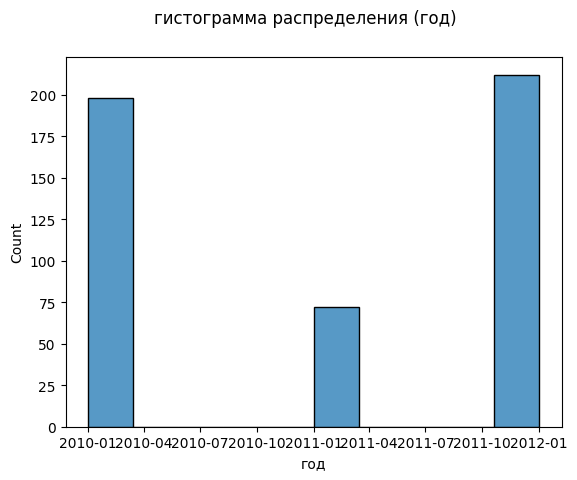

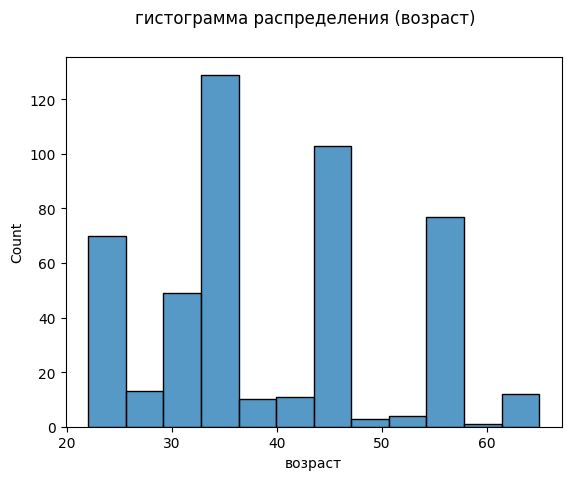

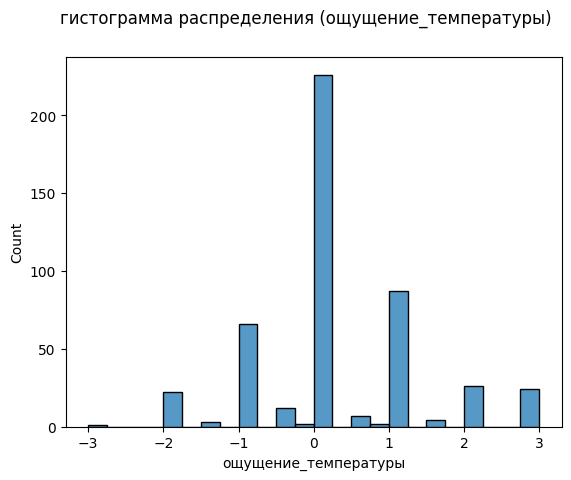

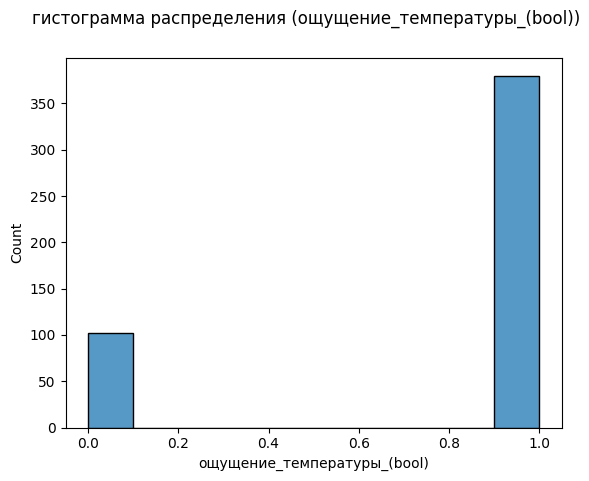

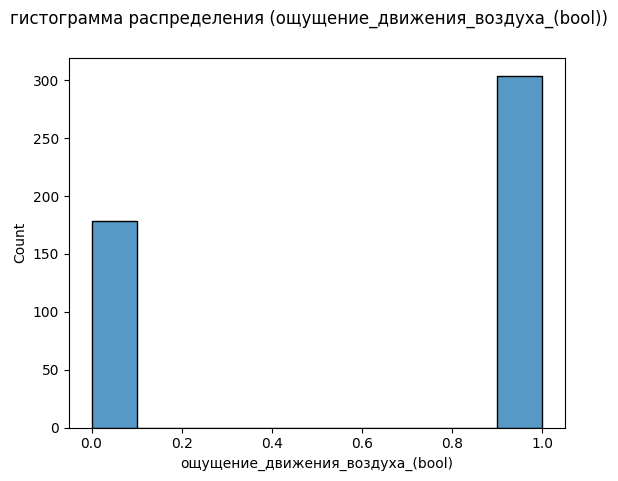

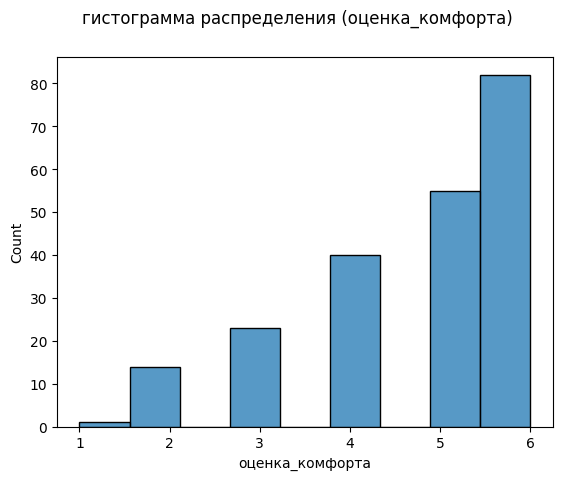

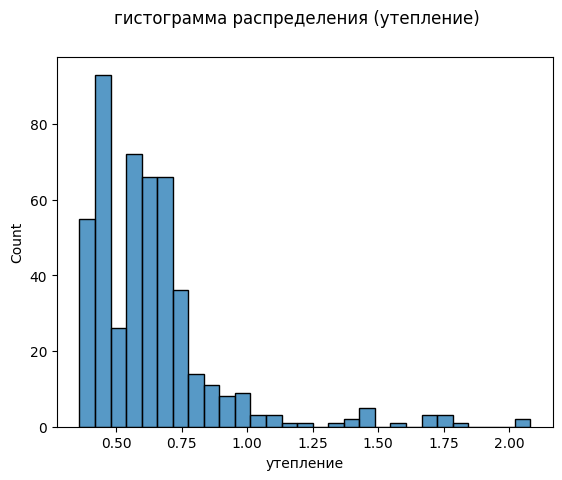

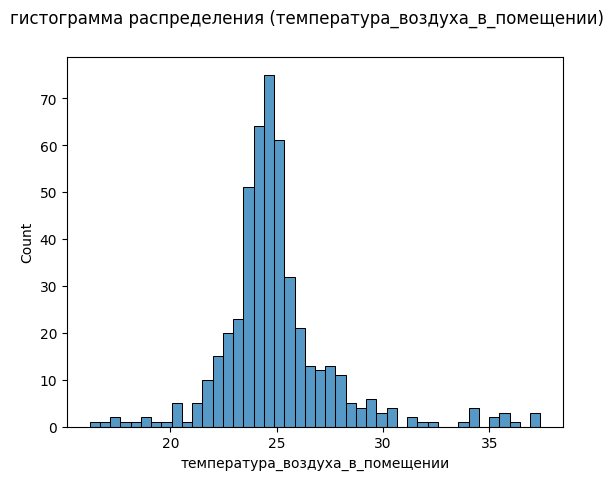

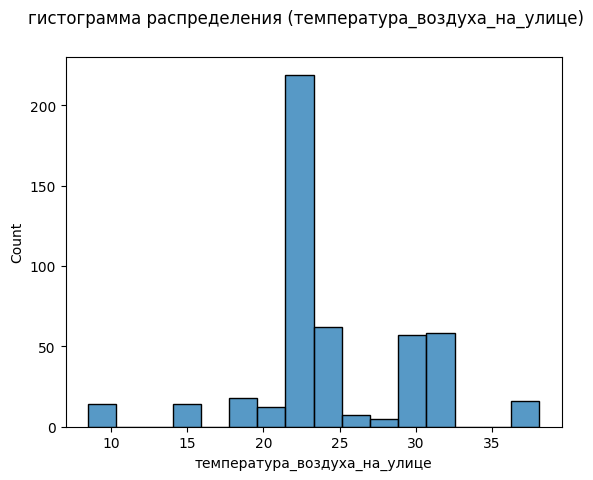

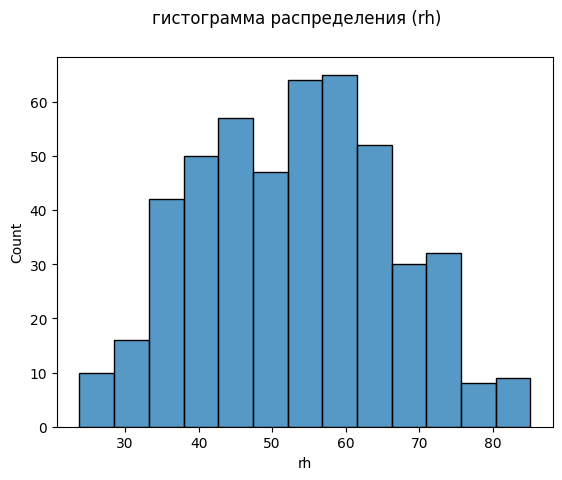

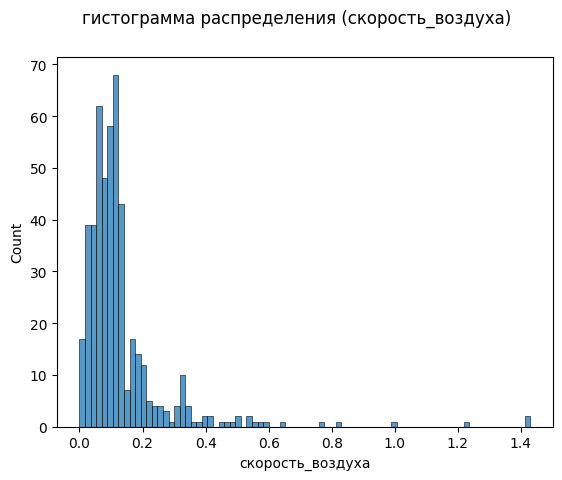

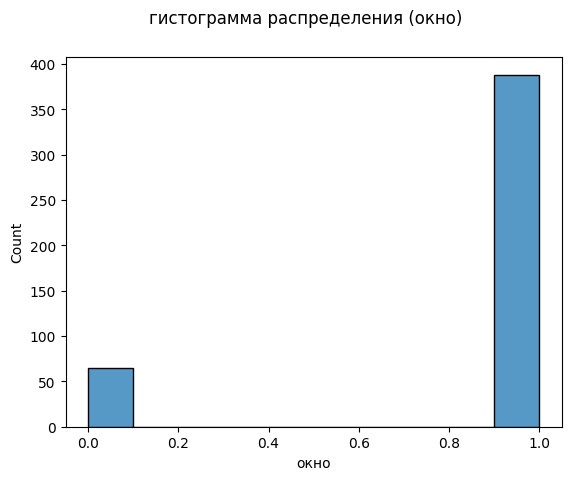

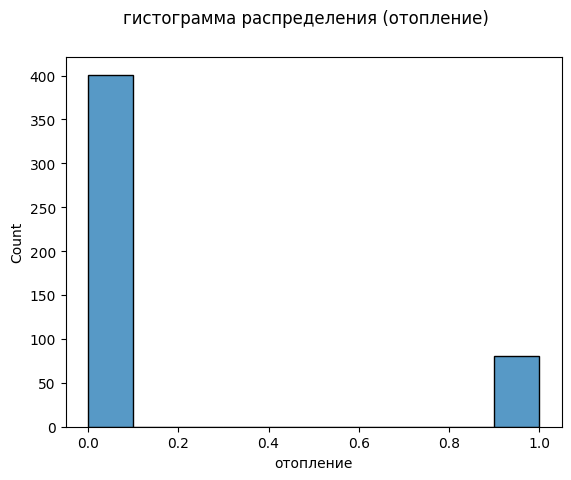

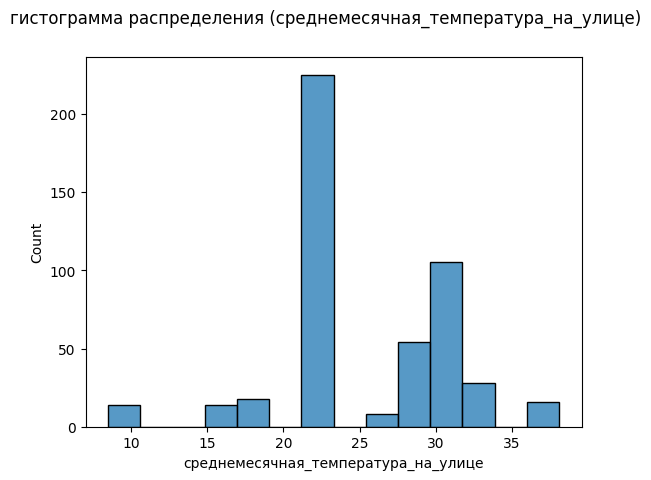

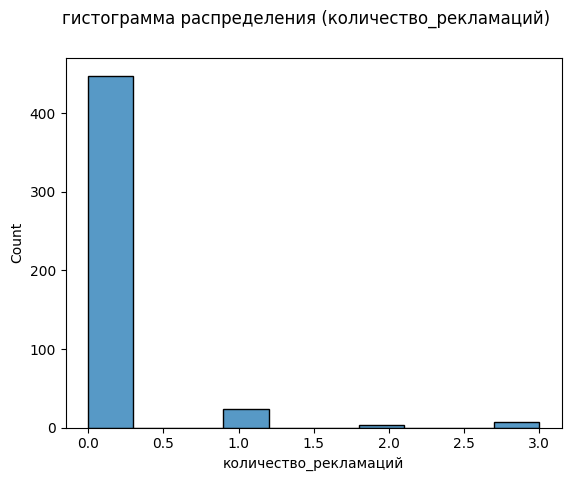

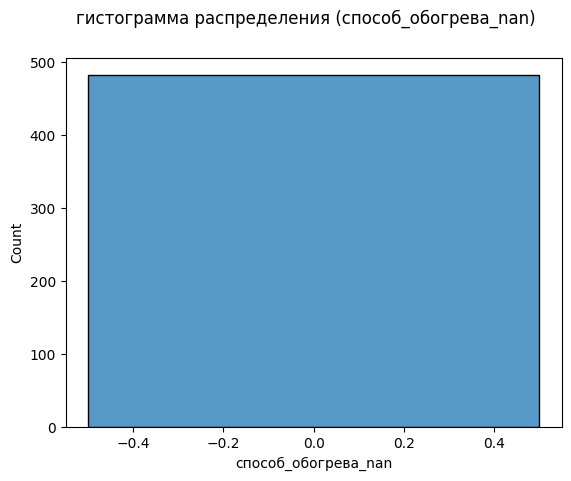



Описание категориальных данных:


count unique  \
время_года                                    482      4   
климат                                        482      5   
город                                         482      8   
страна                                        482      3   
способ_охлаждения                             482      3   
режим_при_смешанном_типе_охлаждения           335      2   
способ_обогрева                               482      3   
пол                                           410      2   
предпочтительное_изменение_температуры        482      3   
предпочтительное_изменение_движения_воздуха   482      3   

                                                                     top freq  
время_года                                                          Лето  372  
климат                                       Cубтропический океанический  270  
город                                                             Сидней  198  
страна                                                             Индия  212  
способ_охлаждения                                              Смешанный  335  
режим_при_смешанном_типе_охлаждения                    Кондиционирование  235  
способ_обогрева                                          Не используется  401  
пол                                                              Мужской  254  
предпочтительное_изменение_температуры                     Без изменений  288  
предпочтительное_изменение_движения_воздуха                Без изменений  291


Графическое представление категориальных данных:


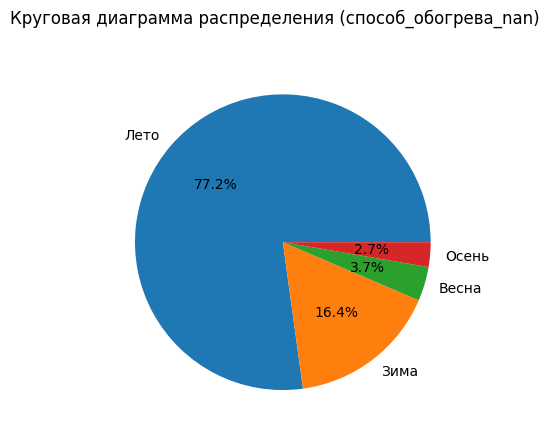

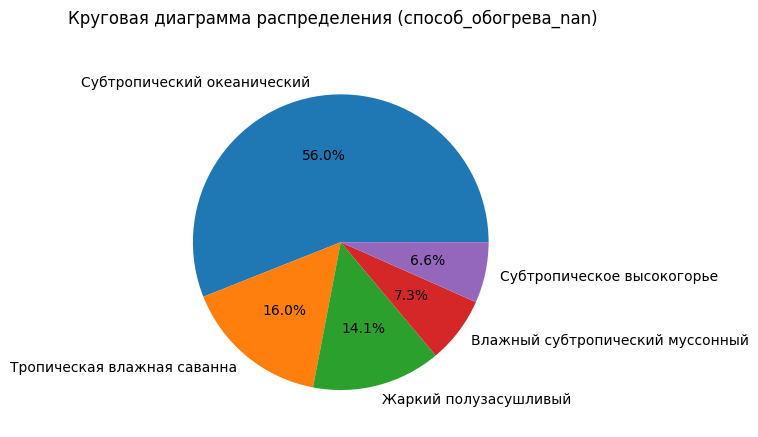

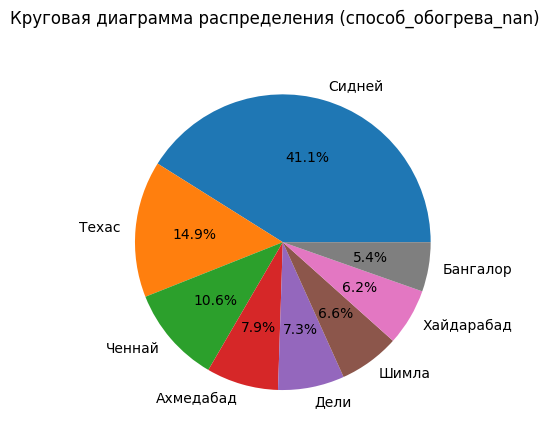

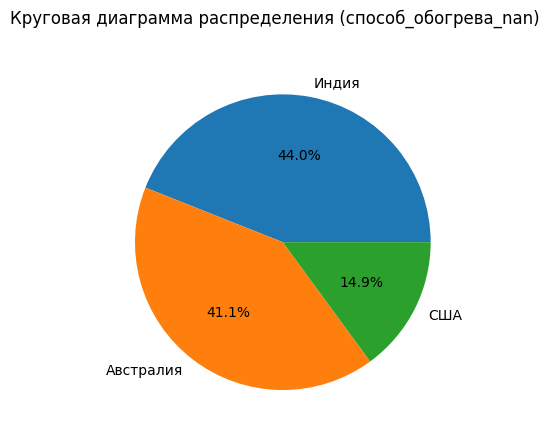

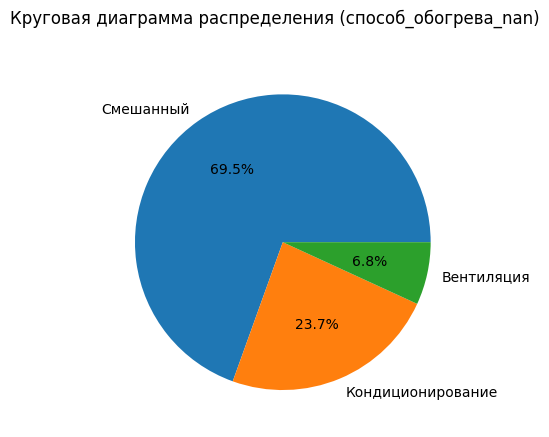

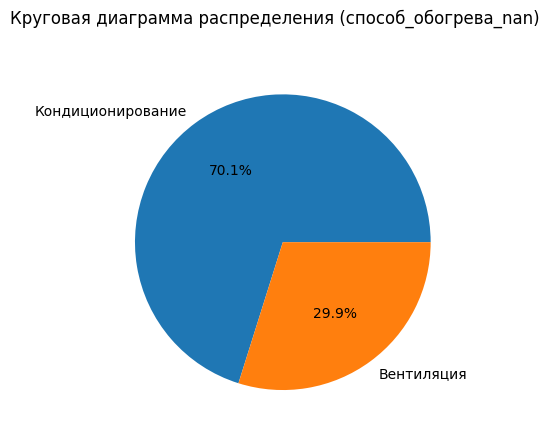

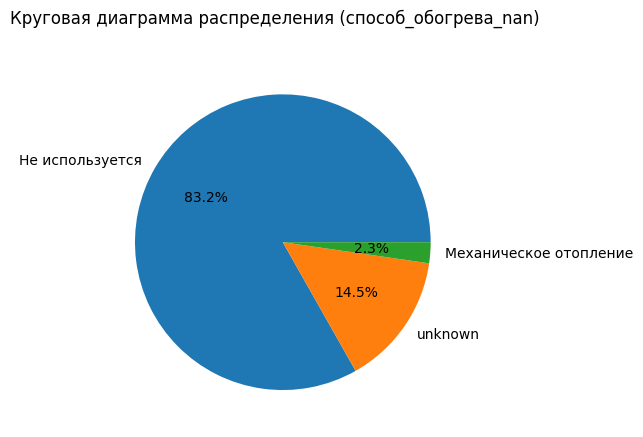

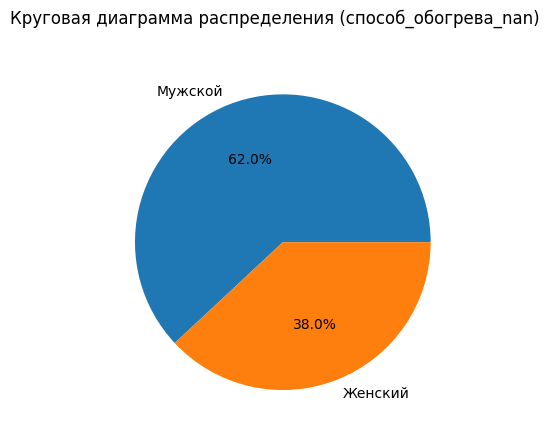

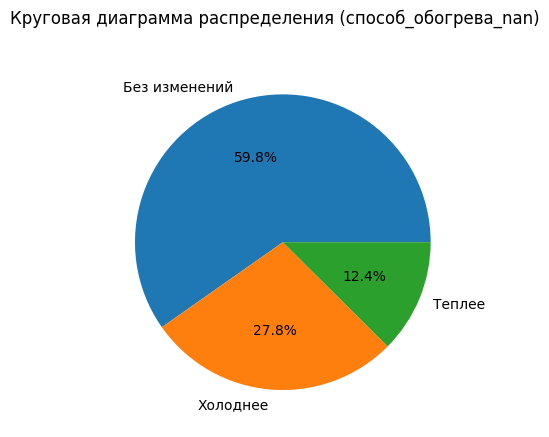

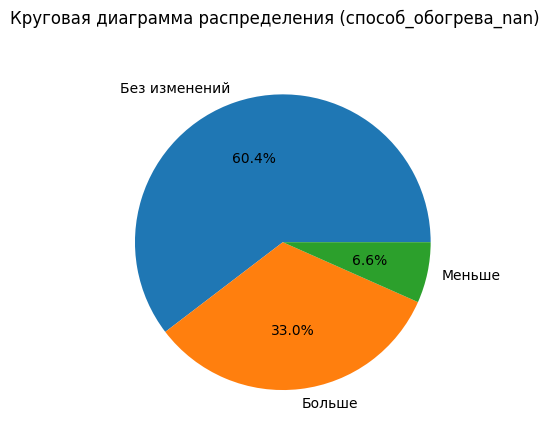

In [166]:
check_data(df)

In [167]:
df['возраст'] = df['возраст'].round(0)
df = df.drop(['способ_обогрева_nan'], axis=1)

# 2. Проведение расчётов и исследований

## 2.1 Расчёты

In [168]:
col = 'количество_рекламаций_категория'
df[col] = df['количество_рекламаций'].apply(
    lambda x:
    'мало' if x <= 1
    else 'средне' if x == 2
    else 'много'
    )
df[col] = df[col].astype('category')

In [169]:
col = 'возрастная_категория'
df[col] = df['возраст'].apply(
    lambda x:
    'молодой возраст' if x <= 44
    else 'средний возраст' if x <= 59
    else 'пожилой возраст'
    )
df[col] = df[col].astype('category')

In [170]:
# Рассчитать среднюю комфортную температуру в зависимости от возрастной категории
df[df['ощущение_температуры_(bool)'] == 1].groupby('возрастная_категория').agg({
    'температура_воздуха_в_помещении': 'mean'
    }).round(1)

температура_воздуха_в_помещении
возрастная_категория                                 
молодой возраст                                  25.2
пожилой возраст                                  25.4
средний возраст                                  24.1

In [171]:
# Средний возраст респондентов по полу и стране
df.groupby(['пол', 'страна']).agg({'возраст': 'mean'}).round(0)

возраст
пол     страна            
Женский Австралия     46.0
        Индия         35.0
        США            NaN
Мужской Австралия     43.0
        Индия         36.0
        США            NaN

In [172]:
# Рассчитать медианное значение температуры и влажности для каждого типа охлаждения
df.groupby(['способ_охлаждения']).agg({
    'температура_воздуха_в_помещении': 'median',
     'rh': 'median'
     })

температура_воздуха_в_помещении     rh
способ_охлаждения                                        
Вентиляция                                    25.3  46.30
Кондиционирование                             24.3  42.45
Смешанный                                     24.6  56.50

In [173]:
# Добавить столбец с процентом удовлетворенных респондентов температурой воздуха
# в помещении относительно всех респондентов одной страны и одного пола
df['процент_удовлетворенных_температурой'] =\
 (df.groupby(['страна', 'пол'])['ощущение_температуры_(bool)'].transform('mean') * 100).round(2)

In [174]:
# Составить сводную таблицу, в которой данные будут сгруппированы по стране,
# полу, возрастной группе и посчитаны средняя температура воздуха в помещении,
# на улице и средняя относительная влажность для каждой из этих групп.
index=['страна', 'пол', 'возрастная_категория']
values=['температура_воздуха_в_помещении', 'температура_воздуха_на_улице', 'rh']
pd.pivot_table(df, index=index, values=values, aggfunc='mean').round(2)

rh  \
страна    пол     возрастная_категория          
Австралия Женский молодой возраст       61.37   
                  пожилой возраст       44.55   
                  средний возраст       61.27   
          Мужской молодой возраст       61.67   
                  пожилой возраст       64.37   
                  средний возраст       61.68   
Индия     Женский молодой возраст       49.89   
                  средний возраст       49.94   
          Мужской молодой возраст       49.54   
                  пожилой возраст       78.80   
                  средний возраст       52.76   

                                        температура_воздуха_в_помещении  \
страна    пол     возрастная_категория                                    
Австралия Женский молодой возраст                                 23.84   
                  пожилой возраст                                 24.90   
                  средний возраст                                 24.11   
          Мужской молодой возраст                                 24.15   
                  пожилой возраст                                 24.73   
                  средний возраст                                 24.04   
Индия     Женский молодой возраст                                 26.67   
                  средний возраст                                 24.23   
          Мужской молодой возраст                                 25.98   
                  пожилой возраст                                 29.30   
                  средний возраст                                 26.19   

                                        температура_воздуха_на_улице  
страна    пол     возрастная_категория                                
Австралия Женский молодой возраст                              22.00  
                  пожилой возраст                              22.00  
                  средний возраст                              22.00  
          Мужской молодой возраст                              22.00  
                  пожилой возраст                              22.00  
                  средний возраст                              22.00  
Индия     Женский молодой возраст                              27.99  
                  средний возраст                              21.83  
          Мужской молодой возраст                              27.45  
                  пожилой возраст                              29.50  
                  средний возраст                              22.81

In [175]:
# Самостоятельно найти информацию по стандартной комфортной относительной
# влажности в помещениях (в нашем случае - офисы). Создать новый категориальный
# столбец, в котором будет показано, удовлетворяет ли зафиксированная
# относительная влажность стандарту или нет. Категории назначить самостоятельно.
col = 'влажность_в_офисе_категория'
df[col] = df['rh'].apply(
    lambda x:
    'сухо' if x <= 20
    else 'удовлетворительно' if x < 40
    else 'рекомендуемая' if 40 <= x <= 60
    else 'удовлетворительно' if x < 70
    else 'сыро'
    )
df[col] = df[col].astype('category')

https://oborona.media/microclimate-at-work/

## 2.2 Исследование корреляции между параметрами



In [176]:
# рассчитать значение корреляции между всеми переменнными в датасете
# поскольку в датасете присутствует значения разных типов, то мы будем считать
# корреляции для 3 случаев:
# 1) Количественная - количественная - корреляция Пирсона/Спирмена
# 2) Категориальная - количественная - корреляция Eta
# 3) Категориальная - категориальная - коэффициент Крамера

# перед этим проверим на нормально количественные признаки в датасете

In [177]:
def check_normality_shapiro(df):
    normality_results = {}
    for column in df.select_dtypes(include=['int', 'float']):
        _, p_value = shapiro(df[column])
        normality_results[column] = p_value

    normality_results = pd.DataFrame(list(normality_results.values()),
                                     index=normality_results.keys())

    return normality_results

In [178]:
print(check_normality_shapiro(df).round(3))

                                          0
возраст                               0.000
ощущение_температуры                  0.000
ощущение_температуры_(bool)           0.000
ощущение_движения_воздуха_(bool)      0.000
оценка_комфорта                       1.000
утепление                             0.000
температура_воздуха_в_помещении       0.000
температура_воздуха_на_улице          0.000
rh                                    0.001
скорость_воздуха                      0.000
окно                                  1.000
отопление                             0.000
среднемесячная_температура_на_улице   0.000
количество_рекламаций                 0.000
процент_удовлетворенных_температурой  1.000


In [179]:
# видно, что данные распределены ненормально для всех колонок
# колонки с результатом 1 недостоверны, поскольку данные в них
# также разделены на категории (0 или 1) и т.д.
# поэтому для всех корреляция с количественными шкалами будем использовать
# корреляцию Спирмена

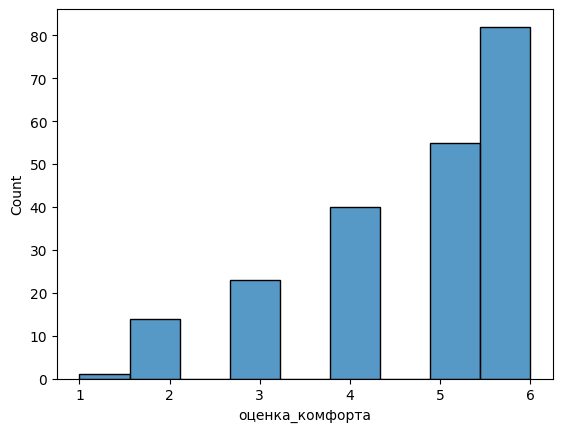

In [180]:
sns.histplot(data=df, x='оценка_комфорта');

In [181]:
df = df.drop('год', axis=1)

In [182]:
corr_df = calculate_correlation_matrix(df)

In [183]:
filt_corr_df = corr_df[corr_df.abs() >= 0.1]

In [184]:
filt_corr_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28 entries, время_года to влажность_в_офисе_категория
Data columns (total 28 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   время_года                                   22 non-null     float64
 1   климат                                       26 non-null     float64
 2   город                                        26 non-null     float64
 3   страна                                       24 non-null     float64
 4   способ_охлаждения                            21 non-null     float64
 5   режим_при_смешанном_типе_охлаждения          9 non-null      float64
 6   способ_обогрева                              19 non-null     float64
 7   возраст                                      19 non-null     float64
 8   пол                                          7 non-null      float64
 9   ощущение_температуры                         15 n

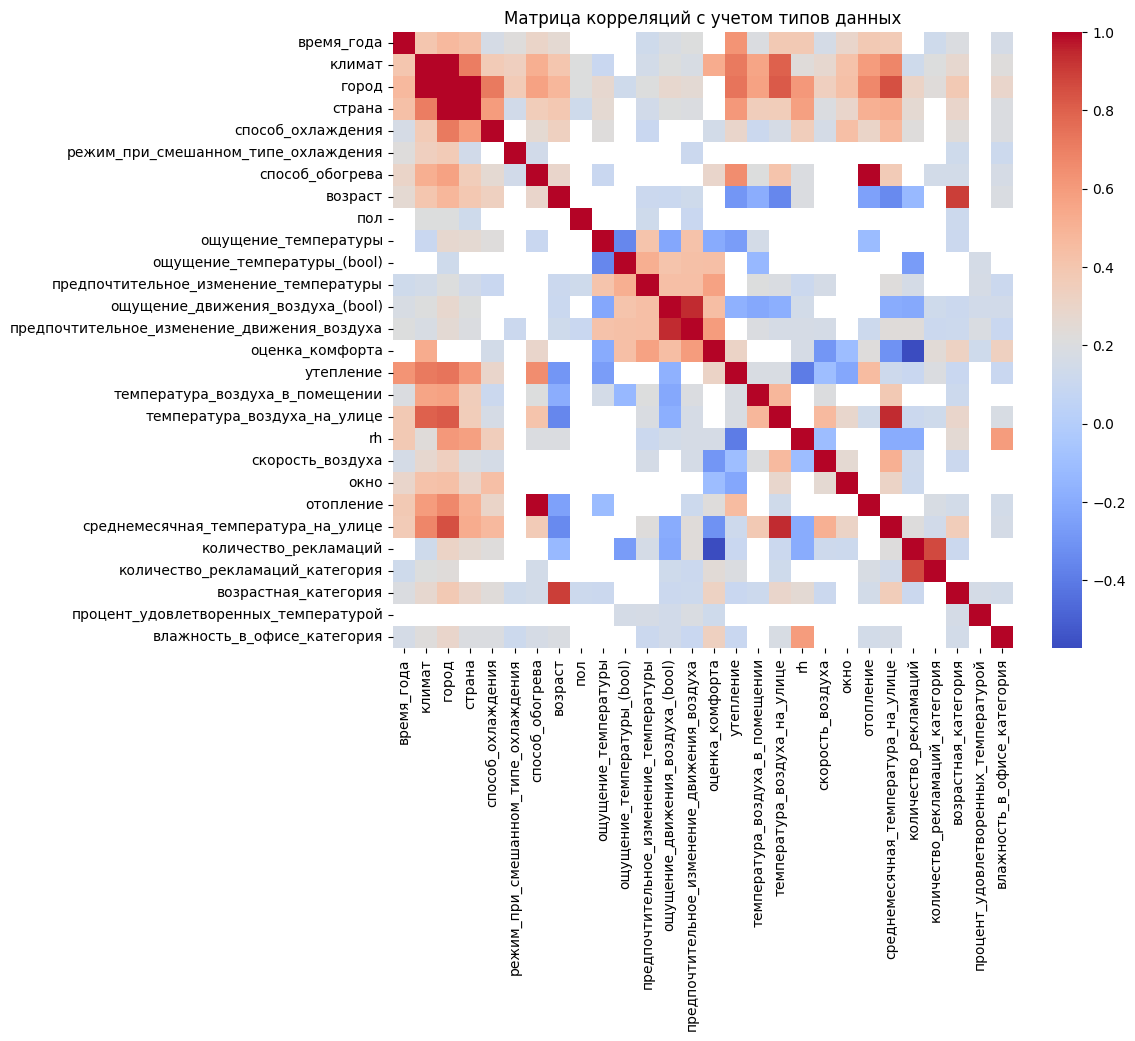

In [185]:
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(filt_corr_df, cmap='coolwarm')
plt.title('Матрица корреляций с учетом типов данных')
plt.show();

## Выводы по анализу корреляций
1) Можно видеть высокие коэффициенты корреляции между категориями страна, город, климат, среднемесячная температура, температура воздуха на улице. Эти корреляции объясняются просто геоографическими связями между собой

2) Также можно видеть большую связь среднемесячной температуры и температуры на улице, но об этом уже было написано выше, когда заполнялись пропуски в температуре на улице

3) Отдельно стоит рассмотреть корреляции с оценкой комфорта: сильнее всего с оценкой комфорта коррелирует количество рекламаций, скорость воздуха, ощущение температуры, ощущение движения воздуха, среднемсячная температура на улице. В целом, эти факторы совпадают с теми, которые мы использовали раннее при попытке заполнения пропусков в оценке комфорта для Австралии. Эти переменные являются одними из ключевых, которые влияют то, насколько комфортно себя чувствует человек.

4) Также, важно обратить внимание на переменные, коррелирующие с температурой воздуха в помещении: температура воздуха на улице, климат, страна, ощущение температуры, среднемесячная температура на улице. При дальнейшем построении регресионной модели эти параметры должны быть включены для прогнозирования температуры воздуха в помещении

5) Можно также наблюдать отрицательную корреляцию между утеплением и ощущением температуры, что говорит о том, что чем холоднее люди оценивают температуры, тем больше одежды они на себя надевают. При этом важно также учесть корреляцию с влажностью, которая также влияет на степень утепления человека.

6) Другие корреляции, например, возраст и различные переменные, связанные с температурой, количество рекламаций и количество рекламаций категория и т.д., носят случайный характер, поэтому их нельзя назвать интерпретируемыми.

# 3. Проверка гипотез

## 3.1 Гипотезы по заданию

In [186]:
# в дальнейшем анализе мы выдвигаем 2 гипотезы:
# H0: различий между группами нет (нулевая гипотеза)
# H1: различия между группами есть (альтернативная гипотеза)

In [187]:
# перед проверкой гипотез оценим, влияет ли включенное
# отопление на оценку комфорта
groups = df[['отопление', 'оценка_комфорта']].dropna()
print(groups.groupby('отопление')['оценка_комфорта'].count())
group1 = groups[groups['отопление'] == 1.0]['оценка_комфорта']
group2 = groups[groups['отопление'] == 0.0]['оценка_комфорта']
p_value, method = numeric_hypothesis_test(group1, group2)
print(f'Метод: {method}, p-value: {p_value}')

отопление
0.0    134
1.0     81
Name: оценка_комфорта, dtype: int64
Метод: Манн-Уитни, p-value: 0.001171


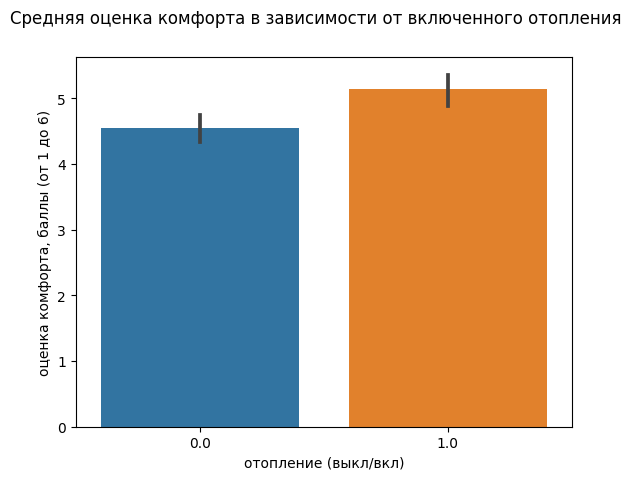

In [188]:
sns.barplot(df, x='отопление', y='оценка_комфорта')
plt.xlabel('отопление (выкл/вкл)')
plt.ylabel('оценка комфорта, баллы (от 1 до 6)')
plt.suptitle('Средняя оценка комфорта в зависимости от включенного отопления')
plt.show();

In [189]:
# на основе p-value принимаем гипотезу H1
# поскольку мы видим значимое влияние, отфильтруем только те значение
# где отопление выключено, поскольку отопление "загрязнает" наши данные при оценке
# систем охлаждения

In [190]:
df_filt = df[df['отопление'] == 0.0]

### 3.1.1 Влияет ли способ охлаждения на оценку комфорта?

In [191]:
# проверим гипотезу о том, влияет ли способ_охлаждения на оценку_комфорта
print(df_filt.groupby('способ_охлаждения')['оценка_комфорта'].count())
multi_group_analyze(df_filt, 'способ_охлаждения', 'оценка_комфорта')

способ_охлаждения
Вентиляция           28
Кондиционирование    72
Смешанный            34
Name: оценка_комфорта, dtype: int64
Краскел-Уоллес, стастистика: 15.0144, p-value: 0.0005


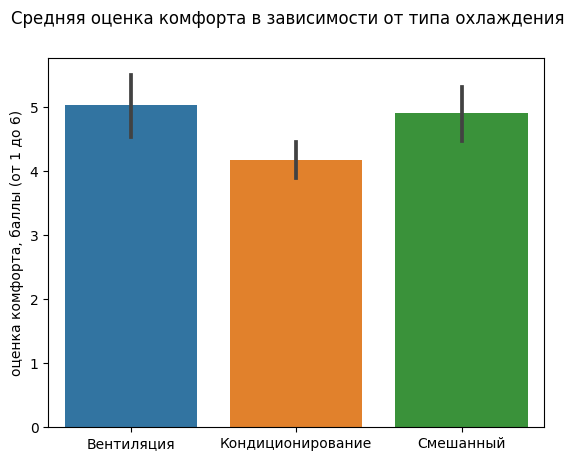

In [192]:
sns.barplot(df_filt, x='способ_охлаждения', y='оценка_комфорта')
plt.xlabel('')
plt.ylabel('оценка комфорта, баллы (от 1 до 6)')
plt.suptitle('Средняя оценка комфорта в зависимости от типа охлаждения')
plt.show();

In [193]:
# на основании p-value мы принимаем гипотезу H1:
# оценка комфорта значимо различается при разных типах охлаждения,
# при этом наименьшая оценка наблюдается для Кондиционирования

### 3.1.2 Влияет ли пол на оценку комфорта?

In [194]:
# проверим гипотезу о том, влияет ли пол на оценку_комфорта
groups = df_filt[['пол', 'оценка_комфорта']].dropna()
print(groups.groupby('пол')['оценка_комфорта'].count())
group1 = groups[groups['пол'] == 'Мужской']['оценка_комфорта']
group2 = groups[groups['пол'] == 'Женский']['оценка_комфорта']
p_value, method = numeric_hypothesis_test(group1, group2)
print(f'Метод: {method}, p-value: {p_value}')

пол
Женский    18
Мужской    44
Name: оценка_комфорта, dtype: int64
Метод: Манн-Уитни, p-value: 0.9003


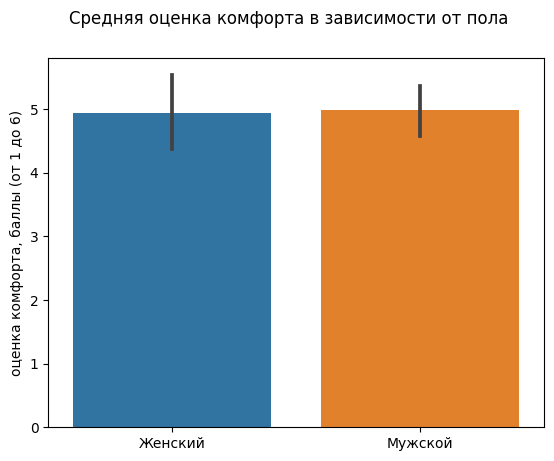

In [195]:
sns.barplot(df_filt, x='пол', y='оценка_комфорта')
plt.xlabel('')
plt.ylabel('оценка комфорта, баллы (от 1 до 6)')
plt.suptitle('Средняя оценка комфорта в зависимости от пола')
plt.show();

In [196]:
# на основании p-value мы принимаем гипотезу H0:
# оценка комфорта значимо не различается для мужского и женского пола

### 3.1.3 Влияет ли возрастная группа на оценку комфорта?

In [197]:
# проверим гипотезу о том, влияет ли возрастная группа на оценку_комфорта

print(df_filt.groupby('возрастная_категория')['оценка_комфорта'].count())

# поскольку для пожилого возраста есть всего 1 человек, попробуем посмотреть
# разницу только для среднего и молодого возраста
groups = df_filt[['возрастная_категория', 'оценка_комфорта']].dropna()
group1 = groups[groups['возрастная_категория'] == 'молодой возраст']['оценка_комфорта']
group2 = groups[groups['возрастная_категория'] == 'средний возраст']['оценка_комфорта']
p_value, method = numeric_hypothesis_test(group1, group2)
print(f'Метод: {method}, p-value: {p_value}')

возрастная_категория
молодой возраст    83
пожилой возраст     1
средний возраст    50
Name: оценка_комфорта, dtype: int64
Метод: Манн-Уитни, p-value: 6.086e-05


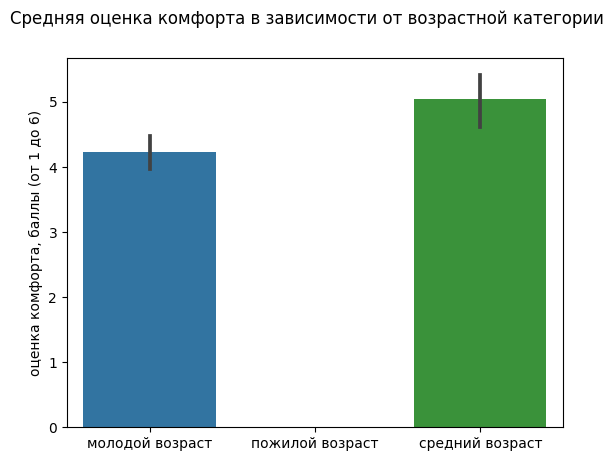

In [198]:
df_for_plot = df_filt[(df_filt['возрастная_категория'] != 'пожилой возраст')].copy()
sns.barplot(df_for_plot, x='возрастная_категория', y='оценка_комфорта')
plt.xlabel('')
plt.ylabel('оценка комфорта, баллы (от 1 до 6)')
plt.suptitle('Средняя оценка комфорта в зависимости от возрастной категории')
plt.show();

In [199]:
# на основании p-value мы принимаем гипотезу H1:
# оценка комфорта значимо различается для разных возрастных групп,
# при этом молодые демонстрируют более низкую оценку

### 3.1.4 Есть ли взаимосвязь между количеством рекламаций и оценкой комфорта?

In [200]:
# проверим гипотезу о связи количества рекламаций и оценкой комфорта
groups = df_filt[['количество_рекламаций_категория', 'оценка_комфорта']].dropna()
print(df_filt.groupby('количество_рекламаций_категория')['оценка_комфорта'].count())
group1 = groups[groups['количество_рекламаций_категория'] == 'мало']['оценка_комфорта']
group2 = groups[groups['количество_рекламаций_категория'] == 'много']['оценка_комфорта']
p_value, method = numeric_hypothesis_test(group1, group2)
print(f'Метод: {method}, p-value: {p_value}')

количество_рекламаций_категория
мало      131
много       3
средне      0
Name: оценка_комфорта, dtype: int64
Метод: Манн-Уитни, p-value: 0.0498


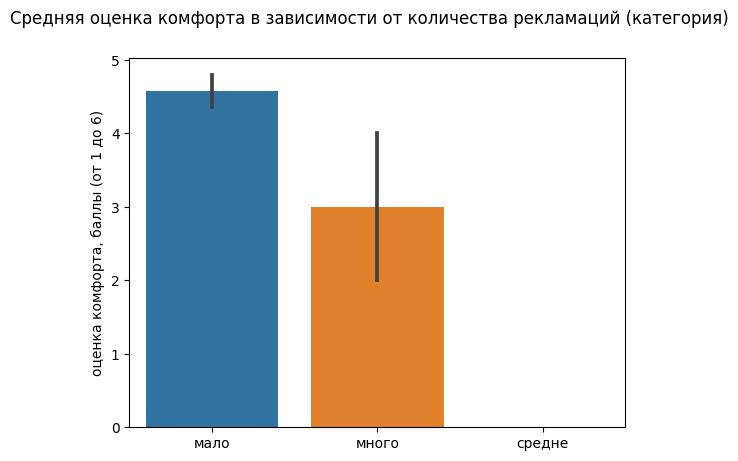

In [201]:
sns.barplot(df_filt, x='количество_рекламаций_категория', y='оценка_комфорта')
plt.xlabel('')
plt.ylabel('оценка комфорта, баллы (от 1 до 6)')
plt.suptitle('Средняя оценка комфорта в зависимости от количества рекламаций (категория)')
plt.show();

In [202]:
# на основании p-value мы принимаем гипотезу H1:
# оценка комфорта значимо различается для категорий количества рекламаций,
# при этом чем больше рекламаций, тем ниже оценка комфорта

In [203]:
# дополнительно посмотрим, будет ли связь количества рекламаций без категорий
# и оценки комфорта
groups = df_filt[['количество_рекламаций', 'оценка_комфорта']].dropna()
group1 = groups['количество_рекламаций']
group2 = groups['оценка_комфорта']
stat, p_value = spearmanr(group1, group2)
print(f'Корреляция: {stat:.2f}, p-value: {p_value:.4f}')

Корреляция: -0.60, p-value: 0.0000


In [204]:
# на основании p-value мы принимаем гипотезу H1:
# оценка комфорта значимо коррелирует с количеством рекламаций,
# при этом чем больше рекламаций, тем ниже оценка комфорта

### 3.1.5 Cредняя оценка комфорта отличается в зависимости от страны?

In [205]:
# посмотрим разницу в оценке комфорта в зависимости от страны
groups = df_filt[['страна', 'оценка_комфорта']].dropna()
print(df_filt.groupby('страна')['оценка_комфорта'].count())
group1 = groups[groups['страна'] == 'Индия']['оценка_комфорта']
group2 = groups[groups['страна'] == 'США']['оценка_комфорта']
p_value, method = numeric_hypothesis_test(group1, group2)
print(f'Метод: {method}, p-value: {p_value}')

страна
Австралия     0
Индия        62
США          72
Name: оценка_комфорта, dtype: int64
Метод: Манн-Уитни, p-value: 0.000122


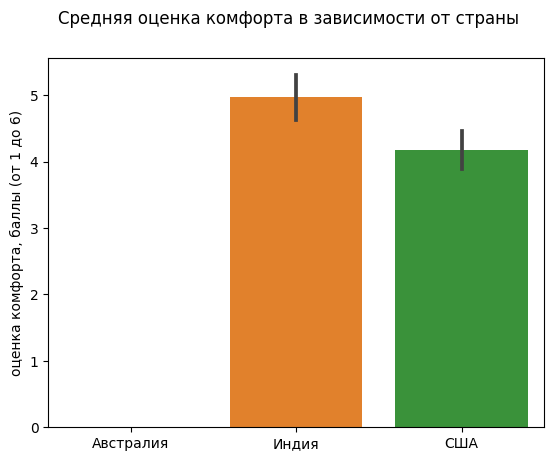

In [206]:
sns.barplot(df_filt, x='страна', y='оценка_комфорта')
plt.xlabel('')
plt.ylabel('оценка комфорта, баллы (от 1 до 6)')
plt.suptitle('Средняя оценка комфорта в зависимости от страны')
plt.show();

In [207]:
# на основании p-value мы принимаем гипотезу H1:
# оценка комфорта значимо различается для разных стран,
# при этом наименьшая оценка наблюдается для США

## 3.2 Наши гипотезы

### 3.2.1 климат - ощущение_температуры

In [208]:
# посмотрим на связь типа климата и ощущения_температуры
print(df_filt.groupby('климат')['ощущение_температуры'].count())
multi_group_analyze(df_filt, 'климат', 'ощущение_температуры')

климат
Cубтропический океанический         270
Влажный субтропический муссонный      9
Жаркий полузасушливый                53
Субтропическое высокогорье           18
Тропическая влажная саванна          51
Name: ощущение_температуры, dtype: int64
Краскел-Уоллес, стастистика: 9.9018, p-value: 0.0421


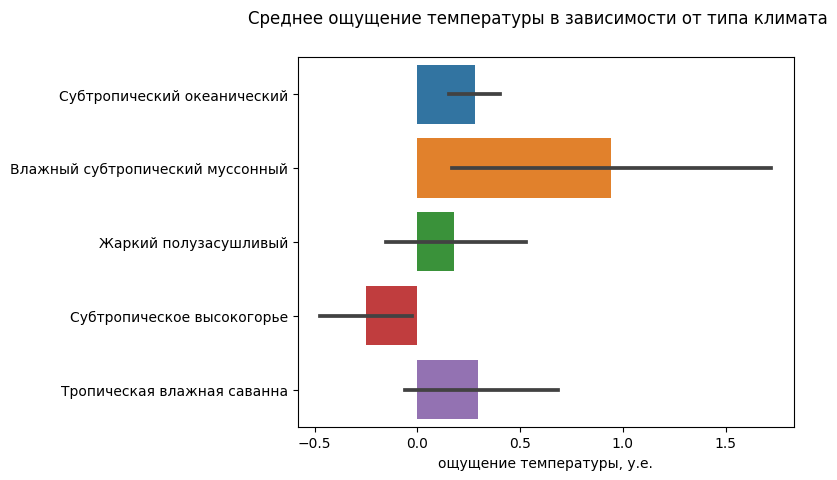

In [209]:
sns.barplot(df_filt, y='климат', x='ощущение_температуры')
plt.xlabel('ощущение температуры, у.е.')
plt.ylabel('')
plt.suptitle('Среднее ощущение температуры в зависимости от типа климата')
plt.show();

In [210]:
# на основании p-value мы принимаем гипотезу H1:
# ощущение температуры значимо различается для разных типов климата,
# при этом холоднее всего люди оценивают температуру в субтроппическом высокогорье

### 3.2.2 окно - ощущение_движения_воздуха_bool

In [211]:
# проверим связь окон и ощущения движения воздуха
groups = df[['ощущение_движения_воздуха_(bool)', 'окно']].dropna()
corr, p_value = crammer_and_pvalue(groups, 'ощущение_движения_воздуха_(bool)', 'окно')
print(f'Корреляция: {corr}, p-value: {p_value}')

Корреляция: 0.05, p-value: 0.2988


In [212]:
# на основании p-value мы принимаем гипотезу H0:
# открытое окно не связано с ощущением движения воздуха

### 3.2.3 влажность__в_офисе_категория - оценка_комфорта

In [213]:
# проверм как связана влажность воздуха и оценка комфорта
print(df_filt.groupby('влажность_в_офисе_категория')['оценка_комфорта'].count())
multi_group_analyze(df_filt, 'влажность_в_офисе_категория', 'оценка_комфорта')

влажность_в_офисе_категория
рекомендуемая        50
сыро                 19
удовлетворительно    65
Name: оценка_комфорта, dtype: int64
Краскел-Уоллес, стастистика: 17.4643, p-value: 0.0002


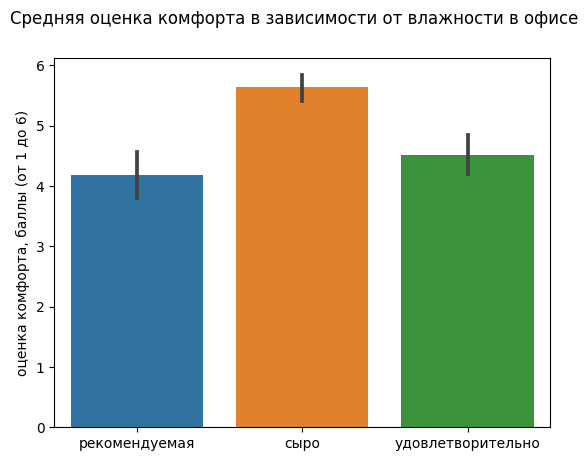

In [214]:
sns.barplot(df_filt, x='влажность_в_офисе_категория', y='оценка_комфорта')
plt.xlabel('')
plt.ylabel('оценка комфорта, баллы (от 1 до 6)')
plt.suptitle('Средняя оценка комфорта в зависимости от влажности в офисе')
plt.show();

In [215]:
# на основании p-value мы принимаем гипотезу H1:
# оценка комфорта значимо различается для разных категорий влажности воздуха
# при это самая низкая оценка наблюдается при рекомендуемой категории влажности

### 3.2.4 rh - ощущение_температуры / ощущение_температуры_bool

In [216]:
groups = df[['ощущение_температуры_(bool)', 'rh']].dropna()
print(groups.groupby('ощущение_температуры_(bool)')['rh'].count())
group1 = groups[groups['ощущение_температуры_(bool)'] == 1.0]['rh']
group2 = groups[groups['ощущение_температуры_(bool)'] == 0.0]['rh']
p_value, method = numeric_hypothesis_test(group1, group2)
print(f'Метод: {method}, p-value: {p_value}')

ощущение_температуры_(bool)
0.0    102
1.0    380
Name: rh, dtype: int64
Метод: Манн-Уитни, p-value: 0.2067


In [217]:
# на основании p-value мы принимаем гипотезу H0:
# влажность не различается для 2 групп в ощущении_температуры_bool

In [218]:
groups = df[['rh', 'ощущение_температуры']].dropna()
group1 = groups['rh']
group2 = groups['ощущение_температуры']
stat, p_value = spearmanr(group1, group2)
print(f'Корреляция: {stat:.3f}, p-value: {p_value:.4f}')

Корреляция: 0.099, p-value: 0.0293


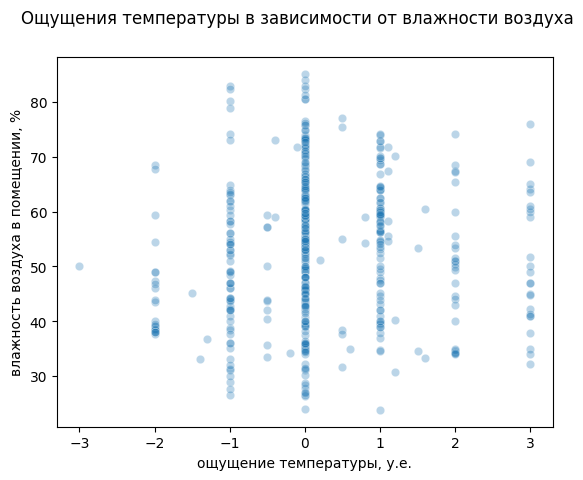

In [219]:
sns.scatterplot(df, y='rh', x='ощущение_температуры', alpha=0.3)
plt.xlabel('ощущение температуры, у.е.')
plt.ylabel('влажность воздуха в помещении, %')
plt.suptitle('Ощущения температуры в зависимости от влажности воздуха')
plt.show();

In [220]:
# на основании p-value мы принимаем гипотезу H1:
# влажность показывает значимую корреляцию с ощущением температуры
# однако коэффициент корреляции крайне мал, поэтому мы не можем говорить о
# достоверности данного результата

### 3.2.5 скорость_воздуха - оценка_комфорта

In [221]:
# посмотрим на связь скорости воздуха и оценки комфорта
groups = df[['скорость_воздуха', 'оценка_комфорта']].dropna()
group1 = groups['скорость_воздуха']
group2 = groups['оценка_комфорта']
stat, p_value = spearmanr(group1, group2)
print(f'Корреляция: {stat:.2f}, p-value: {p_value:.4f}')

Корреляция: -0.29, p-value: 0.0000


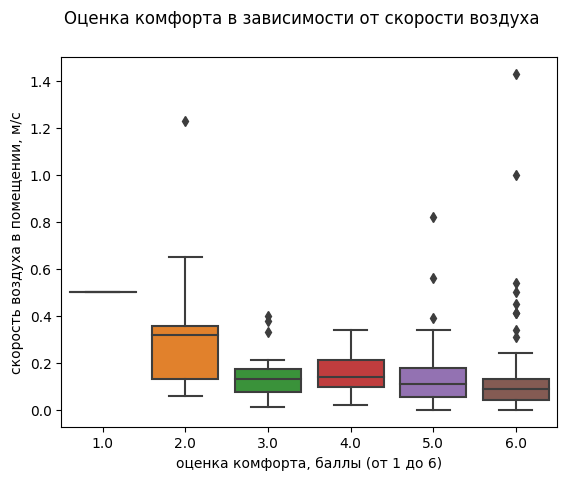

In [222]:
sns.boxplot(df, x='оценка_комфорта', y='скорость_воздуха')
plt.ylabel('скорость воздуха в помещении, м/c')
plt.xlabel('оценка комфорта, баллы (от 1 до 6)')
plt.suptitle('Оценка комфорта в зависимости от скорости воздуха')
plt.show();

In [223]:
# на основании p-value мы принимаем гипотезу H1:
# есть значимая корреляция между скоростью воздуха и оценкой комфорта,
# при этом оценка комфорта ниже для более высокой скорости воздуха

### 3.2.6 температура_воздуха_на_улице - ощущение_температуры

In [224]:
groups = df[['температура_воздуха_на_улице', 'ощущение_температуры']].dropna()
group1 = groups['температура_воздуха_на_улице']
group2 = groups['ощущение_температуры']
stat, p_value = spearmanr(group1, group2)
print(f'Корреляция: {stat:.3f}, p-value: {p_value:.4f}')

Корреляция: -0.043, p-value: 0.3463


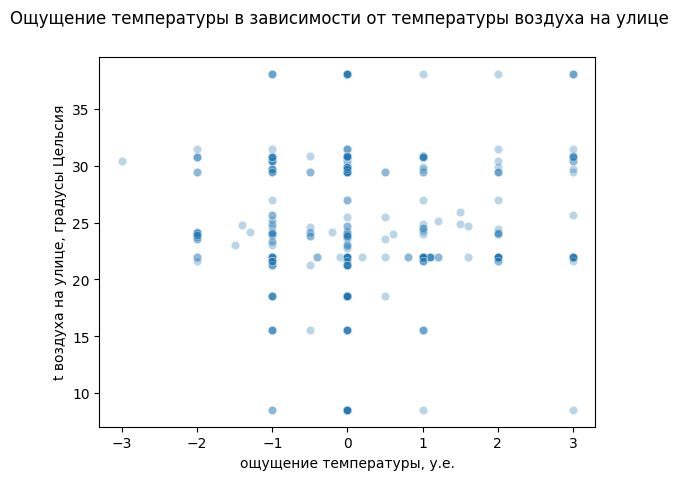

In [225]:
sns.scatterplot(df, y='температура_воздуха_на_улице', x='ощущение_температуры',
                alpha=0.3)
plt.xlabel('ощущение температуры, у.е.')
plt.ylabel('t воздуха на улице, градусы Цельсия')
plt.suptitle('Ощущение температуры в зависимости от температуры воздуха на улице')
plt.show();

In [226]:
# на основании p-value мы принимаем гипотезу H0:
# нет зависимости факторов между ощущением тепмературы и температурой воздуха на улице

### 3.2.7 режим_при_смешанном_типе_охлаждения - оценка_комфорта

In [227]:
# проверм как связаны режим_при_смешанном_типе_охлаждения и оценка_комфорта
col1 = 'режим_при_смешанном_типе_охлаждения'
col2 = 'оценка_комфорта'
groups = df_filt[[col1, col2]].dropna()
print(groups.groupby(col1)[col2].count())
pvalue, method = numeric_hypothesis_test(groups[groups[col1] == 'Кондиционирование'][col2],
                                         groups[groups[col1] == 'Вентиляция'][col2])
print(f'Метод: {method}, p-value: {pvalue}')

режим_при_смешанном_типе_охлаждения
Вентиляция           28
Кондиционирование     6
Name: оценка_комфорта, dtype: int64
Метод: Манн-Уитни, p-value: 0.01181


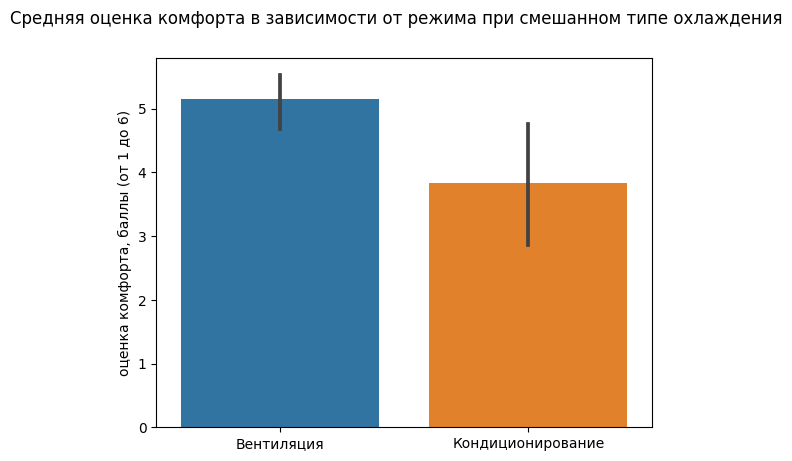

In [228]:
sns.barplot(df_filt, x='режим_при_смешанном_типе_охлаждения', y='оценка_комфорта')
plt.xlabel('')
plt.ylabel('оценка комфорта, баллы (от 1 до 6)')
plt.suptitle('Средняя оценка комфорта в зависимости от режима при смешанном типе охлаждения')
plt.show();

In [229]:
# из-за недостатка данных мы не можем использовать данный статистический вывод
# как истинный

### 3.2.8 ощущение_температуры_bool - оценка_комфорта

In [230]:
# проверм как связаны ощущение_температуры_bool - оценка_комфорта
col1 = 'ощущение_температуры_(bool)'
col2 = 'оценка_комфорта'
groups = df_filt[[col1, col2]].dropna()
print(groups.groupby(col1)[col2].count())
pvalue, method = numeric_hypothesis_test(groups[groups[col1] == 0][col2].dropna(),
                                         groups[groups[col1] == 1][col2].dropna())
print(f'Метод: {method}, p-value: {pvalue}')

ощущение_температуры_(bool)
0.0     29
1.0    105
Name: оценка_комфорта, dtype: int64
Метод: Манн-Уитни, p-value: 7.597e-09


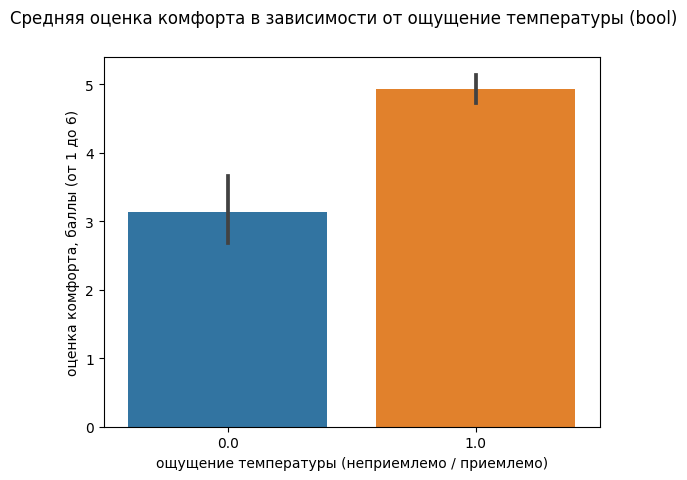

In [231]:
sns.barplot(df_filt, x='ощущение_температуры_(bool)', y='оценка_комфорта')
plt.xlabel('ощущение температуры (неприемлемо / приемлемо)')
plt.ylabel('оценка комфорта, баллы (от 1 до 6)')
plt.suptitle('Средняя оценка комфорта в зависимости от ощущение температуры (bool)')
plt.show();

In [232]:
# на основании p-value мы принимаем гипотезу H1:
# оценка комфорта значимо различается в зависимиости от приемлемости температуры:
# если температура неприемлелма, то оценка комфорта намного ниже

### 3.2.9 климата - оценка_комфорта

In [233]:
print(df_filt.groupby('климат')['оценка_комфорта'].count())
multi_group_analyze(df_filt, 'климат', 'оценка_комфорта')

климат
Cубтропический океанический         72
Влажный субтропический муссонный     9
Жаркий полузасушливый               23
Субтропическое высокогорье          18
Тропическая влажная саванна         12
Name: оценка_комфорта, dtype: int64
Краскел-Уоллес, стастистика: 22.0547, p-value: 0.0002


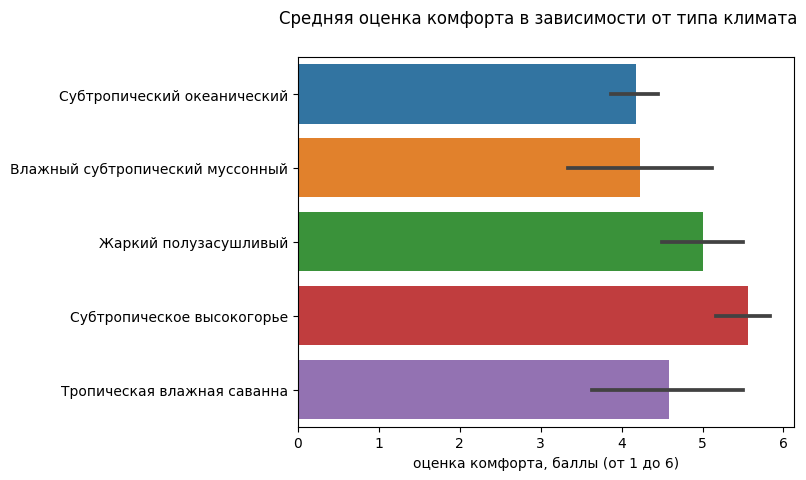

In [234]:
sns.barplot(df_filt, y='климат', x='оценка_комфорта')
plt.xlabel('оценка комфорта, баллы (от 1 до 6)')
plt.ylabel('')
plt.suptitle('Средняя оценка комфорта в зависимости от типа климата')
plt.show();

In [235]:
# на основании p-value мы принимаем гипотезу H1:
# оценка комфорта значимо различается в зависимиости от типа климата:
# самая низкая оценка комфорта наблюдается в субтропическом океаническом климате

### 3.2.10 режим при смешанном типе охлаждения - ощущение температуры_(bool) в Австралии

---



In [236]:
groups = df_filt[df_filt['страна'] == 'Австралия']
groups = groups[['режим_при_смешанном_типе_охлаждения', 'ощущение_температуры_(bool)']].dropna()
corr, p_value = crammer_and_pvalue(groups, 'режим_при_смешанном_типе_охлаждения', 'ощущение_температуры_(bool)')
print(f'Крамер: {corr}, p-value: {p_value}')

Крамер: 0.1, p-value: 0.1593


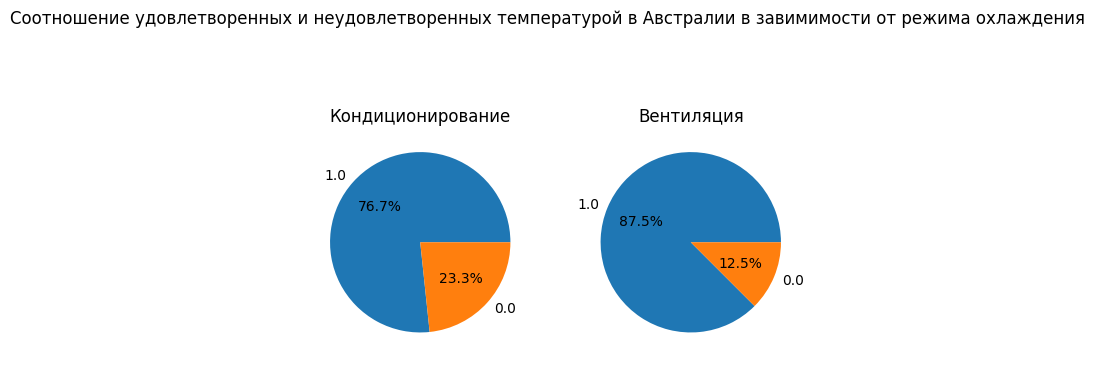

In [237]:
fig, ax = plt.subplots(1, 2)
group1 = groups[groups['режим_при_смешанном_типе_охлаждения'] == 'Кондиционирование']
group2 = groups[groups['режим_при_смешанном_типе_охлаждения'] == 'Вентиляция']
ax[0].pie(x=group1['ощущение_температуры_(bool)'].value_counts(),
          labels=group1['ощущение_температуры_(bool)'].unique()[::-1],
          autopct='%1.1f%%')
ax[0].set_title('Кондиционирование')
ax[1].pie(x=group2['ощущение_температуры_(bool)'].value_counts(),
          labels=group1['ощущение_температуры_(bool)'].unique()[::-1],
          autopct='%1.1f%%')
ax[1].set_title('Вентиляция')
plt.suptitle('Соотношение удовлетворенных и неудовлетворенных температурой в Австралии в завимимости от режима охлаждения')
plt.show()

In [238]:
# на основании p-value мы принимаем гипотезу H0:
# нет различий в ощущение температуры при разных режимах охлаждения в Австралии,
# однако можно видеть, что процент удовлетворенных респонеднтов несколько выше для
# вентиляции

# 4. Регрессионное моделирование

In [239]:
target = 'температура_воздуха_в_помещении'

In [240]:
data = df[(df['отопление'] == 0)].copy()

In [241]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401 entries, 0 to 481
Data columns (total 28 columns):
 #   Column                                       Non-Null Count  Dtype   
---  ------                                       --------------  -----   
 0   время_года                                   401 non-null    category
 1   климат                                       401 non-null    category
 2   город                                        401 non-null    category
 3   страна                                       401 non-null    category
 4   способ_охлаждения                            401 non-null    category
 5   режим_при_смешанном_типе_охлаждения          301 non-null    category
 6   способ_обогрева                              401 non-null    category
 7   возраст                                      401 non-null    float64 
 8   пол                                          329 non-null    category
 9   ощущение_температуры                         401 non-null    floa

In [242]:
data.isna().mean()

время_года                                     0.000000
климат                                         0.000000
город                                          0.000000
страна                                         0.000000
способ_охлаждения                              0.000000
режим_при_смешанном_типе_охлаждения            0.249377
способ_обогрева                                0.000000
возраст                                        0.000000
пол                                            0.179551
ощущение_температуры                           0.000000
ощущение_температуры_(bool)                    0.000000
предпочтительное_изменение_температуры         0.000000
ощущение_движения_воздуха_(bool)               0.000000
предпочтительное_изменение_движения_воздуха    0.000000
оценка_комфорта                                0.665835
утепление                                      0.000000
температура_воздуха_в_помещении                0.000000
температура_воздуха_на_улице                   0

In [243]:
data['используемый_тип_охлаждения'] =\
data[data['способ_охлаждения'] != 'Смешанный']['способ_охлаждения'].astype('object')
data.loc[data['используемый_тип_охлаждения'].isnull(), 'используемый_тип_охлаждения'] =\
'Смешанный ' + df['режим_при_смешанном_типе_охлаждения'].astype(str)
data['используемый_тип_охлаждения'] = data['используемый_тип_охлаждения'].astype('category')
data = data.drop(['способ_охлаждения', 'режим_при_смешанном_типе_охлаждения'], axis=1)

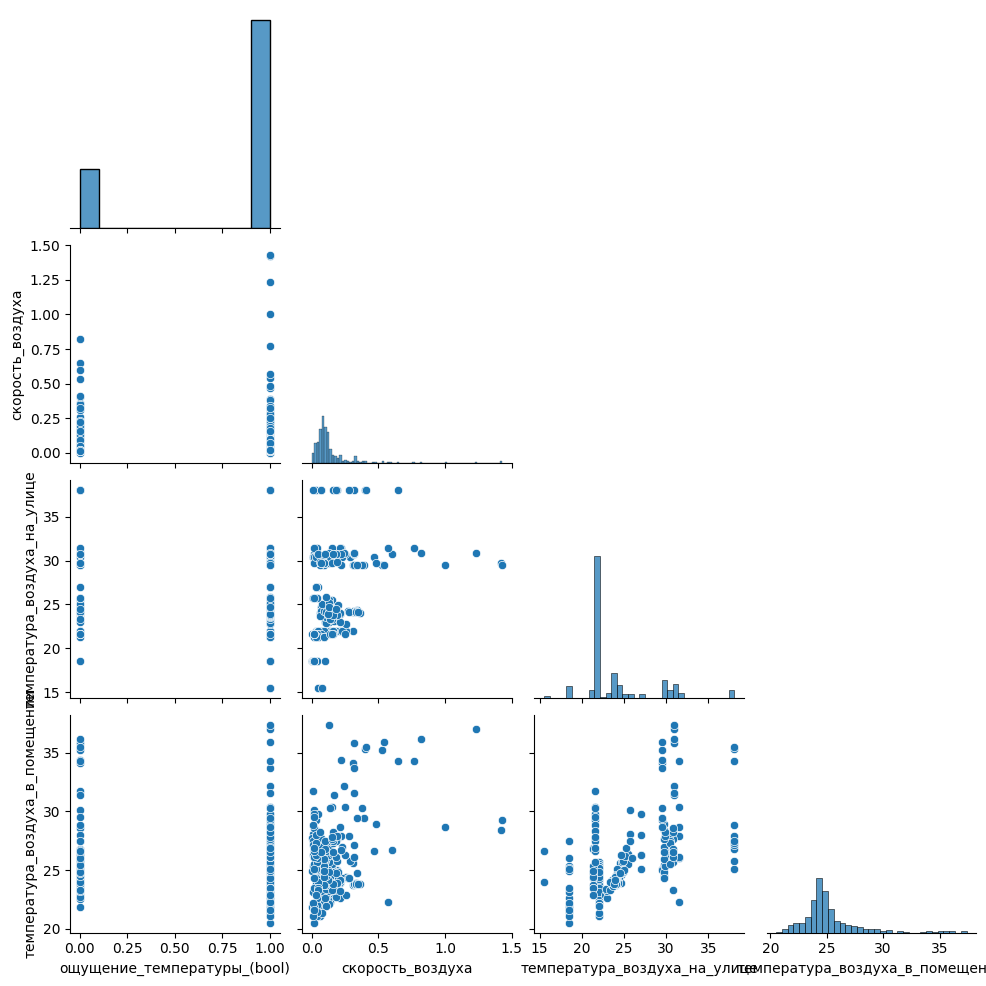

In [244]:
sns.pairplot(data[['ощущение_температуры_(bool)',
                   'скорость_воздуха',
                   'температура_воздуха_на_улице'] + [target]], corner=True);

In [245]:
SIZE = 0.15
RANDOM_STATE = 5

In [246]:
categories = ['время_года', 'климат', 'город',
              'влажность_в_офисе_категория', 'используемый_тип_охлаждения']
numerics = ['ощущение_температуры_(bool)',
            'скорость_воздуха',
            'температура_воздуха_на_улице']

In [247]:
features = data[categories + numerics]
targ = data[target]
x_train, x_test, y_train, y_test = train_test_split(features, targ,
                                                    test_size=SIZE,
                                                    random_state=RANDOM_STATE)

In [248]:
ohe = OneHotEncoder(sparse_output=False, drop='first')

def get_ohe(t, categ):
    temp = pd.DataFrame(data=ohe.transform(t[categ]), columns=ohe.get_feature_names_out())
    data = pd.concat([t.reset_index(drop=True), temp], axis=1)
    data = data.drop(columns=categ, axis=1)
    return data

ohe.fit(x_train[categories])
x_train = get_ohe(x_train, categories)
x_test = get_ohe(x_test, categories)

In [249]:
scaler = StandardScaler()
scaler.fit(x_train[numerics])
x_train[numerics] = scaler.transform(x_train[numerics])
x_test[numerics] = scaler.transform(x_test[numerics])

In [250]:
model = LinearRegression().fit(x_train, y_train)

In [251]:
prediction = model.predict(x_test)

In [252]:
# метрики, переведённые в проценты
r2 = round(r2_score(y_test, prediction.flatten()) * 100, 2)
mape = round(mean_absolute_percentage_error(y_test, prediction.flatten()) * 100, 2)

In [253]:
print('R2 score, %: ', r2)
print('MAPE, %: ', mape)

R2 score, %:  60.98
MAPE, %:  4.9


In [254]:
coeff_df = pd.DataFrame(model.coef_.flatten(), x_test.columns, columns=['коэффициенты_модели'])
coeff_df.sort_values(by='коэффициенты_модели', ascending=False)

коэффициенты_модели
город_Дели                                                     2.898632
климат_Влажный субтропический муссонный                        2.898632
климат_Жаркий полузасушливый                                   1.391619
город_Хайдарабад                                               1.343351
время_года_Лето                                                1.222434
температура_воздуха_на_улице                                   0.980644
время_года_Зима                                                0.646399
скорость_воздуха                                               0.325414
время_года_Осень                                               0.264176
влажность_в_офисе_категория_удовлетворительно                  0.025442
город_Ченнай                                                  -0.104629
влажность_в_офисе_категория_сыро                              -0.234218
ощущение_температуры_(bool)                                   -0.247764
город_Шимла                                                   -0.620649
климат_Субтропическое высокогорье                             -0.620649
используемый_тип_охлаждения_Смешанный Кондицион...            -0.642972
город_Бангалор                                                -0.655969
климат_Тропическая влажная саванна                            -0.760598
используемый_тип_охлаждения_Смешанный Вентиляция              -1.388909
используемый_тип_охлаждения_Кондиционирование                 -1.427497
город_Техас                                                   -1.427497
город_Сидней                                                  -1.481508

In [255]:
def quality_model(fact, pred):
  '''
  Функция выводит:
  - R2 для регрессионных моделей
  - Графики остатков: гистограмма, скаттерплот "отстатки - предсказанные значения"
  '''
  params = {'axes.labelsize': 14, 'figure.titlesize': 18, 'xtick.labelsize': 12,
            'ytick.labelsize': 12, 'legend.fontsize': 12}
  plt.rcParams.update(params)

  fact = pd.DataFrame(fact.reset_index(drop=True))
  pred = pd.DataFrame(pred.flatten(), columns=['предсказанное'])
  df = pd.concat([fact, pred], axis=1)
  df['остаток'] = df[target] - df['предсказанное']

  print('\033[1m' + 'Расчёт R2:' + '\033[0m')
  print('\033[1m' + 'Учтённые факторы на', round(r2_score(df[target], df['предсказанное']) * 100, 2),
        '% объясняют целевое значение' + '\033[0m')
  print('\033[1m' + 'Cредняя абсолютная ошибка: ', round(mean_absolute_percentage_error(y_test, prediction.flatten()) * 100, 2),
        '%' + '\033[0m')

  fig, ax = plt.subplots(1, 2, figsize=(9, 3))
  plt.tight_layout()
  plt.suptitle('Анализ остатков модели', y=1.05)

  sns.scatterplot(data=df, x='предсказанное', y=df['остаток'], ax=ax[0])
  sns.histplot(x=df['остаток'], bins=10, kde=True, ax=ax[1])

  ax[1].axvline(x=df['остаток'].mean(), color='r', label='mean')
  ax[1].axvline(x=df['остаток'].median(), color='tab:orange', label='median')

  ax[0].set_xlabel('Предсказанные значения')
  ax[1].set_ylabel('')
  ax[1].legend()
  plt.show()
  plt.style.use('default')

Расчёт R2:
Учтённые факторы на 60.98 % объясняют целевое значение
Cредняя абсолютная ошибка:  4.9 %


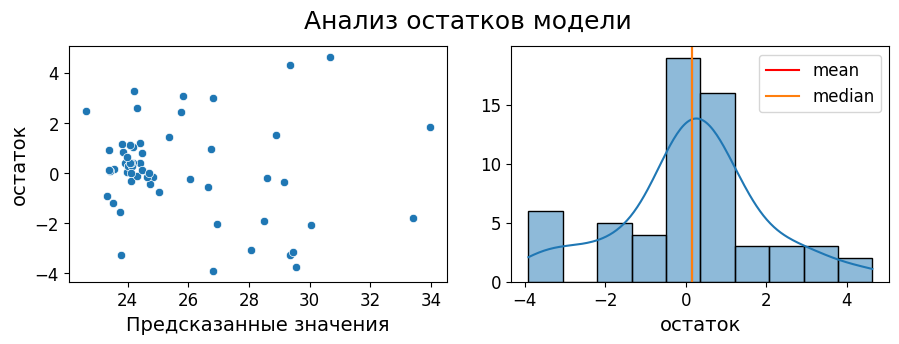

In [256]:
quality_model(y_test, prediction)